# This notebook is a guide for classification task in MURA dataset. 

Import the modules

In [ ]:
# !/opt/conda/bin/python3.7 -m pip install --upgrade pip
# # !python -m pip install pip==20.1.1
# # !pip install pip==20.1.1
# !pip -V

In [5]:
!pip uninstall tensorflow -y
!pip uninstall keras -y
!pip install tensorflow-gpu===2.4.0
!pip install keras==2.4.3
# !pip install -U tensorflow-gpu==2.7.0
# !pip install -U tensorflow==2.7.0

Found existing installation: Keras 2.4.3
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 394.7 MB 18 kB/s 
     |████████████████████████████████| 14.8 MB 41.5 MB/s 
     |████████████████████████████████| 462 kB 48.2 MB/s 
     |████████████████████████████████| 3.8 MB 40.7 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68711 sha256=d2127e50301fb5e1d6479776f2d14272b2c875cc59548fc1d505513fe84dd096
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting 

  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)


In [3]:
# to solve error of "cannot import name 'Resize' from 'albumentations.augmentations.transforms'" of the next cell
!pip install albumentations==0.5.2
# !albumentations --V
# !pip install -U git+https://github.com/albu/albumentations

In [ ]:
# To restart kernal
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [1]:
import tensorflow as tf
print("tf version: ",tf.__version__)
# tf.keras.__version__
print("tf.keras version: ",tf.keras.__version__)
import keras
print("keras.__version__: ",keras.__version__)

tf version:  2.4.0
tf.keras version:  2.4.0
keras.__version__:  2.4.3


In [5]:
import tensorflow as tf
import os
import pandas as pd
import cv2
from skimage.transform import rescale, resize
import keras
import numpy as np
from sklearn.utils import class_weight
# import tensorflow_addons as tfa
import pickle
from skimage.io import imread
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import datetime
import numpy as np

****Some utility functions****

In [7]:
#To get the filenames for a task
def filenames(part,train=True):
    root='../input/mura-v11/'
    if train:
        csv_path="../input/mura-v11/MURA-v1.1/train_image_paths.csv"
    else:
        csv_path="../input/mura-v11/MURA-v1.1/valid_image_paths.csv"
    
    with open(csv_path, 'rb') as F:
        d = F.readlines()
        if part == 'all':
            imgs = [root + str(x, encoding='utf-8').strip() for x in d] 
        else:
            imgs = [root + str(x, encoding='utf-8').strip() for x in d if
                            str(x, encoding='utf-8').strip().split('/')[2] == part]

    #imgs= [x.replace("/", "\\") for x in imgs]
    labels= [x.split('_')[-1].split('/')[0] for x in imgs]
    return imgs,labels


#To icrop a image from center
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]


**Data augmentations**

In [8]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, CenterCrop, RandomGridShuffle,GridDistortion,ShiftScaleRotate  #CropAndPad, CropNonEmptyMaskIfExists, LongestMaxSize
)
from albumentations.augmentations.transforms import Resize
AUGMENTATIONS_TRAIN = Compose([
        HorizontalFlip(p=0.5),
        RandomContrast(limit=0.2, p=0.5),
        RandomGamma(gamma_limit=(80, 120), p=0.5),
        RandomBrightness(limit=0.25, p=0.5),
        ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.1, 
            rotate_limit=18, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
        ToFloat(max_value=255),
        RandomGridShuffle(grid=(2,2)),
        GridDistortion(8),
])
AUGMENTATIONS_TEST = Compose([
    CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255),
#     HorizontalFlip(p=0.5),
#     RandomContrast(limit=0.2, p=0.5),
#     RandomGamma(gamma_limit=(80, 120), p=0.5),
#     RandomBrightness(limit=0.25, p=0.5),
#     ShiftScaleRotate(
#         shift_limit=0.0625, scale_limit=0.1, 
#         rotate_limit=18, border_mode=cv2.BORDER_REFLECT_101, p=0.8),
#     RandomGridShuffle(grid=(2,2)),
#     GridDistortion(8),
])

**Plotting the augmentations**

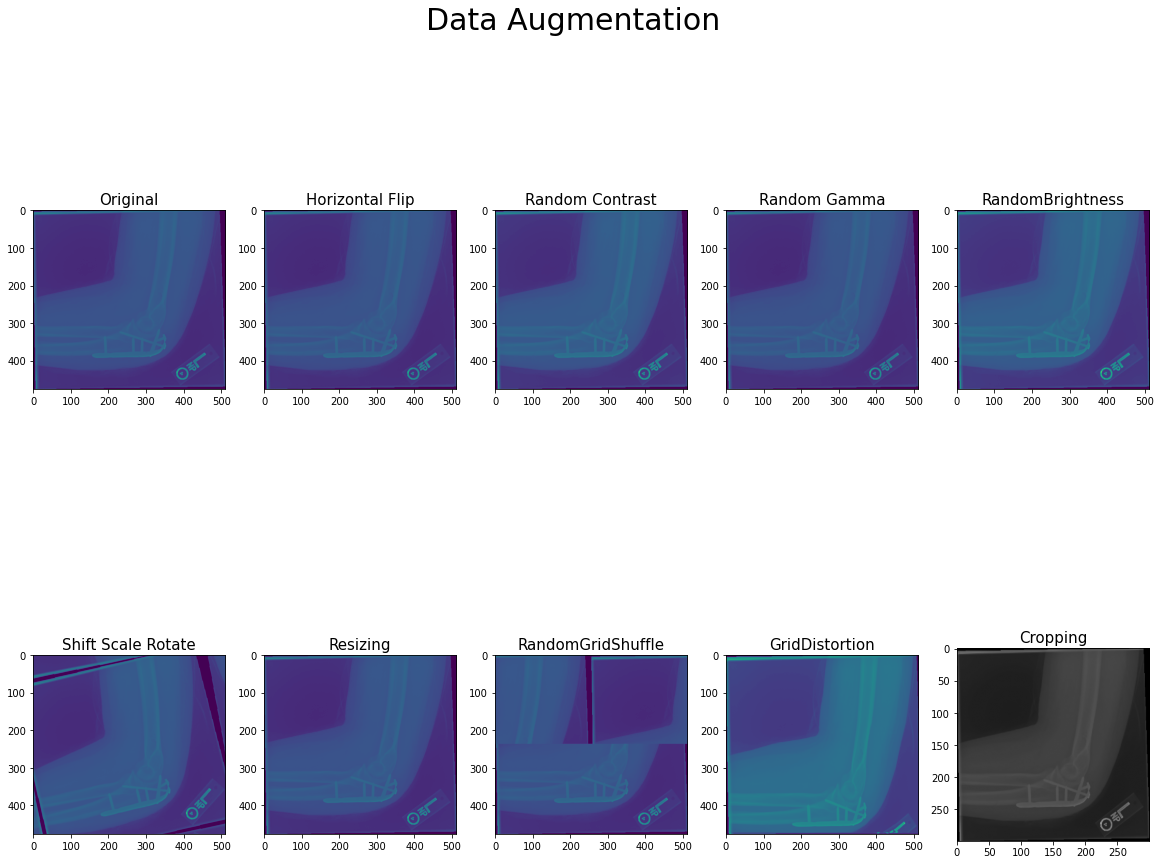

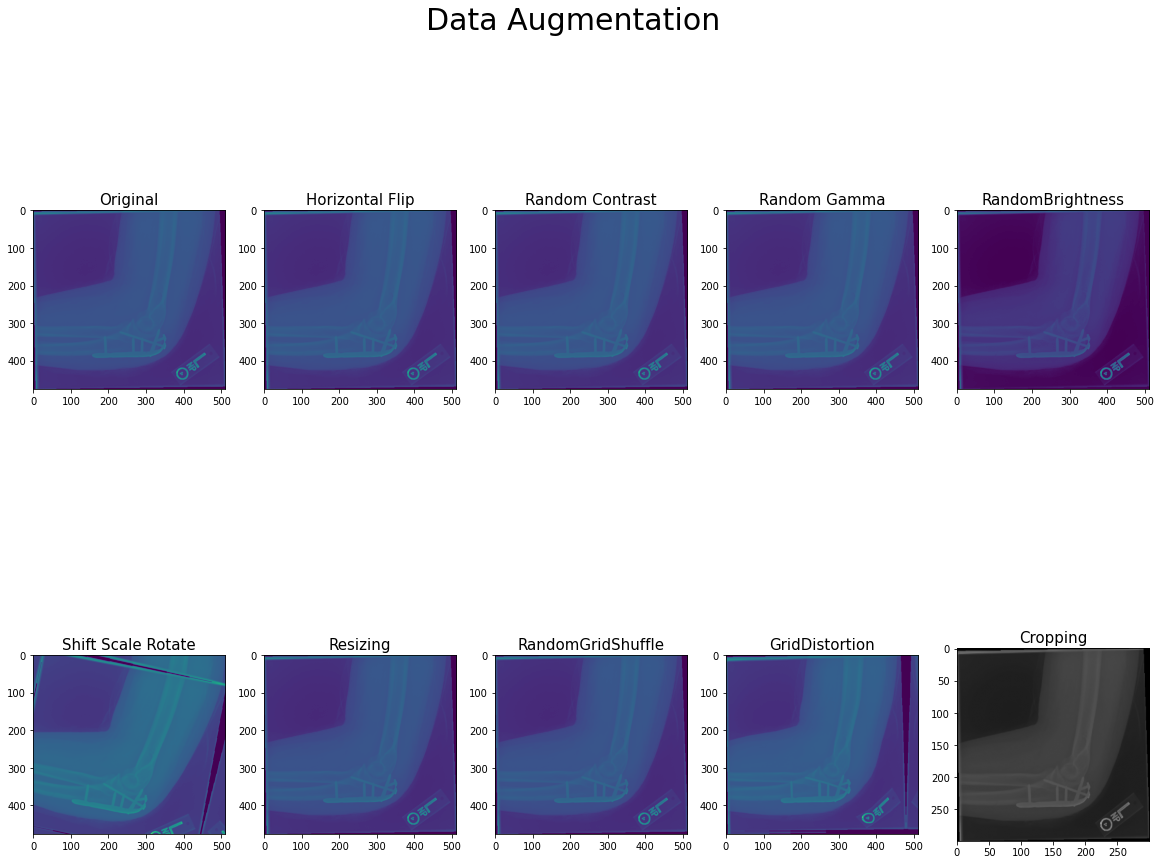

In [ ]:
for i in range(2):
    albumentation_list =  [
        HorizontalFlip(p=0.5),
        RandomContrast(limit=0.2, p=0.5),
        RandomGamma(gamma_limit=(80, 120), p=0.5),
        RandomBrightness(limit=0.25, p=0.5),
        ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.1, 
            rotate_limit=18, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
        ToFloat(max_value=255),
        RandomGridShuffle(grid=(2,2)),
        GridDistortion(8),

    ]
    root='../input/mura-v11/'
    chosen_image= imread(root+'MURA-v1.1/train/XR_ELBOW/patient05046/study1_positive/image1.png')
    img_matrix_list = []
    bboxes_list = []
    for aug_type in albumentation_list:
        img = aug_type(image = chosen_image)['image']
        img_matrix_list.append(img)
    img= resize(chosen_image,(300,300,3))
    img_matrix_list.append(img)
    img_matrix_list.append(crop_center(img,224,224))

    img_matrix_list.insert(0,chosen_image)    

    titles_list = ["Original","Horizontal Flip","Random Contrast","Random Gamma","RandomBrightness",
                   "Shift Scale Rotate","Resizing", "RandomGridShuffle", "GridDistortion","Cropping"]

    def plot_multiple_img(img_matrix_list, title_list, ncols, main_title="Data Augmentation"):
        fig, myaxes = plt.subplots(figsize=(20, 15), nrows=2, ncols=ncols, squeeze=True)
        fig.suptitle(main_title, fontsize = 30)
        #fig.subplots_adjust(wspace=0.3)
        #fig.subplots_adjust(hspace=0.3)
        for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
            myaxes[i // ncols][i % ncols].imshow(img)
            myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
        plt.show()

    plot_multiple_img(img_matrix_list, titles_list, ncols = 5)

**Creating data generator for training and testiing with augmentation:**

In [9]:
class My_Custom_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size,transform) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.t= transform
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    x=[]
    for file in batch_x:
        img= imread(file)
        img= self.t(image=img)["image"]
        img= resize(img,(300,300,3))
        img= crop_center(img,224,224)
        x.append(img)
    x=np.array(x)/255.0
    y= np.array(batch_y)
    return x,y

**Some information about data:**

In [ ]:
train_dir = "../input/mura-v11/MURA-v1.1/train"
validation_dir = '../input/mura-v11/MURA-v1.1/valid'
print("Total Training patients: ")
for i in os.listdir(train_dir) :
  print('Total Training patients at {}:'.format(i),len(os.listdir("../input/mura-v11/MURA-v1.1/train/{}".format(i))))
print("\nTotal Validation patients: ")
for i in os.listdir(validation_dir) :
  print('Total Validation patients at {}:'.format(i),len(os.listdir("../input/mura-v11/MURA-v1.1/valid/{}".format(i))))

# print("Total Training pics: ")
# for part in os.listdir(train_dir) :
#     imgs,labels= filenames(part=part) # train data
#     vimgs,vlabels= filenames(part=part,train=False) # validation data

#     print('{} Training positive :'.format(part),labels.count('positive'),'\n','{} Training negative :'.format(part),labels.count('negative'))
#     training_data= labels.count('positive')+labels.count('negative')
#     print("Total Training Data at {}: ".format(part), training_data)
#     print('\n')
#     print('{} Validation positive :'.format(part),vlabels.count('positive'),'\n','{} Validation negative :'.format(part),vlabels.count('negative'))
#     validation_data= vlabels.count('positive')+vlabels.count('negative')
#     print("Total Validation Data: ", validation_data)

Total Training patients: 
Total Training patients at XR_WRIST: 3267


Total Training patients at XR_FINGER: 1865
Total Training patients at XR_SHOULDER: 2694


Total Training patients at XR_HAND: 1945
Total Training patients at XR_FOREARM: 865
Total Training patients at XR_HUMERUS: 587


Total Training patients at XR_ELBOW: 1711

Total Validation patients: 
Total Validation patients at XR_WRIST: 207
Total Validation patients at XR_FINGER: 166
Total Validation patients at XR_SHOULDER: 173
Total Validation patients at XR_HAND: 159
Total Validation patients at XR_FOREARM: 129
Total Validation patients at XR_HUMERUS: 132
Total Validation patients at XR_ELBOW: 152


**Getting data using the utility functions**

In [15]:
########################################
# One of the seven listed below:
"""
XR_ELBOW
XR_FINGER
XR_FOREARM
XR_HAND
XR_HUMERUS
XR_SHOULDER
XR_WRIST
""" 
# training_bone = 'XR_HUMERUS'
########################################

part='XR_ELBOW' # part to work with
imgs,labels= filenames(part=part) # train data
vimgs,vlabels= filenames(part=part,train=False) # validation data

print('{} Training positive :'.format(part),labels.count('positive'),'\n','{} Training negative :'.format(part),labels.count('negative'))
training_data= labels.count('positive')+labels.count('negative')
print(">> Total Training Data at {}: ".format(part), training_data)
print('\n')
print('{} Validation positive :'.format(part),vlabels.count('positive'),'\n','{} Validation negative :'.format(part),vlabels.count('negative'))
validation_data= vlabels.count('positive')+vlabels.count('negative')
print(">> Total Validation Data: ", validation_data)

y_data= [0 if x=='positive' else 1 for x in labels]
y_data= tf.keras.utils.to_categorical(y_data)
vy_data= [0 if x=='positive' else 1 for x in vlabels]
vy_data= tf.keras.utils.to_categorical(vy_data)

XR_ELBOW Training positive : 2006 
 XR_ELBOW Training negative : 2925
>> Total Training Data at XR_ELBOW:  4931


XR_ELBOW Validation positive : 230 
 XR_ELBOW Validation negative : 235
>> Total Validation Data:  465


**Calculate class-weight to avoid class-imbalance :**

In [50]:
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_data, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

**Create Training and Test daat generator**

In [17]:
batch_size = 32
imgs, y_data = shuffle(imgs, y_data)
#vimgs, vy_data = shuffle(vimgs, vy_data)
my_training_batch_generator = My_Custom_Generator(imgs, y_data, batch_size,AUGMENTATIONS_TRAIN)
my_validation_batch_generator = My_Custom_Generator(vimgs, vy_data, batch_size,AUGMENTATIONS_TEST)

**Training callbacks**

In [ ]:

checkpoint_path = "MURA_model@{}.h5".format(str(part))  
checkpoint_dir = os.path.dirname(checkpoint_path)
import json
json_log = open(str(part)+'_experiment_log_MURA.json', mode='wt', buffering=1)
my_callbacks = [
                    keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,  # Callback to save the Keras model or model weights at some frequency.
                                                    monitor='val_accuracy',
                                                    verbose=0,
                                                    save_best_only=True,
                                                    save_weights_only=False,
                                                    mode='auto',
                                                    save_freq = 'epoch'),
                    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',     # Reduce learning rate when a metric has stopped improving.
                                                      factor=0.1,
                                                      patience=3,
                                                      min_delta=0.001,
                                                      verbose=1,
                                                      min_lr=0.000000001),
                    keras.callbacks.LambdaCallback(
                                                    on_epoch_end=lambda epoch,
                                                    logs: json_log.write(json.dumps({'epoch': epoch, 
                                                                                     'train_loss': logs['loss'],
                                                                                     'val_loss': logs['val_loss'],
                                                                                      'weights': ""}) + '\n'), # dict(model.get_weights()) - np.array(model.get_weights()).tolist()
                                                    on_train_end=lambda logs: json_log.close()),
                    keras.callbacks.TensorBoard(log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
                                                 histogram_freq=1, 
                                                 write_graph=True, 
                                                 write_images=False,    
                                                 update_freq='epoch', 
                                                 profile_batch=30, 
                                                 embeddings_freq=1,    
                                                 embeddings_metadata=None 
                                                 ),
                    keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=18,
                                                  mode="max",
                                                  baseline=0.85,
                                                  restore_best_weights=True,
)
                ]

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

2021-12-27 03:43:58.905965: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-12-27 03:43:58.907512: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-27 03:43:58.947961: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1391] Profiler found 1 GPUs
2021-12-27 03:43:58.948485: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcupti.so.10.1'; dlerror: libcupti.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-12-27 03:43:58.966202: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcupti.so
2021-12-27 03:43:58.986286: I 

In [ ]:
# np.array(model.get_weights()).tolist()

In [ ]:
my_callbacks,d_class_weights

([<tensorflow.python.keras.callbacks.ModelCheckpoint at 0x7fbff9011f90>,
 {0: 1.2290628115653042, 1: 0.842905982905983})

**Create a model**

Second model try:


In [ ]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [ ]:
# local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
# # how to download a model from google drive
# ! conda install -y gdown
# import gdown
# url = 'https://drive.google.com/uc?id=1nx9aQ2NljNRAc6l58EOruDm8MZlvapGJ'
# output = '/tmp/MURA_model@XR_WRIST-2.h5'
# gdown.download(url, output, quiet=False)
# local_weights_file = output

In [ ]:
##### Another model try: ########
base_model=keras.applications.InceptionV3(
    weights='imagenet',  # Load weights pre-trained on ImageNet.,
    input_shape=(224,224,3),
    include_top=False) # Do not include the ImageNet classifier at the top

# odl from original
# for layer in base_model.layers[:280]:
#     layer.trainable=False

# Freeze base model
# base_model.trainable = False

# Create a new model on top
input_image=keras.layers.Input((224,224,3))

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(input_image)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x=keras.layers.GlobalAveragePooling2D()(x)  ##### <-
x=keras.layers.Flatten()(x)

# x=keras.layers.Dense(2048)(x) ###
# x=keras.layers.Activation(activation='relu')(x) ###
# x= keras.layers.Dropout(0.5)(x) ###
# x=keras.layers.Dense(2048)(x)
# x=keras.layers.Activation(activation='relu')(x)
# x= keras.layers.Dropout(0.5)(x)
# x=keras.layers.Dense(1024)(x)
# x=keras.layers.Activation(activation='relu')(x)
# x= keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(512)(x)
x=keras.layers.Activation(activation='relu')(x)
x= keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(2)(x)
out=keras.layers.Activation(activation='softmax')(x)

model=keras.Model(inputs=input_image,outputs=out)
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

2021-12-27 03:44:02.469841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 03:44:02.470575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-12-27 03:44:02.470795: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-12-27 03:44:02.471

    8192/87910968 [..............................] - ETA: 1s

 6389760/87910968 [=>............................] - ETA: 0s

15368192/87910968 [====>.........................] - ETA: 0s

27508736/87910968 [========>.....................] - ETA: 0s

39444480/87910968 [============>.................] - ETA: 0s

51593216/87910968 [================>.............] - ETA: 0s

63741952/87910968 [====================>.........] - ETA: 0s

67117056/87910968 [=====================>........] - ETA: 0s

78225408/87910968 [=========================>....] - ETA: 0s

87916544/87910968 [==============================] - 1s 0us/step


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
activation_94 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)              

In [ ]:
len(base_model.layers[0:])

311

*  *Training*

In [ ]:
history=model.fit_generator(generator=my_training_batch_generator,
                   steps_per_epoch = int(training_data // batch_size),
                   epochs = 25,
                   verbose = 1,
                   class_weight=d_class_weights,
                   validation_data = my_validation_batch_generator,
                   validation_steps = int(validation_data // batch_size),
                   callbacks=my_callbacks)

Epoch 1/25


  1/154 [..............................] - ETA: 0s - loss: 0.7630 - accuracy: 0.5312

  2/154 [..............................] - ETA: 14:20 - loss: 0.7427 - accuracy: 0.5469

  3/154 [..............................] - ETA: 18:35 - loss: 0.7348 - accuracy: 0.5417

  4/154 [..............................] - ETA: 21:38 - loss: 0.7566 - accuracy: 0.5078

  5/154 [..............................] - ETA: 22:48 - loss: 0.7659 - accuracy: 0.5125

  6/154 [>.............................] - ETA: 23:55 - loss: 0.7318 - accuracy: 0.5312

  7/154 [>.............................] - ETA: 24:18 - loss: 0.7422 - accuracy: 0.5312

  8/154 [>.............................] - ETA: 24:43 - loss: 0.7410 - accuracy: 0.5430

  9/154 [>.............................] - ETA: 25:05 - loss: 0.7441 - accuracy: 0.5417

 10/154 [>.............................] - ETA: 25:03 - loss: 0.7480 - accuracy: 0.5437

 11/154 [=>............................] - ETA: 25:07 - loss: 0.7457 - accuracy: 0.5483

 12/154 [=>............................] - ETA: 25:20 - loss: 0.7464 - accuracy: 0.5495

 13/154 [=>............................] - ETA: 25:24 - loss: 0.7519 - accuracy: 0.5457

 14/154 [=>............................] - ETA: 25:21 - loss: 0.7467 - accuracy: 0.5536

 15/154 [=>............................] - ETA: 25:25 - loss: 0.7447 - accuracy: 0.5583

 16/154 [==>...........................] - ETA: 25:19 - loss: 0.7374 - accuracy: 0.5605

 17/154 [==>...........................] - ETA: 25:12 - loss: 0.7356 - accuracy: 0.5625

 18/154 [==>...........................] - ETA: 25:13 - loss: 0.7391 - accuracy: 0.5608

 19/154 [==>...........................] - ETA: 25:03 - loss: 0.7486 - accuracy: 0.5592

 20/154 [==>...........................] - ETA: 24:58 - loss: 0.7582 - accuracy: 0.5516

 21/154 [===>..........................] - ETA: 24:50 - loss: 0.7608 - accuracy: 0.5432

 22/154 [===>..........................] - ETA: 24:38 - loss: 0.7628 - accuracy: 0.5412

 23/154 [===>..........................] - ETA: 24:29 - loss: 0.7658 - accuracy: 0.5408

 24/154 [===>..........................] - ETA: 24:18 - loss: 0.7610 - accuracy: 0.5430

 25/154 [===>..........................] - ETA: 24:08 - loss: 0.7608 - accuracy: 0.5462

 26/154 [====>.........................] - ETA: 23:59 - loss: 0.7503 - accuracy: 0.5553

 27/154 [====>.........................] - ETA: 23:43 - loss: 0.7544 - accuracy: 0.5544

 28/154 [====>.........................] - ETA: 22:49 - loss: 0.7553 - accuracy: 0.5548

 29/154 [====>.........................] - ETA: 22:44 - loss: 0.7564 - accuracy: 0.5551

2021-12-27 03:49:47.463967: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 30/154 [====>.........................] - ETA: 22:38 - loss: 0.7555 - accuracy: 0.5542

2021-12-27 03:49:59.524159: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2021-12-27 03:49:59.531227: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-12-27 03:49:59.549945: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/fit/20211227-034358/train/plugins/profile/2021_12_27_03_49_59
2021-12-27 03:49:59.559753: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/fit/20211227-034358/train/plugins/profile/2021_12_27_03_49_59/122cb4127d8e.trace.json.gz
2021-12-27 03:49:59.574954: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/fit/20211227-034358/train/plugins/profile/2021_12_27_03_49_59
2021-12-27 03:49:59.575035: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to lo

 31/154 [=====>........................] - ETA: 22:28 - loss: 0.7566 - accuracy: 0.5524

 32/154 [=====>........................] - ETA: 22:17 - loss: 0.7539 - accuracy: 0.5538

 33/154 [=====>........................] - ETA: 22:11 - loss: 0.7539 - accuracy: 0.5550

 34/154 [=====>........................] - ETA: 22:03 - loss: 0.7514 - accuracy: 0.5534

 35/154 [=====>........................] - ETA: 21:55 - loss: 0.7469 - accuracy: 0.5564

 36/154 [======>.......................] - ETA: 21:45 - loss: 0.7394 - accuracy: 0.5628

 37/154 [======>.......................] - ETA: 21:35 - loss: 0.7389 - accuracy: 0.5645

 38/154 [======>.......................] - ETA: 21:25 - loss: 0.7345 - accuracy: 0.5670

 39/154 [======>.......................] - ETA: 21:14 - loss: 0.7370 - accuracy: 0.5669

 40/154 [======>.......................] - ETA: 21:03 - loss: 0.7342 - accuracy: 0.5675

 41/154 [======>.......................] - ETA: 20:54 - loss: 0.7291 - accuracy: 0.5705

 42/154 [=======>......................] - ETA: 20:43 - loss: 0.7274 - accuracy: 0.5711

 43/154 [=======>......................] - ETA: 20:33 - loss: 0.7297 - accuracy: 0.5687

 44/154 [=======>......................] - ETA: 20:24 - loss: 0.7245 - accuracy: 0.5736

 45/154 [=======>......................] - ETA: 20:12 - loss: 0.7219 - accuracy: 0.5769

 46/154 [=======>......................] - ETA: 20:02 - loss: 0.7167 - accuracy: 0.5828

 47/154 [========>.....................] - ETA: 19:52 - loss: 0.7144 - accuracy: 0.5864

 48/154 [========>.....................] - ETA: 19:42 - loss: 0.7185 - accuracy: 0.5833

 49/154 [========>.....................] - ETA: 19:30 - loss: 0.7156 - accuracy: 0.5835

 50/154 [========>.....................] - ETA: 19:20 - loss: 0.7148 - accuracy: 0.5856

 51/154 [========>.....................] - ETA: 19:08 - loss: 0.7108 - accuracy: 0.5908

 52/154 [=========>....................] - ETA: 18:57 - loss: 0.7097 - accuracy: 0.5914

 53/154 [=========>....................] - ETA: 18:46 - loss: 0.7082 - accuracy: 0.5951

 54/154 [=========>....................] - ETA: 18:35 - loss: 0.7051 - accuracy: 0.5986

 55/154 [=========>....................] - ETA: 18:24 - loss: 0.7044 - accuracy: 0.5979

 56/154 [=========>....................] - ETA: 18:13 - loss: 0.7016 - accuracy: 0.6001

 57/154 [==========>...................] - ETA: 18:02 - loss: 0.7002 - accuracy: 0.6028

 58/154 [==========>...................] - ETA: 17:50 - loss: 0.7000 - accuracy: 0.6021

 59/154 [==========>...................] - ETA: 17:40 - loss: 0.7008 - accuracy: 0.6019

 60/154 [==========>...................] - ETA: 17:28 - loss: 0.7019 - accuracy: 0.5997

 61/154 [==========>...................] - ETA: 17:16 - loss: 0.6983 - accuracy: 0.6022

 62/154 [===========>..................] - ETA: 17:05 - loss: 0.6968 - accuracy: 0.6020

 63/154 [===========>..................] - ETA: 16:54 - loss: 0.6972 - accuracy: 0.6009

 64/154 [===========>..................] - ETA: 16:43 - loss: 0.6955 - accuracy: 0.6033

 65/154 [===========>..................] - ETA: 16:33 - loss: 0.6940 - accuracy: 0.6031

 66/154 [===========>..................] - ETA: 16:22 - loss: 0.6940 - accuracy: 0.6025

 67/154 [============>.................] - ETA: 16:10 - loss: 0.6916 - accuracy: 0.6047

 68/154 [============>.................] - ETA: 16:00 - loss: 0.6914 - accuracy: 0.6055

 69/154 [============>.................] - ETA: 15:49 - loss: 0.6923 - accuracy: 0.6058

 70/154 [============>.................] - ETA: 15:38 - loss: 0.6890 - accuracy: 0.6079

 71/154 [============>.................] - ETA: 15:27 - loss: 0.6889 - accuracy: 0.6068

 72/154 [=============>................] - ETA: 15:15 - loss: 0.6877 - accuracy: 0.6079

 73/154 [=============>................] - ETA: 15:05 - loss: 0.6878 - accuracy: 0.6077

 74/154 [=============>................] - ETA: 14:53 - loss: 0.6899 - accuracy: 0.6067

 75/154 [=============>................] - ETA: 14:42 - loss: 0.6901 - accuracy: 0.6065

 76/154 [=============>................] - ETA: 14:31 - loss: 0.6889 - accuracy: 0.6063

 77/154 [==============>...............] - ETA: 14:20 - loss: 0.6867 - accuracy: 0.6078

 78/154 [==============>...............] - ETA: 14:08 - loss: 0.6862 - accuracy: 0.6076

 79/154 [==============>...............] - ETA: 13:58 - loss: 0.6846 - accuracy: 0.6090

 80/154 [==============>...............] - ETA: 13:46 - loss: 0.6844 - accuracy: 0.6104

 81/154 [==============>...............] - ETA: 13:35 - loss: 0.6820 - accuracy: 0.6130

 82/154 [==============>...............] - ETA: 13:24 - loss: 0.6806 - accuracy: 0.6139

 83/154 [===============>..............] - ETA: 13:13 - loss: 0.6799 - accuracy: 0.6132

 84/154 [===============>..............] - ETA: 13:01 - loss: 0.6782 - accuracy: 0.6156

 85/154 [===============>..............] - ETA: 12:50 - loss: 0.6763 - accuracy: 0.6172

 86/154 [===============>..............] - ETA: 12:39 - loss: 0.6748 - accuracy: 0.6188

 87/154 [===============>..............] - ETA: 12:28 - loss: 0.6737 - accuracy: 0.6200

 88/154 [================>.............] - ETA: 12:17 - loss: 0.6730 - accuracy: 0.6204

 89/154 [================>.............] - ETA: 12:05 - loss: 0.6721 - accuracy: 0.6204

 90/154 [================>.............] - ETA: 11:54 - loss: 0.6709 - accuracy: 0.6212

 91/154 [================>.............] - ETA: 11:43 - loss: 0.6696 - accuracy: 0.6205

 92/154 [================>.............] - ETA: 11:32 - loss: 0.6704 - accuracy: 0.6189

 93/154 [=================>............] - ETA: 11:21 - loss: 0.6682 - accuracy: 0.6210

 94/154 [=================>............] - ETA: 11:10 - loss: 0.6661 - accuracy: 0.6220

 95/154 [=================>............] - ETA: 10:58 - loss: 0.6664 - accuracy: 0.6227

 96/154 [=================>............] - ETA: 10:47 - loss: 0.6658 - accuracy: 0.6224

 97/154 [=================>............] - ETA: 10:36 - loss: 0.6660 - accuracy: 0.6221

 98/154 [==================>...........] - ETA: 10:25 - loss: 0.6668 - accuracy: 0.6212

 99/154 [==================>...........] - ETA: 10:13 - loss: 0.6646 - accuracy: 0.6234

100/154 [==================>...........] - ETA: 10:02 - loss: 0.6639 - accuracy: 0.6244

101/154 [==================>...........] - ETA: 9:51 - loss: 0.6638 - accuracy: 0.6244 

102/154 [==================>...........] - ETA: 9:40 - loss: 0.6640 - accuracy: 0.6253

103/154 [===================>..........] - ETA: 9:29 - loss: 0.6630 - accuracy: 0.6260

104/154 [===================>..........] - ETA: 9:18 - loss: 0.6631 - accuracy: 0.6259

105/154 [===================>..........] - ETA: 9:06 - loss: 0.6618 - accuracy: 0.6271

106/154 [===================>..........] - ETA: 8:56 - loss: 0.6608 - accuracy: 0.6286

107/154 [===================>..........] - ETA: 8:45 - loss: 0.6600 - accuracy: 0.6289

108/154 [====================>.........] - ETA: 8:33 - loss: 0.6595 - accuracy: 0.6285

109/154 [====================>.........] - ETA: 8:22 - loss: 0.6589 - accuracy: 0.6291

110/154 [====================>.........] - ETA: 8:11 - loss: 0.6576 - accuracy: 0.6311

111/154 [====================>.........] - ETA: 8:00 - loss: 0.6561 - accuracy: 0.6324

112/154 [====================>.........] - ETA: 7:49 - loss: 0.6552 - accuracy: 0.6338

113/154 [=====================>........] - ETA: 7:38 - loss: 0.6551 - accuracy: 0.6334

114/154 [=====================>........] - ETA: 7:26 - loss: 0.6541 - accuracy: 0.6347

115/154 [=====================>........] - ETA: 7:16 - loss: 0.6543 - accuracy: 0.6341

116/154 [=====================>........] - ETA: 7:04 - loss: 0.6536 - accuracy: 0.6343

117/154 [=====================>........] - ETA: 6:53 - loss: 0.6533 - accuracy: 0.6342

118/154 [=====================>........] - ETA: 6:42 - loss: 0.6520 - accuracy: 0.6354

119/154 [======================>.......] - ETA: 6:31 - loss: 0.6523 - accuracy: 0.6361

120/154 [======================>.......] - ETA: 6:20 - loss: 0.6510 - accuracy: 0.6379

121/154 [======================>.......] - ETA: 6:09 - loss: 0.6510 - accuracy: 0.6386

122/154 [======================>.......] - ETA: 5:58 - loss: 0.6509 - accuracy: 0.6385

123/154 [======================>.......] - ETA: 5:47 - loss: 0.6499 - accuracy: 0.6399

124/154 [=======================>......] - ETA: 5:35 - loss: 0.6503 - accuracy: 0.6398

125/154 [=======================>......] - ETA: 5:24 - loss: 0.6495 - accuracy: 0.6406

126/154 [=======================>......] - ETA: 5:13 - loss: 0.6491 - accuracy: 0.6415

127/154 [=======================>......] - ETA: 5:02 - loss: 0.6485 - accuracy: 0.6419

128/154 [=======================>......] - ETA: 4:51 - loss: 0.6494 - accuracy: 0.6418

129/154 [========================>.....] - ETA: 4:40 - loss: 0.6486 - accuracy: 0.6419

130/154 [========================>.....] - ETA: 4:28 - loss: 0.6477 - accuracy: 0.6425

131/154 [========================>.....] - ETA: 4:17 - loss: 0.6472 - accuracy: 0.6430

132/154 [========================>.....] - ETA: 4:06 - loss: 0.6461 - accuracy: 0.6441

133/154 [========================>.....] - ETA: 3:55 - loss: 0.6458 - accuracy: 0.6440

134/154 [=========================>....] - ETA: 3:44 - loss: 0.6446 - accuracy: 0.6452

135/154 [=========================>....] - ETA: 3:33 - loss: 0.6437 - accuracy: 0.6455

136/154 [=========================>....] - ETA: 3:21 - loss: 0.6428 - accuracy: 0.6463

137/154 [=========================>....] - ETA: 3:10 - loss: 0.6411 - accuracy: 0.6471

138/154 [=========================>....] - ETA: 2:59 - loss: 0.6415 - accuracy: 0.6460

139/154 [==========================>...] - ETA: 2:48 - loss: 0.6412 - accuracy: 0.6458

140/154 [==========================>...] - ETA: 2:37 - loss: 0.6400 - accuracy: 0.6468

141/154 [==========================>...] - ETA: 2:25 - loss: 0.6392 - accuracy: 0.6476

142/154 [==========================>...] - ETA: 2:14 - loss: 0.6376 - accuracy: 0.6487

143/154 [==========================>...] - ETA: 2:03 - loss: 0.6371 - accuracy: 0.6483

144/154 [===========================>..] - ETA: 1:52 - loss: 0.6362 - accuracy: 0.6490

145/154 [===========================>..] - ETA: 1:41 - loss: 0.6361 - accuracy: 0.6493

146/154 [===========================>..] - ETA: 1:29 - loss: 0.6348 - accuracy: 0.6504

147/154 [===========================>..] - ETA: 1:18 - loss: 0.6352 - accuracy: 0.6507

148/154 [===========================>..] - ETA: 1:07 - loss: 0.6346 - accuracy: 0.6503

149/154 [============================>.] - ETA: 56s - loss: 0.6355 - accuracy: 0.6491 

150/154 [============================>.] - ETA: 44s - loss: 0.6350 - accuracy: 0.6502

151/154 [============================>.] - ETA: 33s - loss: 0.6346 - accuracy: 0.6502

152/154 [============================>.] - ETA: 22s - loss: 0.6343 - accuracy: 0.6505

153/154 [============================>.] - ETA: 11s - loss: 0.6336 - accuracy: 0.6509

154/154 [==============================] - ETA: 0s - loss: 0.6334 - accuracy: 0.6512 

154/154 [==============================] - 1785s 12s/step - loss: 0.6334 - accuracy: 0.6512 - val_loss: 0.7424 - val_accuracy: 0.4665


Epoch 2/25


  1/154 [..............................] - ETA: 0s - loss: 0.6688 - accuracy: 0.7188

  2/154 [..............................] - ETA: 15:13 - loss: 0.6748 - accuracy: 0.6562

  3/154 [..............................] - ETA: 19:28 - loss: 0.6092 - accuracy: 0.6979

  4/154 [..............................] - ETA: 21:36 - loss: 0.6052 - accuracy: 0.6875

  5/154 [..............................] - ETA: 22:58 - loss: 0.5801 - accuracy: 0.7063

  6/154 [>.............................] - ETA: 23:39 - loss: 0.5947 - accuracy: 0.7031

  7/154 [>.............................] - ETA: 24:08 - loss: 0.5870 - accuracy: 0.7098

  8/154 [>.............................] - ETA: 24:22 - loss: 0.5705 - accuracy: 0.7188

  9/154 [>.............................] - ETA: 24:32 - loss: 0.5650 - accuracy: 0.7257

 10/154 [>.............................] - ETA: 24:39 - loss: 0.5485 - accuracy: 0.7406

 11/154 [=>............................] - ETA: 24:45 - loss: 0.5341 - accuracy: 0.7557

 12/154 [=>............................] - ETA: 24:44 - loss: 0.5366 - accuracy: 0.7526

 13/154 [=>............................] - ETA: 24:43 - loss: 0.5383 - accuracy: 0.7524

 14/154 [=>............................] - ETA: 24:47 - loss: 0.5394 - accuracy: 0.7545

 15/154 [=>............................] - ETA: 24:37 - loss: 0.5360 - accuracy: 0.7563

 16/154 [==>...........................] - ETA: 24:32 - loss: 0.5337 - accuracy: 0.7539

 17/154 [==>...........................] - ETA: 24:31 - loss: 0.5360 - accuracy: 0.7500

 18/154 [==>...........................] - ETA: 24:25 - loss: 0.5372 - accuracy: 0.7483

 19/154 [==>...........................] - ETA: 24:26 - loss: 0.5379 - accuracy: 0.7451

 20/154 [==>...........................] - ETA: 24:17 - loss: 0.5298 - accuracy: 0.7531

 21/154 [===>..........................] - ETA: 24:09 - loss: 0.5287 - accuracy: 0.7545

 22/154 [===>..........................] - ETA: 24:01 - loss: 0.5306 - accuracy: 0.7514

 23/154 [===>..........................] - ETA: 23:53 - loss: 0.5265 - accuracy: 0.7514

 24/154 [===>..........................] - ETA: 23:43 - loss: 0.5265 - accuracy: 0.7526

 25/154 [===>..........................] - ETA: 23:38 - loss: 0.5203 - accuracy: 0.7575

 26/154 [====>.........................] - ETA: 23:29 - loss: 0.5253 - accuracy: 0.7524

 27/154 [====>.........................] - ETA: 23:19 - loss: 0.5253 - accuracy: 0.7523

 28/154 [====>.........................] - ETA: 23:12 - loss: 0.5264 - accuracy: 0.7467

 29/154 [====>.........................] - ETA: 23:00 - loss: 0.5282 - accuracy: 0.7425

 30/154 [====>.........................] - ETA: 22:49 - loss: 0.5242 - accuracy: 0.7437

 31/154 [=====>........................] - ETA: 22:43 - loss: 0.5241 - accuracy: 0.7450

 32/154 [=====>........................] - ETA: 22:33 - loss: 0.5275 - accuracy: 0.7441

 33/154 [=====>........................] - ETA: 22:21 - loss: 0.5282 - accuracy: 0.7434

 34/154 [=====>........................] - ETA: 22:13 - loss: 0.5270 - accuracy: 0.7417

 35/154 [=====>........................] - ETA: 22:03 - loss: 0.5290 - accuracy: 0.7402

 36/154 [======>.......................] - ETA: 21:51 - loss: 0.5301 - accuracy: 0.7396

 37/154 [======>.......................] - ETA: 21:42 - loss: 0.5313 - accuracy: 0.7407

 38/154 [======>.......................] - ETA: 21:31 - loss: 0.5363 - accuracy: 0.7377

 39/154 [======>.......................] - ETA: 21:19 - loss: 0.5348 - accuracy: 0.7380

 40/154 [======>.......................] - ETA: 21:09 - loss: 0.5366 - accuracy: 0.7391

 41/154 [======>.......................] - ETA: 20:57 - loss: 0.5382 - accuracy: 0.7401

 42/154 [=======>......................] - ETA: 20:45 - loss: 0.5388 - accuracy: 0.7403

 43/154 [=======>......................] - ETA: 20:35 - loss: 0.5393 - accuracy: 0.7413

 44/154 [=======>......................] - ETA: 20:22 - loss: 0.5464 - accuracy: 0.7408

 45/154 [=======>......................] - ETA: 20:10 - loss: 0.5468 - accuracy: 0.7403

 46/154 [=======>......................] - ETA: 20:01 - loss: 0.5509 - accuracy: 0.7385

 47/154 [========>.....................] - ETA: 19:49 - loss: 0.5478 - accuracy: 0.7400

 48/154 [========>.....................] - ETA: 19:38 - loss: 0.5466 - accuracy: 0.7396

 49/154 [========>.....................] - ETA: 19:29 - loss: 0.5472 - accuracy: 0.7392

 50/154 [========>.....................] - ETA: 19:17 - loss: 0.5503 - accuracy: 0.7356

 51/154 [========>.....................] - ETA: 19:06 - loss: 0.5491 - accuracy: 0.7365

 52/154 [=========>....................] - ETA: 18:55 - loss: 0.5480 - accuracy: 0.7368

 53/154 [=========>....................] - ETA: 18:43 - loss: 0.5480 - accuracy: 0.7358

 54/154 [=========>....................] - ETA: 18:33 - loss: 0.5469 - accuracy: 0.7373

 55/154 [=========>....................] - ETA: 18:23 - loss: 0.5474 - accuracy: 0.7375

 56/154 [=========>....................] - ETA: 18:11 - loss: 0.5497 - accuracy: 0.7372

 57/154 [==========>...................] - ETA: 18:00 - loss: 0.5499 - accuracy: 0.7357

 58/154 [==========>...................] - ETA: 17:48 - loss: 0.5507 - accuracy: 0.7355

 59/154 [==========>...................] - ETA: 17:36 - loss: 0.5516 - accuracy: 0.7336

 60/154 [==========>...................] - ETA: 17:27 - loss: 0.5516 - accuracy: 0.7333

 61/154 [==========>...................] - ETA: 17:15 - loss: 0.5545 - accuracy: 0.7295

 62/154 [===========>..................] - ETA: 17:03 - loss: 0.5559 - accuracy: 0.7268

 63/154 [===========>..................] - ETA: 16:52 - loss: 0.5537 - accuracy: 0.7287

 64/154 [===========>..................] - ETA: 16:41 - loss: 0.5539 - accuracy: 0.7295

 65/154 [===========>..................] - ETA: 16:29 - loss: 0.5544 - accuracy: 0.7284

 66/154 [===========>..................] - ETA: 16:19 - loss: 0.5558 - accuracy: 0.7282

 67/154 [============>.................] - ETA: 16:08 - loss: 0.5554 - accuracy: 0.7299

 68/154 [============>.................] - ETA: 15:56 - loss: 0.5541 - accuracy: 0.7307

 69/154 [============>.................] - ETA: 15:46 - loss: 0.5540 - accuracy: 0.7310

 70/154 [============>.................] - ETA: 15:35 - loss: 0.5554 - accuracy: 0.7299

 71/154 [============>.................] - ETA: 15:23 - loss: 0.5563 - accuracy: 0.7298

 72/154 [=============>................] - ETA: 15:13 - loss: 0.5566 - accuracy: 0.7292

 73/154 [=============>................] - ETA: 15:01 - loss: 0.5577 - accuracy: 0.7282

 74/154 [=============>................] - ETA: 14:50 - loss: 0.5597 - accuracy: 0.7259

 75/154 [=============>................] - ETA: 14:39 - loss: 0.5603 - accuracy: 0.7246

 76/154 [=============>................] - ETA: 14:28 - loss: 0.5612 - accuracy: 0.7245

 77/154 [==============>...............] - ETA: 14:17 - loss: 0.5620 - accuracy: 0.7228

 78/154 [==============>...............] - ETA: 14:06 - loss: 0.5616 - accuracy: 0.7224

 79/154 [==============>...............] - ETA: 13:55 - loss: 0.5615 - accuracy: 0.7215

 80/154 [==============>...............] - ETA: 13:43 - loss: 0.5603 - accuracy: 0.7227

 81/154 [==============>...............] - ETA: 13:33 - loss: 0.5607 - accuracy: 0.7218

 82/154 [==============>...............] - ETA: 13:21 - loss: 0.5612 - accuracy: 0.7199

 83/154 [===============>..............] - ETA: 13:10 - loss: 0.5610 - accuracy: 0.7188

 84/154 [===============>..............] - ETA: 12:59 - loss: 0.5632 - accuracy: 0.7169

 85/154 [===============>..............] - ETA: 12:47 - loss: 0.5625 - accuracy: 0.7165

 86/154 [===============>..............] - ETA: 12:36 - loss: 0.5614 - accuracy: 0.7169

 87/154 [===============>..............] - ETA: 12:25 - loss: 0.5620 - accuracy: 0.7159

 88/154 [================>.............] - ETA: 12:14 - loss: 0.5613 - accuracy: 0.7166

 89/154 [================>.............] - ETA: 12:02 - loss: 0.5607 - accuracy: 0.7166

 90/154 [================>.............] - ETA: 11:52 - loss: 0.5607 - accuracy: 0.7170

 91/154 [================>.............] - ETA: 11:40 - loss: 0.5611 - accuracy: 0.7177

 92/154 [================>.............] - ETA: 11:29 - loss: 0.5620 - accuracy: 0.7167

 93/154 [=================>............] - ETA: 11:18 - loss: 0.5620 - accuracy: 0.7157

 94/154 [=================>............] - ETA: 11:07 - loss: 0.5617 - accuracy: 0.7158

 95/154 [=================>............] - ETA: 10:56 - loss: 0.5612 - accuracy: 0.7161

 96/154 [=================>............] - ETA: 10:45 - loss: 0.5608 - accuracy: 0.7165

 97/154 [=================>............] - ETA: 10:34 - loss: 0.5609 - accuracy: 0.7162

 98/154 [==================>...........] - ETA: 10:22 - loss: 0.5595 - accuracy: 0.7175

 99/154 [==================>...........] - ETA: 10:12 - loss: 0.5591 - accuracy: 0.7178

100/154 [==================>...........] - ETA: 10:00 - loss: 0.5587 - accuracy: 0.7181

101/154 [==================>...........] - ETA: 9:49 - loss: 0.5569 - accuracy: 0.7197 

102/154 [==================>...........] - ETA: 9:38 - loss: 0.5576 - accuracy: 0.7191

103/154 [===================>..........] - ETA: 9:27 - loss: 0.5579 - accuracy: 0.7188

104/154 [===================>..........] - ETA: 9:16 - loss: 0.5571 - accuracy: 0.7197

105/154 [===================>..........] - ETA: 9:05 - loss: 0.5556 - accuracy: 0.7205

106/154 [===================>..........] - ETA: 8:53 - loss: 0.5558 - accuracy: 0.7205

107/154 [===================>..........] - ETA: 8:42 - loss: 0.5565 - accuracy: 0.7211

108/154 [====================>.........] - ETA: 8:31 - loss: 0.5564 - accuracy: 0.7214

109/154 [====================>.........] - ETA: 8:20 - loss: 0.5549 - accuracy: 0.7225

110/154 [====================>.........] - ETA: 8:09 - loss: 0.5557 - accuracy: 0.7222

111/154 [====================>.........] - ETA: 7:58 - loss: 0.5559 - accuracy: 0.7218

112/154 [====================>.........] - ETA: 7:47 - loss: 0.5546 - accuracy: 0.7235

113/154 [=====================>........] - ETA: 7:36 - loss: 0.5547 - accuracy: 0.7235

114/154 [=====================>........] - ETA: 7:24 - loss: 0.5539 - accuracy: 0.7240

115/154 [=====================>........] - ETA: 7:10 - loss: 0.5539 - accuracy: 0.7239

116/154 [=====================>........] - ETA: 6:59 - loss: 0.5528 - accuracy: 0.7236

117/154 [=====================>........] - ETA: 6:48 - loss: 0.5532 - accuracy: 0.7225

118/154 [=====================>........] - ETA: 6:37 - loss: 0.5531 - accuracy: 0.7224

119/154 [======================>.......] - ETA: 6:26 - loss: 0.5526 - accuracy: 0.7221

120/154 [======================>.......] - ETA: 6:15 - loss: 0.5525 - accuracy: 0.7213

121/154 [======================>.......] - ETA: 6:04 - loss: 0.5537 - accuracy: 0.7203

122/154 [======================>.......] - ETA: 5:53 - loss: 0.5548 - accuracy: 0.7197

123/154 [======================>.......] - ETA: 5:42 - loss: 0.5555 - accuracy: 0.7190

124/154 [=======================>......] - ETA: 5:31 - loss: 0.5564 - accuracy: 0.7172

125/154 [=======================>......] - ETA: 5:20 - loss: 0.5570 - accuracy: 0.7159

126/154 [=======================>......] - ETA: 5:09 - loss: 0.5578 - accuracy: 0.7160

127/154 [=======================>......] - ETA: 4:58 - loss: 0.5575 - accuracy: 0.7160

128/154 [=======================>......] - ETA: 4:47 - loss: 0.5571 - accuracy: 0.7170

129/154 [========================>.....] - ETA: 4:36 - loss: 0.5561 - accuracy: 0.7180

130/154 [========================>.....] - ETA: 4:25 - loss: 0.5563 - accuracy: 0.7177

131/154 [========================>.....] - ETA: 4:14 - loss: 0.5554 - accuracy: 0.7187

132/154 [========================>.....] - ETA: 4:03 - loss: 0.5556 - accuracy: 0.7182

133/154 [========================>.....] - ETA: 3:52 - loss: 0.5550 - accuracy: 0.7182

134/154 [=========================>....] - ETA: 3:41 - loss: 0.5555 - accuracy: 0.7182

135/154 [=========================>....] - ETA: 3:30 - loss: 0.5553 - accuracy: 0.7189

136/154 [=========================>....] - ETA: 3:19 - loss: 0.5546 - accuracy: 0.7194

137/154 [=========================>....] - ETA: 3:08 - loss: 0.5555 - accuracy: 0.7194

138/154 [=========================>....] - ETA: 2:57 - loss: 0.5554 - accuracy: 0.7196

139/154 [==========================>...] - ETA: 2:45 - loss: 0.5556 - accuracy: 0.7203

140/154 [==========================>...] - ETA: 2:34 - loss: 0.5553 - accuracy: 0.7210

141/154 [==========================>...] - ETA: 2:23 - loss: 0.5564 - accuracy: 0.7207

142/154 [==========================>...] - ETA: 2:12 - loss: 0.5561 - accuracy: 0.7214

143/154 [==========================>...] - ETA: 2:01 - loss: 0.5561 - accuracy: 0.7218

144/154 [===========================>..] - ETA: 1:50 - loss: 0.5560 - accuracy: 0.7218

145/154 [===========================>..] - ETA: 1:39 - loss: 0.5552 - accuracy: 0.7226

146/154 [===========================>..] - ETA: 1:28 - loss: 0.5556 - accuracy: 0.7224

147/154 [===========================>..] - ETA: 1:17 - loss: 0.5561 - accuracy: 0.7219

148/154 [===========================>..] - ETA: 1:06 - loss: 0.5559 - accuracy: 0.7217

149/154 [============================>.] - ETA: 55s - loss: 0.5543 - accuracy: 0.7229 

150/154 [============================>.] - ETA: 44s - loss: 0.5540 - accuracy: 0.7231

151/154 [============================>.] - ETA: 33s - loss: 0.5537 - accuracy: 0.7225

152/154 [============================>.] - ETA: 22s - loss: 0.5551 - accuracy: 0.7214

153/154 [============================>.] - ETA: 11s - loss: 0.5564 - accuracy: 0.7208

154/154 [==============================] - ETA: 0s - loss: 0.5561 - accuracy: 0.7210 

154/154 [==============================] - 1753s 11s/step - loss: 0.5561 - accuracy: 0.7210 - val_loss: 0.7364 - val_accuracy: 0.4710


Epoch 3/25


  1/154 [..............................] - ETA: 0s - loss: 0.4032 - accuracy: 0.8125

  2/154 [..............................] - ETA: 13:23 - loss: 0.4245 - accuracy: 0.8125

  3/154 [..............................] - ETA: 18:31 - loss: 0.4881 - accuracy: 0.7812

  4/154 [..............................] - ETA: 20:57 - loss: 0.4995 - accuracy: 0.7656

  5/154 [..............................] - ETA: 22:10 - loss: 0.4744 - accuracy: 0.7812

  6/154 [>.............................] - ETA: 23:08 - loss: 0.4804 - accuracy: 0.7812

  7/154 [>.............................] - ETA: 23:33 - loss: 0.4716 - accuracy: 0.7857

  8/154 [>.............................] - ETA: 23:45 - loss: 0.4822 - accuracy: 0.7773

  9/154 [>.............................] - ETA: 23:58 - loss: 0.4741 - accuracy: 0.7882

 10/154 [>.............................] - ETA: 24:06 - loss: 0.4720 - accuracy: 0.7906

 11/154 [=>............................] - ETA: 24:12 - loss: 0.4841 - accuracy: 0.7869

 12/154 [=>............................] - ETA: 24:20 - loss: 0.4889 - accuracy: 0.7812

 13/154 [=>............................] - ETA: 24:17 - loss: 0.4891 - accuracy: 0.7837

 14/154 [=>............................] - ETA: 24:13 - loss: 0.4938 - accuracy: 0.7879

 15/154 [=>............................] - ETA: 24:13 - loss: 0.4894 - accuracy: 0.7917

 16/154 [==>...........................] - ETA: 24:06 - loss: 0.4965 - accuracy: 0.7852

 17/154 [==>...........................] - ETA: 23:57 - loss: 0.5053 - accuracy: 0.7794

 18/154 [==>...........................] - ETA: 23:55 - loss: 0.5021 - accuracy: 0.7795

 19/154 [==>...........................] - ETA: 23:53 - loss: 0.5081 - accuracy: 0.7697

 20/154 [==>...........................] - ETA: 23:44 - loss: 0.5076 - accuracy: 0.7703

 21/154 [===>..........................] - ETA: 23:30 - loss: 0.5131 - accuracy: 0.7634

 22/154 [===>..........................] - ETA: 22:28 - loss: 0.5124 - accuracy: 0.7630

 23/154 [===>..........................] - ETA: 22:26 - loss: 0.5123 - accuracy: 0.7610

 24/154 [===>..........................] - ETA: 22:22 - loss: 0.5118 - accuracy: 0.7618

 25/154 [===>..........................] - ETA: 22:13 - loss: 0.5178 - accuracy: 0.7575

 26/154 [====>.........................] - ETA: 22:07 - loss: 0.5204 - accuracy: 0.7522

 27/154 [====>.........................] - ETA: 22:02 - loss: 0.5160 - accuracy: 0.7545

 28/154 [====>.........................] - ETA: 21:54 - loss: 0.5166 - accuracy: 0.7486

 29/154 [====>.........................] - ETA: 21:47 - loss: 0.5153 - accuracy: 0.7531

 30/154 [====>.........................] - ETA: 21:41 - loss: 0.5194 - accuracy: 0.7508

 31/154 [=====>........................] - ETA: 21:32 - loss: 0.5193 - accuracy: 0.7518

 32/154 [=====>........................] - ETA: 21:23 - loss: 0.5227 - accuracy: 0.7477

 33/154 [=====>........................] - ETA: 21:16 - loss: 0.5229 - accuracy: 0.7498

 34/154 [=====>........................] - ETA: 21:07 - loss: 0.5271 - accuracy: 0.7507

 35/154 [=====>........................] - ETA: 20:59 - loss: 0.5276 - accuracy: 0.7498

 36/154 [======>.......................] - ETA: 20:51 - loss: 0.5244 - accuracy: 0.7524

 37/154 [======>.......................] - ETA: 20:43 - loss: 0.5197 - accuracy: 0.7567

 38/154 [======>.......................] - ETA: 20:34 - loss: 0.5207 - accuracy: 0.7540

 39/154 [======>.......................] - ETA: 20:25 - loss: 0.5204 - accuracy: 0.7564

 40/154 [======>.......................] - ETA: 20:15 - loss: 0.5211 - accuracy: 0.7554

 41/154 [======>.......................] - ETA: 20:05 - loss: 0.5221 - accuracy: 0.7553

 42/154 [=======>......................] - ETA: 19:56 - loss: 0.5217 - accuracy: 0.7567

 43/154 [=======>......................] - ETA: 19:46 - loss: 0.5215 - accuracy: 0.7587

 44/154 [=======>......................] - ETA: 19:36 - loss: 0.5201 - accuracy: 0.7571

 45/154 [=======>......................] - ETA: 19:26 - loss: 0.5192 - accuracy: 0.7562

 46/154 [=======>......................] - ETA: 19:15 - loss: 0.5173 - accuracy: 0.7574

 47/154 [========>.....................] - ETA: 19:06 - loss: 0.5185 - accuracy: 0.7559

 48/154 [========>.....................] - ETA: 18:58 - loss: 0.5152 - accuracy: 0.7591

 49/154 [========>.....................] - ETA: 18:47 - loss: 0.5176 - accuracy: 0.7576

 50/154 [========>.....................] - ETA: 18:37 - loss: 0.5173 - accuracy: 0.7594

 51/154 [========>.....................] - ETA: 18:28 - loss: 0.5179 - accuracy: 0.7580

 52/154 [=========>....................] - ETA: 18:17 - loss: 0.5178 - accuracy: 0.7584

 53/154 [=========>....................] - ETA: 18:07 - loss: 0.5204 - accuracy: 0.7552

 54/154 [=========>....................] - ETA: 17:57 - loss: 0.5194 - accuracy: 0.7557

 55/154 [=========>....................] - ETA: 17:47 - loss: 0.5202 - accuracy: 0.7539

 56/154 [=========>....................] - ETA: 17:36 - loss: 0.5202 - accuracy: 0.7538

 57/154 [==========>...................] - ETA: 17:27 - loss: 0.5189 - accuracy: 0.7549

 58/154 [==========>...................] - ETA: 17:16 - loss: 0.5193 - accuracy: 0.7559

 59/154 [==========>...................] - ETA: 17:06 - loss: 0.5201 - accuracy: 0.7552

 60/154 [==========>...................] - ETA: 16:56 - loss: 0.5217 - accuracy: 0.7552

 61/154 [==========>...................] - ETA: 16:45 - loss: 0.5211 - accuracy: 0.7561

 62/154 [===========>..................] - ETA: 16:35 - loss: 0.5216 - accuracy: 0.7565

 63/154 [===========>..................] - ETA: 16:25 - loss: 0.5211 - accuracy: 0.7564

 64/154 [===========>..................] - ETA: 16:15 - loss: 0.5202 - accuracy: 0.7573

 65/154 [===========>..................] - ETA: 16:04 - loss: 0.5180 - accuracy: 0.7591

 66/154 [===========>..................] - ETA: 15:54 - loss: 0.5174 - accuracy: 0.7590

 67/154 [============>.................] - ETA: 15:43 - loss: 0.5172 - accuracy: 0.7598

 68/154 [============>.................] - ETA: 15:32 - loss: 0.5168 - accuracy: 0.7597

 69/154 [============>.................] - ETA: 15:22 - loss: 0.5146 - accuracy: 0.7614

 70/154 [============>.................] - ETA: 15:11 - loss: 0.5157 - accuracy: 0.7612

 71/154 [============>.................] - ETA: 15:00 - loss: 0.5166 - accuracy: 0.7606

 72/154 [=============>................] - ETA: 14:50 - loss: 0.5174 - accuracy: 0.7609

 73/154 [=============>................] - ETA: 14:39 - loss: 0.5186 - accuracy: 0.7607

 74/154 [=============>................] - ETA: 14:28 - loss: 0.5194 - accuracy: 0.7593

 75/154 [=============>................] - ETA: 14:17 - loss: 0.5188 - accuracy: 0.7596

 76/154 [=============>................] - ETA: 14:06 - loss: 0.5191 - accuracy: 0.7603

 77/154 [==============>...............] - ETA: 13:56 - loss: 0.5180 - accuracy: 0.7606

 78/154 [==============>...............] - ETA: 13:45 - loss: 0.5178 - accuracy: 0.7604

 79/154 [==============>...............] - ETA: 13:34 - loss: 0.5187 - accuracy: 0.7595

 80/154 [==============>...............] - ETA: 13:24 - loss: 0.5188 - accuracy: 0.7590

 81/154 [==============>...............] - ETA: 13:14 - loss: 0.5192 - accuracy: 0.7589

 82/154 [==============>...............] - ETA: 13:02 - loss: 0.5206 - accuracy: 0.7580

 83/154 [===============>..............] - ETA: 12:52 - loss: 0.5209 - accuracy: 0.7568

 84/154 [===============>..............] - ETA: 12:42 - loss: 0.5229 - accuracy: 0.7555

 85/154 [===============>..............] - ETA: 12:31 - loss: 0.5226 - accuracy: 0.7555

 86/154 [===============>..............] - ETA: 12:20 - loss: 0.5225 - accuracy: 0.7550

 87/154 [===============>..............] - ETA: 12:10 - loss: 0.5208 - accuracy: 0.7568

 88/154 [================>.............] - ETA: 11:59 - loss: 0.5209 - accuracy: 0.7557

 89/154 [================>.............] - ETA: 11:49 - loss: 0.5215 - accuracy: 0.7556

 90/154 [================>.............] - ETA: 11:38 - loss: 0.5226 - accuracy: 0.7545

 91/154 [================>.............] - ETA: 11:27 - loss: 0.5236 - accuracy: 0.7534

 92/154 [================>.............] - ETA: 11:16 - loss: 0.5249 - accuracy: 0.7530

 93/154 [=================>............] - ETA: 11:06 - loss: 0.5254 - accuracy: 0.7526

 94/154 [=================>............] - ETA: 10:55 - loss: 0.5266 - accuracy: 0.7513

 95/154 [=================>............] - ETA: 10:44 - loss: 0.5266 - accuracy: 0.7512

 96/154 [=================>............] - ETA: 10:34 - loss: 0.5268 - accuracy: 0.7516

 97/154 [=================>............] - ETA: 10:22 - loss: 0.5265 - accuracy: 0.7519

 98/154 [==================>...........] - ETA: 10:12 - loss: 0.5266 - accuracy: 0.7515

 99/154 [==================>...........] - ETA: 10:01 - loss: 0.5285 - accuracy: 0.7512

100/154 [==================>...........] - ETA: 9:50 - loss: 0.5287 - accuracy: 0.7509 

101/154 [==================>...........] - ETA: 9:39 - loss: 0.5292 - accuracy: 0.7512

102/154 [==================>...........] - ETA: 9:29 - loss: 0.5290 - accuracy: 0.7505

103/154 [===================>..........] - ETA: 9:18 - loss: 0.5280 - accuracy: 0.7511

104/154 [===================>..........] - ETA: 9:07 - loss: 0.5270 - accuracy: 0.7520

105/154 [===================>..........] - ETA: 8:56 - loss: 0.5270 - accuracy: 0.7517

106/154 [===================>..........] - ETA: 8:45 - loss: 0.5269 - accuracy: 0.7517

107/154 [===================>..........] - ETA: 8:34 - loss: 0.5262 - accuracy: 0.7520

108/154 [====================>.........] - ETA: 8:23 - loss: 0.5257 - accuracy: 0.7523

109/154 [====================>.........] - ETA: 8:12 - loss: 0.5249 - accuracy: 0.7531

110/154 [====================>.........] - ETA: 8:01 - loss: 0.5247 - accuracy: 0.7528

111/154 [====================>.........] - ETA: 7:51 - loss: 0.5238 - accuracy: 0.7533

112/154 [====================>.........] - ETA: 7:39 - loss: 0.5246 - accuracy: 0.7519

113/154 [=====================>........] - ETA: 7:29 - loss: 0.5236 - accuracy: 0.7527

114/154 [=====================>........] - ETA: 7:18 - loss: 0.5238 - accuracy: 0.7527

115/154 [=====================>........] - ETA: 7:07 - loss: 0.5236 - accuracy: 0.7524

116/154 [=====================>........] - ETA: 6:56 - loss: 0.5238 - accuracy: 0.7526

117/154 [=====================>........] - ETA: 6:45 - loss: 0.5236 - accuracy: 0.7526

118/154 [=====================>........] - ETA: 6:34 - loss: 0.5231 - accuracy: 0.7534

119/154 [======================>.......] - ETA: 6:23 - loss: 0.5228 - accuracy: 0.7539

120/154 [======================>.......] - ETA: 6:12 - loss: 0.5225 - accuracy: 0.7544

121/154 [======================>.......] - ETA: 6:01 - loss: 0.5218 - accuracy: 0.7546

122/154 [======================>.......] - ETA: 5:50 - loss: 0.5213 - accuracy: 0.7543

123/154 [======================>.......] - ETA: 5:39 - loss: 0.5210 - accuracy: 0.7556

124/154 [=======================>......] - ETA: 5:28 - loss: 0.5206 - accuracy: 0.7553

125/154 [=======================>......] - ETA: 5:17 - loss: 0.5208 - accuracy: 0.7560

126/154 [=======================>......] - ETA: 5:06 - loss: 0.5207 - accuracy: 0.7564

127/154 [=======================>......] - ETA: 4:55 - loss: 0.5191 - accuracy: 0.7571

128/154 [=======================>......] - ETA: 4:44 - loss: 0.5185 - accuracy: 0.7571

129/154 [========================>.....] - ETA: 4:33 - loss: 0.5189 - accuracy: 0.7565

130/154 [========================>.....] - ETA: 4:22 - loss: 0.5190 - accuracy: 0.7557

131/154 [========================>.....] - ETA: 4:11 - loss: 0.5187 - accuracy: 0.7564

132/154 [========================>.....] - ETA: 4:00 - loss: 0.5184 - accuracy: 0.7569

133/154 [========================>.....] - ETA: 3:49 - loss: 0.5186 - accuracy: 0.7570

134/154 [=========================>....] - ETA: 3:38 - loss: 0.5196 - accuracy: 0.7565

135/154 [=========================>....] - ETA: 3:27 - loss: 0.5191 - accuracy: 0.7562

136/154 [=========================>....] - ETA: 3:16 - loss: 0.5193 - accuracy: 0.7560

137/154 [=========================>....] - ETA: 3:06 - loss: 0.5187 - accuracy: 0.7561

138/154 [=========================>....] - ETA: 2:55 - loss: 0.5171 - accuracy: 0.7572

139/154 [==========================>...] - ETA: 2:44 - loss: 0.5178 - accuracy: 0.7572

140/154 [==========================>...] - ETA: 2:33 - loss: 0.5166 - accuracy: 0.7576

141/154 [==========================>...] - ETA: 2:22 - loss: 0.5175 - accuracy: 0.7569

142/154 [==========================>...] - ETA: 2:11 - loss: 0.5167 - accuracy: 0.7573

143/154 [==========================>...] - ETA: 2:00 - loss: 0.5172 - accuracy: 0.7568

144/154 [===========================>..] - ETA: 1:49 - loss: 0.5174 - accuracy: 0.7563

145/154 [===========================>..] - ETA: 1:38 - loss: 0.5176 - accuracy: 0.7558

146/154 [===========================>..] - ETA: 1:27 - loss: 0.5170 - accuracy: 0.7555

147/154 [===========================>..] - ETA: 1:16 - loss: 0.5160 - accuracy: 0.7561

148/154 [===========================>..] - ETA: 1:05 - loss: 0.5160 - accuracy: 0.7563

149/154 [============================>.] - ETA: 54s - loss: 0.5167 - accuracy: 0.7554 

150/154 [============================>.] - ETA: 43s - loss: 0.5164 - accuracy: 0.7558

151/154 [============================>.] - ETA: 32s - loss: 0.5157 - accuracy: 0.7558

152/154 [============================>.] - ETA: 21s - loss: 0.5157 - accuracy: 0.7557

153/154 [============================>.] - ETA: 10s - loss: 0.5150 - accuracy: 0.7563

154/154 [==============================] - ETA: 0s - loss: 0.5151 - accuracy: 0.7563 

154/154 [==============================] - 1730s 11s/step - loss: 0.5151 - accuracy: 0.7563 - val_loss: 0.6036 - val_accuracy: 0.6629


Epoch 4/25


  1/154 [..............................] - ETA: 0s - loss: 0.5174 - accuracy: 0.7500

  2/154 [..............................] - ETA: 13:27 - loss: 0.5463 - accuracy: 0.7188

  3/154 [..............................] - ETA: 18:25 - loss: 0.5858 - accuracy: 0.7188

  4/154 [..............................] - ETA: 20:39 - loss: 0.5933 - accuracy: 0.7266

  5/154 [..............................] - ETA: 21:41 - loss: 0.5816 - accuracy: 0.7437

  6/154 [>.............................] - ETA: 22:27 - loss: 0.5521 - accuracy: 0.7604

  7/154 [>.............................] - ETA: 22:55 - loss: 0.5493 - accuracy: 0.7455

  8/154 [>.............................] - ETA: 23:12 - loss: 0.5482 - accuracy: 0.7305

  9/154 [>.............................] - ETA: 23:30 - loss: 0.5328 - accuracy: 0.7465

 10/154 [>.............................] - ETA: 23:40 - loss: 0.5377 - accuracy: 0.7437

 11/154 [=>............................] - ETA: 23:43 - loss: 0.5246 - accuracy: 0.7528

 12/154 [=>............................] - ETA: 23:47 - loss: 0.5290 - accuracy: 0.7526

 13/154 [=>............................] - ETA: 23:47 - loss: 0.5348 - accuracy: 0.7404

 14/154 [=>............................] - ETA: 23:40 - loss: 0.5460 - accuracy: 0.7344

 15/154 [=>............................] - ETA: 23:38 - loss: 0.5405 - accuracy: 0.7333

 16/154 [==>...........................] - ETA: 23:36 - loss: 0.5342 - accuracy: 0.7402

 17/154 [==>...........................] - ETA: 23:30 - loss: 0.5275 - accuracy: 0.7482

 18/154 [==>...........................] - ETA: 23:26 - loss: 0.5222 - accuracy: 0.7552

 19/154 [==>...........................] - ETA: 23:19 - loss: 0.5178 - accuracy: 0.7599

 20/154 [==>...........................] - ETA: 23:10 - loss: 0.5165 - accuracy: 0.7594

 21/154 [===>..........................] - ETA: 23:06 - loss: 0.5147 - accuracy: 0.7634

 22/154 [===>..........................] - ETA: 22:59 - loss: 0.5052 - accuracy: 0.7699

 23/154 [===>..........................] - ETA: 22:50 - loss: 0.4998 - accuracy: 0.7731

 24/154 [===>..........................] - ETA: 22:42 - loss: 0.5049 - accuracy: 0.7708

 25/154 [===>..........................] - ETA: 22:33 - loss: 0.5048 - accuracy: 0.7725

 26/154 [====>.........................] - ETA: 22:24 - loss: 0.5055 - accuracy: 0.7716

 27/154 [====>.........................] - ETA: 22:16 - loss: 0.5091 - accuracy: 0.7697

 28/154 [====>.........................] - ETA: 22:07 - loss: 0.5097 - accuracy: 0.7712

 29/154 [====>.........................] - ETA: 21:57 - loss: 0.5111 - accuracy: 0.7683

 30/154 [====>.........................] - ETA: 21:50 - loss: 0.5050 - accuracy: 0.7729

 31/154 [=====>........................] - ETA: 21:41 - loss: 0.4979 - accuracy: 0.7782

 32/154 [=====>........................] - ETA: 21:30 - loss: 0.5027 - accuracy: 0.7764

 33/154 [=====>........................] - ETA: 21:22 - loss: 0.5021 - accuracy: 0.7784

 34/154 [=====>........................] - ETA: 21:12 - loss: 0.5070 - accuracy: 0.7767

 35/154 [=====>........................] - ETA: 21:01 - loss: 0.5092 - accuracy: 0.7750

 36/154 [======>.......................] - ETA: 20:53 - loss: 0.5092 - accuracy: 0.7752

 37/154 [======>.......................] - ETA: 20:43 - loss: 0.5144 - accuracy: 0.7745

 38/154 [======>.......................] - ETA: 20:34 - loss: 0.5171 - accuracy: 0.7722

 39/154 [======>.......................] - ETA: 20:26 - loss: 0.5182 - accuracy: 0.7692

 40/154 [======>.......................] - ETA: 20:17 - loss: 0.5237 - accuracy: 0.7664

 41/154 [======>.......................] - ETA: 20:06 - loss: 0.5237 - accuracy: 0.7660

 42/154 [=======>......................] - ETA: 19:57 - loss: 0.5221 - accuracy: 0.7671

 43/154 [=======>......................] - ETA: 19:47 - loss: 0.5225 - accuracy: 0.7653

 44/154 [=======>......................] - ETA: 19:36 - loss: 0.5211 - accuracy: 0.7670

 45/154 [=======>......................] - ETA: 19:26 - loss: 0.5195 - accuracy: 0.7688

 46/154 [=======>......................] - ETA: 19:15 - loss: 0.5218 - accuracy: 0.7690

 47/154 [========>.....................] - ETA: 19:04 - loss: 0.5229 - accuracy: 0.7680

 48/154 [========>.....................] - ETA: 18:54 - loss: 0.5195 - accuracy: 0.7695

 49/154 [========>.....................] - ETA: 18:43 - loss: 0.5205 - accuracy: 0.7666

 50/154 [========>.....................] - ETA: 18:33 - loss: 0.5229 - accuracy: 0.7638

 51/154 [========>.....................] - ETA: 18:24 - loss: 0.5213 - accuracy: 0.7641

 52/154 [=========>....................] - ETA: 18:14 - loss: 0.5216 - accuracy: 0.7644

 53/154 [=========>....................] - ETA: 18:03 - loss: 0.5224 - accuracy: 0.7630

 54/154 [=========>....................] - ETA: 17:54 - loss: 0.5223 - accuracy: 0.7633

 55/154 [=========>....................] - ETA: 17:44 - loss: 0.5220 - accuracy: 0.7636

 56/154 [=========>....................] - ETA: 17:33 - loss: 0.5202 - accuracy: 0.7640

 57/154 [==========>...................] - ETA: 17:22 - loss: 0.5185 - accuracy: 0.7643

 58/154 [==========>...................] - ETA: 17:12 - loss: 0.5192 - accuracy: 0.7640

 59/154 [==========>...................] - ETA: 17:01 - loss: 0.5173 - accuracy: 0.7638

 60/154 [==========>...................] - ETA: 16:52 - loss: 0.5184 - accuracy: 0.7635

 61/154 [==========>...................] - ETA: 16:41 - loss: 0.5204 - accuracy: 0.7618

 62/154 [===========>..................] - ETA: 16:30 - loss: 0.5196 - accuracy: 0.7616

 63/154 [===========>..................] - ETA: 16:20 - loss: 0.5185 - accuracy: 0.7624

 64/154 [===========>..................] - ETA: 16:09 - loss: 0.5194 - accuracy: 0.7617

 65/154 [===========>..................] - ETA: 15:58 - loss: 0.5180 - accuracy: 0.7611

 66/154 [===========>..................] - ETA: 15:48 - loss: 0.5157 - accuracy: 0.7623

 67/154 [============>.................] - ETA: 15:38 - loss: 0.5148 - accuracy: 0.7640

 68/154 [============>.................] - ETA: 15:27 - loss: 0.5161 - accuracy: 0.7638

 69/154 [============>.................] - ETA: 15:17 - loss: 0.5154 - accuracy: 0.7636

 70/154 [============>.................] - ETA: 15:07 - loss: 0.5149 - accuracy: 0.7638

 71/154 [============>.................] - ETA: 14:56 - loss: 0.5148 - accuracy: 0.7636

 72/154 [=============>................] - ETA: 14:45 - loss: 0.5180 - accuracy: 0.7617

 73/154 [=============>................] - ETA: 14:35 - loss: 0.5193 - accuracy: 0.7611

 74/154 [=============>................] - ETA: 14:23 - loss: 0.5199 - accuracy: 0.7601

 75/154 [=============>................] - ETA: 14:14 - loss: 0.5197 - accuracy: 0.7600

 76/154 [=============>................] - ETA: 14:03 - loss: 0.5177 - accuracy: 0.7619

 77/154 [==============>...............] - ETA: 13:52 - loss: 0.5172 - accuracy: 0.7622

 78/154 [==============>...............] - ETA: 13:42 - loss: 0.5161 - accuracy: 0.7632

 79/154 [==============>...............] - ETA: 13:31 - loss: 0.5149 - accuracy: 0.7634

 80/154 [==============>...............] - ETA: 13:20 - loss: 0.5154 - accuracy: 0.7629

 81/154 [==============>...............] - ETA: 13:10 - loss: 0.5154 - accuracy: 0.7627

 82/154 [==============>...............] - ETA: 12:59 - loss: 0.5147 - accuracy: 0.7637

 83/154 [===============>..............] - ETA: 12:48 - loss: 0.5127 - accuracy: 0.7662

 84/154 [===============>..............] - ETA: 12:38 - loss: 0.5124 - accuracy: 0.7653

 85/154 [===============>..............] - ETA: 12:27 - loss: 0.5116 - accuracy: 0.7658

 86/154 [===============>..............] - ETA: 12:16 - loss: 0.5115 - accuracy: 0.7649

 87/154 [===============>..............] - ETA: 12:06 - loss: 0.5096 - accuracy: 0.7662

 88/154 [================>.............] - ETA: 11:55 - loss: 0.5086 - accuracy: 0.7678

 89/154 [================>.............] - ETA: 11:44 - loss: 0.5066 - accuracy: 0.7693

 90/154 [================>.............] - ETA: 11:34 - loss: 0.5068 - accuracy: 0.7694

 91/154 [================>.............] - ETA: 11:23 - loss: 0.5069 - accuracy: 0.7689

 92/154 [================>.............] - ETA: 11:12 - loss: 0.5066 - accuracy: 0.7690

 93/154 [=================>............] - ETA: 11:01 - loss: 0.5061 - accuracy: 0.7692

 94/154 [=================>............] - ETA: 10:50 - loss: 0.5053 - accuracy: 0.7703

 95/154 [=================>............] - ETA: 10:39 - loss: 0.5038 - accuracy: 0.7714

 96/154 [=================>............] - ETA: 10:29 - loss: 0.5035 - accuracy: 0.7715

 97/154 [=================>............] - ETA: 10:18 - loss: 0.5015 - accuracy: 0.7729

 98/154 [==================>...........] - ETA: 10:07 - loss: 0.5009 - accuracy: 0.7730

 99/154 [==================>...........] - ETA: 9:57 - loss: 0.4998 - accuracy: 0.7743 

100/154 [==================>...........] - ETA: 9:46 - loss: 0.5021 - accuracy: 0.7731

101/154 [==================>...........] - ETA: 9:34 - loss: 0.5029 - accuracy: 0.7723

102/154 [==================>...........] - ETA: 9:24 - loss: 0.5021 - accuracy: 0.7736

103/154 [===================>..........] - ETA: 9:13 - loss: 0.5046 - accuracy: 0.7731

104/154 [===================>..........] - ETA: 9:02 - loss: 0.5046 - accuracy: 0.7725

105/154 [===================>..........] - ETA: 8:51 - loss: 0.5058 - accuracy: 0.7723

106/154 [===================>..........] - ETA: 8:40 - loss: 0.5058 - accuracy: 0.7721

107/154 [===================>..........] - ETA: 8:29 - loss: 0.5047 - accuracy: 0.7728

108/154 [====================>.........] - ETA: 8:19 - loss: 0.5050 - accuracy: 0.7729

109/154 [====================>.........] - ETA: 8:08 - loss: 0.5038 - accuracy: 0.7738

110/154 [====================>.........] - ETA: 7:57 - loss: 0.5054 - accuracy: 0.7733

111/154 [====================>.........] - ETA: 7:46 - loss: 0.5043 - accuracy: 0.7736

112/154 [====================>.........] - ETA: 7:35 - loss: 0.5035 - accuracy: 0.7737

113/154 [=====================>........] - ETA: 7:25 - loss: 0.5025 - accuracy: 0.7746

114/154 [=====================>........] - ETA: 7:14 - loss: 0.5024 - accuracy: 0.7736

115/154 [=====================>........] - ETA: 7:03 - loss: 0.5016 - accuracy: 0.7736

116/154 [=====================>........] - ETA: 6:52 - loss: 0.5024 - accuracy: 0.7726

117/154 [=====================>........] - ETA: 6:38 - loss: 0.5025 - accuracy: 0.7725

118/154 [=====================>........] - ETA: 6:28 - loss: 0.5033 - accuracy: 0.7718

119/154 [======================>.......] - ETA: 6:17 - loss: 0.5029 - accuracy: 0.7727

120/154 [======================>.......] - ETA: 6:06 - loss: 0.5034 - accuracy: 0.7717

121/154 [======================>.......] - ETA: 5:55 - loss: 0.5029 - accuracy: 0.7715

122/154 [======================>.......] - ETA: 5:45 - loss: 0.5039 - accuracy: 0.7703

123/154 [======================>.......] - ETA: 5:34 - loss: 0.5038 - accuracy: 0.7699

124/154 [=======================>......] - ETA: 5:23 - loss: 0.5038 - accuracy: 0.7695

125/154 [=======================>......] - ETA: 5:12 - loss: 0.5040 - accuracy: 0.7696

126/154 [=======================>......] - ETA: 5:02 - loss: 0.5031 - accuracy: 0.7702

127/154 [=======================>......] - ETA: 4:51 - loss: 0.5022 - accuracy: 0.7703

128/154 [=======================>......] - ETA: 4:40 - loss: 0.5012 - accuracy: 0.7711

129/154 [========================>.....] - ETA: 4:29 - loss: 0.5015 - accuracy: 0.7707

130/154 [========================>.....] - ETA: 4:19 - loss: 0.5000 - accuracy: 0.7715

131/154 [========================>.....] - ETA: 4:08 - loss: 0.5000 - accuracy: 0.7711

132/154 [========================>.....] - ETA: 3:57 - loss: 0.4999 - accuracy: 0.7714

133/154 [========================>.....] - ETA: 3:46 - loss: 0.5002 - accuracy: 0.7708

134/154 [=========================>....] - ETA: 3:36 - loss: 0.4996 - accuracy: 0.7708

135/154 [=========================>....] - ETA: 3:25 - loss: 0.4994 - accuracy: 0.7707

136/154 [=========================>....] - ETA: 3:14 - loss: 0.4985 - accuracy: 0.7712

137/154 [=========================>....] - ETA: 3:03 - loss: 0.4983 - accuracy: 0.7713

138/154 [=========================>....] - ETA: 2:52 - loss: 0.4984 - accuracy: 0.7714

139/154 [==========================>...] - ETA: 2:42 - loss: 0.4986 - accuracy: 0.7717

140/154 [==========================>...] - ETA: 2:31 - loss: 0.4977 - accuracy: 0.7722

141/154 [==========================>...] - ETA: 2:20 - loss: 0.4970 - accuracy: 0.7727

142/154 [==========================>...] - ETA: 2:09 - loss: 0.4967 - accuracy: 0.7728

143/154 [==========================>...] - ETA: 1:58 - loss: 0.4972 - accuracy: 0.7724

144/154 [===========================>..] - ETA: 1:48 - loss: 0.4972 - accuracy: 0.7722

145/154 [===========================>..] - ETA: 1:37 - loss: 0.4971 - accuracy: 0.7725

146/154 [===========================>..] - ETA: 1:26 - loss: 0.4971 - accuracy: 0.7726

147/154 [===========================>..] - ETA: 1:15 - loss: 0.4979 - accuracy: 0.7724

148/154 [===========================>..] - ETA: 1:04 - loss: 0.4984 - accuracy: 0.7725

149/154 [============================>.] - ETA: 54s - loss: 0.4982 - accuracy: 0.7727 

150/154 [============================>.] - ETA: 43s - loss: 0.4986 - accuracy: 0.7724

151/154 [============================>.] - ETA: 32s - loss: 0.4981 - accuracy: 0.7726

152/154 [============================>.] - ETA: 21s - loss: 0.4983 - accuracy: 0.7727

153/154 [============================>.] - ETA: 10s - loss: 0.4987 - accuracy: 0.7728

154/154 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.7720 

154/154 [==============================] - 1713s 11s/step - loss: 0.5004 - accuracy: 0.7720 - val_loss: 0.6935 - val_accuracy: 0.5201


Epoch 5/25


  1/154 [..............................] - ETA: 0s - loss: 0.5399 - accuracy: 0.6875

  2/154 [..............................] - ETA: 14:17 - loss: 0.4588 - accuracy: 0.7656

  3/154 [..............................] - ETA: 18:28 - loss: 0.4759 - accuracy: 0.7708

  4/154 [..............................] - ETA: 20:50 - loss: 0.5265 - accuracy: 0.7422

  5/154 [..............................] - ETA: 22:13 - loss: 0.5078 - accuracy: 0.7625

  6/154 [>.............................] - ETA: 22:48 - loss: 0.5037 - accuracy: 0.7760

  7/154 [>.............................] - ETA: 23:11 - loss: 0.5094 - accuracy: 0.7679

  8/154 [>.............................] - ETA: 23:38 - loss: 0.4861 - accuracy: 0.7891

  9/154 [>.............................] - ETA: 23:42 - loss: 0.4807 - accuracy: 0.7812

 10/154 [>.............................] - ETA: 23:44 - loss: 0.4997 - accuracy: 0.7781

 11/154 [=>............................] - ETA: 23:52 - loss: 0.4915 - accuracy: 0.7841

 12/154 [=>............................] - ETA: 23:48 - loss: 0.4863 - accuracy: 0.7839

 13/154 [=>............................] - ETA: 23:46 - loss: 0.5089 - accuracy: 0.7668

 14/154 [=>............................] - ETA: 23:47 - loss: 0.5079 - accuracy: 0.7723

 15/154 [=>............................] - ETA: 23:41 - loss: 0.5095 - accuracy: 0.7688

 16/154 [==>...........................] - ETA: 23:35 - loss: 0.5078 - accuracy: 0.7695

 17/154 [==>...........................] - ETA: 23:31 - loss: 0.5103 - accuracy: 0.7647

 18/154 [==>...........................] - ETA: 23:22 - loss: 0.5091 - accuracy: 0.7674

 19/154 [==>...........................] - ETA: 23:16 - loss: 0.5078 - accuracy: 0.7697

 20/154 [==>...........................] - ETA: 23:11 - loss: 0.5032 - accuracy: 0.7750

 21/154 [===>..........................] - ETA: 23:02 - loss: 0.5033 - accuracy: 0.7768

 22/154 [===>..........................] - ETA: 22:56 - loss: 0.5016 - accuracy: 0.7784

 23/154 [===>..........................] - ETA: 22:52 - loss: 0.4994 - accuracy: 0.7785

 24/154 [===>..........................] - ETA: 22:42 - loss: 0.5033 - accuracy: 0.7773

 25/154 [===>..........................] - ETA: 22:34 - loss: 0.5004 - accuracy: 0.7788

 26/154 [====>.........................] - ETA: 22:29 - loss: 0.4997 - accuracy: 0.7752

 27/154 [====>.........................] - ETA: 22:20 - loss: 0.5018 - accuracy: 0.7755

 28/154 [====>.........................] - ETA: 22:11 - loss: 0.5012 - accuracy: 0.7712

 29/154 [====>.........................] - ETA: 22:04 - loss: 0.5103 - accuracy: 0.7629

 30/154 [====>.........................] - ETA: 21:54 - loss: 0.5115 - accuracy: 0.7646

 31/154 [=====>........................] - ETA: 21:45 - loss: 0.5104 - accuracy: 0.7661

 32/154 [=====>........................] - ETA: 21:38 - loss: 0.5082 - accuracy: 0.7686

 33/154 [=====>........................] - ETA: 21:29 - loss: 0.5063 - accuracy: 0.7708

 34/154 [=====>........................] - ETA: 21:19 - loss: 0.5073 - accuracy: 0.7711

 35/154 [=====>........................] - ETA: 21:10 - loss: 0.5060 - accuracy: 0.7705

 36/154 [======>.......................] - ETA: 21:00 - loss: 0.5061 - accuracy: 0.7691

 37/154 [======>.......................] - ETA: 20:49 - loss: 0.5042 - accuracy: 0.7703

 38/154 [======>.......................] - ETA: 20:41 - loss: 0.5006 - accuracy: 0.7747

 39/154 [======>.......................] - ETA: 20:29 - loss: 0.5017 - accuracy: 0.7732

 40/154 [======>.......................] - ETA: 20:19 - loss: 0.5040 - accuracy: 0.7703

 41/154 [======>.......................] - ETA: 20:10 - loss: 0.5034 - accuracy: 0.7713

 42/154 [=======>......................] - ETA: 19:59 - loss: 0.5045 - accuracy: 0.7693

 43/154 [=======>......................] - ETA: 19:48 - loss: 0.5031 - accuracy: 0.7696

 44/154 [=======>......................] - ETA: 19:39 - loss: 0.5028 - accuracy: 0.7699

 45/154 [=======>......................] - ETA: 19:29 - loss: 0.5022 - accuracy: 0.7688

 46/154 [=======>......................] - ETA: 19:18 - loss: 0.5001 - accuracy: 0.7697

 47/154 [========>.....................] - ETA: 19:08 - loss: 0.4988 - accuracy: 0.7713

 48/154 [========>.....................] - ETA: 18:58 - loss: 0.4975 - accuracy: 0.7721

 49/154 [========>.....................] - ETA: 18:47 - loss: 0.4929 - accuracy: 0.7749

 50/154 [========>.....................] - ETA: 18:38 - loss: 0.4909 - accuracy: 0.7763

 51/154 [========>.....................] - ETA: 18:27 - loss: 0.4903 - accuracy: 0.7757

 52/154 [=========>....................] - ETA: 18:17 - loss: 0.4892 - accuracy: 0.7764

 53/154 [=========>....................] - ETA: 18:07 - loss: 0.4880 - accuracy: 0.7771

 54/154 [=========>....................] - ETA: 17:55 - loss: 0.4883 - accuracy: 0.7784

 55/154 [=========>....................] - ETA: 17:45 - loss: 0.4863 - accuracy: 0.7784

 56/154 [=========>....................] - ETA: 17:35 - loss: 0.4877 - accuracy: 0.7779

 57/154 [==========>...................] - ETA: 17:23 - loss: 0.4895 - accuracy: 0.7774

 58/154 [==========>...................] - ETA: 17:13 - loss: 0.4919 - accuracy: 0.7764

 59/154 [==========>...................] - ETA: 17:02 - loss: 0.4925 - accuracy: 0.7765

 60/154 [==========>...................] - ETA: 16:51 - loss: 0.4922 - accuracy: 0.7755

 61/154 [==========>...................] - ETA: 16:40 - loss: 0.4919 - accuracy: 0.7751

 62/154 [===========>..................] - ETA: 16:30 - loss: 0.4906 - accuracy: 0.7752

 63/154 [===========>..................] - ETA: 16:19 - loss: 0.4926 - accuracy: 0.7753

 64/154 [===========>..................] - ETA: 16:09 - loss: 0.4895 - accuracy: 0.7773

 65/154 [===========>..................] - ETA: 15:58 - loss: 0.4872 - accuracy: 0.7788

 66/154 [===========>..................] - ETA: 15:47 - loss: 0.4877 - accuracy: 0.7779

 67/154 [============>.................] - ETA: 15:36 - loss: 0.4872 - accuracy: 0.7789

 68/154 [============>.................] - ETA: 15:26 - loss: 0.4876 - accuracy: 0.7794

 69/154 [============>.................] - ETA: 15:15 - loss: 0.4847 - accuracy: 0.7817

 70/154 [============>.................] - ETA: 15:04 - loss: 0.4846 - accuracy: 0.7821

 71/154 [============>.................] - ETA: 14:54 - loss: 0.4854 - accuracy: 0.7817

 72/154 [=============>................] - ETA: 14:43 - loss: 0.4831 - accuracy: 0.7834

 73/154 [=============>................] - ETA: 14:32 - loss: 0.4819 - accuracy: 0.7842

 74/154 [=============>................] - ETA: 14:22 - loss: 0.4835 - accuracy: 0.7829

 75/154 [=============>................] - ETA: 14:11 - loss: 0.4824 - accuracy: 0.7829

 76/154 [=============>................] - ETA: 14:00 - loss: 0.4804 - accuracy: 0.7833

 77/154 [==============>...............] - ETA: 13:49 - loss: 0.4800 - accuracy: 0.7837

 78/154 [==============>...............] - ETA: 13:39 - loss: 0.4809 - accuracy: 0.7837

 79/154 [==============>...............] - ETA: 13:28 - loss: 0.4809 - accuracy: 0.7852

 80/154 [==============>...............] - ETA: 13:17 - loss: 0.4791 - accuracy: 0.7863

 81/154 [==============>...............] - ETA: 13:06 - loss: 0.4794 - accuracy: 0.7867

 82/154 [==============>...............] - ETA: 12:55 - loss: 0.4790 - accuracy: 0.7866

 83/154 [===============>..............] - ETA: 12:45 - loss: 0.4803 - accuracy: 0.7854

 84/154 [===============>..............] - ETA: 12:34 - loss: 0.4791 - accuracy: 0.7861

 85/154 [===============>..............] - ETA: 12:23 - loss: 0.4785 - accuracy: 0.7860

 86/154 [===============>..............] - ETA: 12:13 - loss: 0.4807 - accuracy: 0.7845

 87/154 [===============>..............] - ETA: 12:02 - loss: 0.4814 - accuracy: 0.7838

 88/154 [================>.............] - ETA: 11:51 - loss: 0.4840 - accuracy: 0.7820

 89/154 [================>.............] - ETA: 11:41 - loss: 0.4855 - accuracy: 0.7805

 90/154 [================>.............] - ETA: 11:29 - loss: 0.4870 - accuracy: 0.7802

 91/154 [================>.............] - ETA: 11:19 - loss: 0.4874 - accuracy: 0.7806

 92/154 [================>.............] - ETA: 11:08 - loss: 0.4888 - accuracy: 0.7796

 93/154 [=================>............] - ETA: 10:57 - loss: 0.4897 - accuracy: 0.7792

 94/154 [=================>............] - ETA: 10:47 - loss: 0.4884 - accuracy: 0.7799

 95/154 [=================>............] - ETA: 10:35 - loss: 0.4887 - accuracy: 0.7796

 96/154 [=================>............] - ETA: 10:19 - loss: 0.4884 - accuracy: 0.7798

 97/154 [=================>............] - ETA: 10:09 - loss: 0.4877 - accuracy: 0.7798

 98/154 [==================>...........] - ETA: 9:58 - loss: 0.4889 - accuracy: 0.7782 

 99/154 [==================>...........] - ETA: 9:48 - loss: 0.4906 - accuracy: 0.7773

100/154 [==================>...........] - ETA: 9:37 - loss: 0.4909 - accuracy: 0.7783

101/154 [==================>...........] - ETA: 9:26 - loss: 0.4915 - accuracy: 0.7768

102/154 [==================>...........] - ETA: 9:16 - loss: 0.4897 - accuracy: 0.7787

103/154 [===================>..........] - ETA: 9:05 - loss: 0.4902 - accuracy: 0.7787

104/154 [===================>..........] - ETA: 8:55 - loss: 0.4898 - accuracy: 0.7784

105/154 [===================>..........] - ETA: 8:44 - loss: 0.4893 - accuracy: 0.7790

106/154 [===================>..........] - ETA: 8:33 - loss: 0.4889 - accuracy: 0.7797

107/154 [===================>..........] - ETA: 8:23 - loss: 0.4898 - accuracy: 0.7785

108/154 [====================>.........] - ETA: 8:12 - loss: 0.4893 - accuracy: 0.7788

109/154 [====================>.........] - ETA: 8:02 - loss: 0.4883 - accuracy: 0.7797

110/154 [====================>.........] - ETA: 7:51 - loss: 0.4896 - accuracy: 0.7791

111/154 [====================>.........] - ETA: 7:40 - loss: 0.4894 - accuracy: 0.7792

112/154 [====================>.........] - ETA: 7:30 - loss: 0.4878 - accuracy: 0.7800

113/154 [=====================>........] - ETA: 7:19 - loss: 0.4866 - accuracy: 0.7806

114/154 [=====================>........] - ETA: 7:09 - loss: 0.4869 - accuracy: 0.7800

115/154 [=====================>........] - ETA: 6:58 - loss: 0.4870 - accuracy: 0.7795

116/154 [=====================>........] - ETA: 6:47 - loss: 0.4864 - accuracy: 0.7795

117/154 [=====================>........] - ETA: 6:37 - loss: 0.4871 - accuracy: 0.7787

118/154 [=====================>........] - ETA: 6:26 - loss: 0.4865 - accuracy: 0.7790

119/154 [======================>.......] - ETA: 6:15 - loss: 0.4863 - accuracy: 0.7793

120/154 [======================>.......] - ETA: 6:05 - loss: 0.4882 - accuracy: 0.7788

121/154 [======================>.......] - ETA: 5:54 - loss: 0.4879 - accuracy: 0.7793

122/154 [======================>.......] - ETA: 5:43 - loss: 0.4877 - accuracy: 0.7794

123/154 [======================>.......] - ETA: 5:33 - loss: 0.4879 - accuracy: 0.7789

124/154 [=======================>......] - ETA: 5:22 - loss: 0.4881 - accuracy: 0.7781

125/154 [=======================>......] - ETA: 5:12 - loss: 0.4881 - accuracy: 0.7776

126/154 [=======================>......] - ETA: 5:01 - loss: 0.4883 - accuracy: 0.7764

127/154 [=======================>......] - ETA: 4:50 - loss: 0.4861 - accuracy: 0.7782

128/154 [=======================>......] - ETA: 4:40 - loss: 0.4853 - accuracy: 0.7785

129/154 [========================>.....] - ETA: 4:29 - loss: 0.4850 - accuracy: 0.7785

130/154 [========================>.....] - ETA: 4:18 - loss: 0.4838 - accuracy: 0.7792

131/154 [========================>.....] - ETA: 4:07 - loss: 0.4833 - accuracy: 0.7797

132/154 [========================>.....] - ETA: 3:57 - loss: 0.4828 - accuracy: 0.7790

133/154 [========================>.....] - ETA: 3:46 - loss: 0.4841 - accuracy: 0.7786

134/154 [=========================>....] - ETA: 3:35 - loss: 0.4837 - accuracy: 0.7788

135/154 [=========================>....] - ETA: 3:25 - loss: 0.4837 - accuracy: 0.7788

136/154 [=========================>....] - ETA: 3:14 - loss: 0.4848 - accuracy: 0.7784

137/154 [=========================>....] - ETA: 3:03 - loss: 0.4837 - accuracy: 0.7793

138/154 [=========================>....] - ETA: 2:52 - loss: 0.4838 - accuracy: 0.7793

139/154 [==========================>...] - ETA: 2:42 - loss: 0.4842 - accuracy: 0.7791

140/154 [==========================>...] - ETA: 2:31 - loss: 0.4851 - accuracy: 0.7783

141/154 [==========================>...] - ETA: 2:20 - loss: 0.4843 - accuracy: 0.7787

142/154 [==========================>...] - ETA: 2:09 - loss: 0.4851 - accuracy: 0.7783

143/154 [==========================>...] - ETA: 1:58 - loss: 0.4850 - accuracy: 0.7781

144/154 [===========================>..] - ETA: 1:48 - loss: 0.4842 - accuracy: 0.7786

145/154 [===========================>..] - ETA: 1:37 - loss: 0.4831 - accuracy: 0.7799

146/154 [===========================>..] - ETA: 1:26 - loss: 0.4828 - accuracy: 0.7797

147/154 [===========================>..] - ETA: 1:15 - loss: 0.4824 - accuracy: 0.7803

148/154 [===========================>..] - ETA: 1:04 - loss: 0.4816 - accuracy: 0.7803

149/154 [============================>.] - ETA: 54s - loss: 0.4827 - accuracy: 0.7795 

150/154 [============================>.] - ETA: 43s - loss: 0.4825 - accuracy: 0.7795

151/154 [============================>.] - ETA: 32s - loss: 0.4820 - accuracy: 0.7797

152/154 [============================>.] - ETA: 21s - loss: 0.4820 - accuracy: 0.7789

153/154 [============================>.] - ETA: 10s - loss: 0.4823 - accuracy: 0.7787

154/154 [==============================] - ETA: 0s - loss: 0.4814 - accuracy: 0.7789 

154/154 [==============================] - 1719s 11s/step - loss: 0.4814 - accuracy: 0.7789 - val_loss: 0.8012 - val_accuracy: 0.4866


Epoch 6/25


  1/154 [..............................] - ETA: 0s - loss: 0.4130 - accuracy: 0.8125

  2/154 [..............................] - ETA: 14:06 - loss: 0.4792 - accuracy: 0.7500

  3/154 [..............................] - ETA: 19:08 - loss: 0.4526 - accuracy: 0.7604

  4/154 [..............................] - ETA: 21:37 - loss: 0.4389 - accuracy: 0.7578

  5/154 [..............................] - ETA: 22:58 - loss: 0.4588 - accuracy: 0.7688

  6/154 [>.............................] - ETA: 23:35 - loss: 0.4687 - accuracy: 0.7604

  7/154 [>.............................] - ETA: 23:55 - loss: 0.4908 - accuracy: 0.7545

  8/154 [>.............................] - ETA: 24:02 - loss: 0.5040 - accuracy: 0.7383

  9/154 [>.............................] - ETA: 24:13 - loss: 0.4919 - accuracy: 0.7431

 10/154 [>.............................] - ETA: 24:17 - loss: 0.4849 - accuracy: 0.7469

 11/154 [=>............................] - ETA: 24:11 - loss: 0.4835 - accuracy: 0.7557

 12/154 [=>............................] - ETA: 24:12 - loss: 0.4746 - accuracy: 0.7630

 13/154 [=>............................] - ETA: 24:10 - loss: 0.4792 - accuracy: 0.7572

 14/154 [=>............................] - ETA: 24:00 - loss: 0.4735 - accuracy: 0.7634

 15/154 [=>............................] - ETA: 23:59 - loss: 0.4679 - accuracy: 0.7688

 16/154 [==>...........................] - ETA: 23:53 - loss: 0.4713 - accuracy: 0.7637

 17/154 [==>...........................] - ETA: 23:45 - loss: 0.4655 - accuracy: 0.7684

 18/154 [==>...........................] - ETA: 23:40 - loss: 0.4717 - accuracy: 0.7622

 19/154 [==>...........................] - ETA: 23:33 - loss: 0.4713 - accuracy: 0.7648

 20/154 [==>...........................] - ETA: 23:23 - loss: 0.4714 - accuracy: 0.7641

 21/154 [===>..........................] - ETA: 23:18 - loss: 0.4665 - accuracy: 0.7679

 22/154 [===>..........................] - ETA: 23:09 - loss: 0.4657 - accuracy: 0.7656

 23/154 [===>..........................] - ETA: 22:59 - loss: 0.4741 - accuracy: 0.7636

 24/154 [===>..........................] - ETA: 22:52 - loss: 0.4658 - accuracy: 0.7682

 25/154 [===>..........................] - ETA: 22:44 - loss: 0.4666 - accuracy: 0.7700

 26/154 [====>.........................] - ETA: 22:28 - loss: 0.4661 - accuracy: 0.7704

 27/154 [====>.........................] - ETA: 21:36 - loss: 0.4666 - accuracy: 0.7701

 28/154 [====>.........................] - ETA: 21:34 - loss: 0.4635 - accuracy: 0.7728

 29/154 [====>.........................] - ETA: 21:26 - loss: 0.4603 - accuracy: 0.7753

 30/154 [====>.........................] - ETA: 21:16 - loss: 0.4609 - accuracy: 0.7723

 31/154 [=====>........................] - ETA: 21:09 - loss: 0.4548 - accuracy: 0.7778

 32/154 [=====>........................] - ETA: 21:01 - loss: 0.4525 - accuracy: 0.7819

 33/154 [=====>........................] - ETA: 20:51 - loss: 0.4576 - accuracy: 0.7809

 34/154 [=====>........................] - ETA: 20:43 - loss: 0.4579 - accuracy: 0.7828

 35/154 [=====>........................] - ETA: 20:35 - loss: 0.4583 - accuracy: 0.7809

 36/154 [======>.......................] - ETA: 20:25 - loss: 0.4623 - accuracy: 0.7783

 37/154 [======>.......................] - ETA: 20:16 - loss: 0.4647 - accuracy: 0.7766

 38/154 [======>.......................] - ETA: 20:09 - loss: 0.4654 - accuracy: 0.7751

 39/154 [======>.......................] - ETA: 20:00 - loss: 0.4650 - accuracy: 0.7744

 40/154 [======>.......................] - ETA: 19:52 - loss: 0.4665 - accuracy: 0.7722

 41/154 [======>.......................] - ETA: 19:43 - loss: 0.4668 - accuracy: 0.7708

 42/154 [=======>......................] - ETA: 19:33 - loss: 0.4683 - accuracy: 0.7696

 43/154 [=======>......................] - ETA: 19:25 - loss: 0.4686 - accuracy: 0.7691

 44/154 [=======>......................] - ETA: 19:16 - loss: 0.4709 - accuracy: 0.7672

 45/154 [=======>......................] - ETA: 19:07 - loss: 0.4725 - accuracy: 0.7647

 46/154 [=======>......................] - ETA: 18:58 - loss: 0.4717 - accuracy: 0.7658

 47/154 [========>.....................] - ETA: 18:50 - loss: 0.4703 - accuracy: 0.7654

 48/154 [========>.....................] - ETA: 18:40 - loss: 0.4725 - accuracy: 0.7664

 49/154 [========>.....................] - ETA: 18:31 - loss: 0.4731 - accuracy: 0.7667

 50/154 [========>.....................] - ETA: 18:21 - loss: 0.4773 - accuracy: 0.7651

 51/154 [========>.....................] - ETA: 18:11 - loss: 0.4781 - accuracy: 0.7636

 52/154 [=========>....................] - ETA: 18:02 - loss: 0.4784 - accuracy: 0.7645

 53/154 [=========>....................] - ETA: 17:52 - loss: 0.4797 - accuracy: 0.7654

 54/154 [=========>....................] - ETA: 17:41 - loss: 0.4768 - accuracy: 0.7681

 55/154 [=========>....................] - ETA: 17:32 - loss: 0.4766 - accuracy: 0.7683

 56/154 [=========>....................] - ETA: 17:22 - loss: 0.4802 - accuracy: 0.7674

 57/154 [==========>...................] - ETA: 17:11 - loss: 0.4818 - accuracy: 0.7666

 58/154 [==========>...................] - ETA: 17:02 - loss: 0.4826 - accuracy: 0.7663

 59/154 [==========>...................] - ETA: 16:52 - loss: 0.4817 - accuracy: 0.7665

 60/154 [==========>...................] - ETA: 16:41 - loss: 0.4822 - accuracy: 0.7663

 61/154 [==========>...................] - ETA: 16:32 - loss: 0.4809 - accuracy: 0.7670

 62/154 [===========>..................] - ETA: 16:22 - loss: 0.4824 - accuracy: 0.7652

 63/154 [===========>..................] - ETA: 16:11 - loss: 0.4817 - accuracy: 0.7650

 64/154 [===========>..................] - ETA: 16:01 - loss: 0.4806 - accuracy: 0.7652

 65/154 [===========>..................] - ETA: 15:51 - loss: 0.4797 - accuracy: 0.7665

 66/154 [===========>..................] - ETA: 15:40 - loss: 0.4795 - accuracy: 0.7657

 67/154 [============>.................] - ETA: 15:30 - loss: 0.4782 - accuracy: 0.7660

 68/154 [============>.................] - ETA: 15:20 - loss: 0.4784 - accuracy: 0.7671

 69/154 [============>.................] - ETA: 15:09 - loss: 0.4777 - accuracy: 0.7669

 70/154 [============>.................] - ETA: 15:00 - loss: 0.4769 - accuracy: 0.7675

 71/154 [============>.................] - ETA: 14:50 - loss: 0.4774 - accuracy: 0.7677

 72/154 [=============>................] - ETA: 14:40 - loss: 0.4751 - accuracy: 0.7697

 73/154 [=============>................] - ETA: 14:29 - loss: 0.4768 - accuracy: 0.7685

 74/154 [=============>................] - ETA: 14:19 - loss: 0.4744 - accuracy: 0.7700

 75/154 [=============>................] - ETA: 14:09 - loss: 0.4719 - accuracy: 0.7718

 76/154 [=============>................] - ETA: 13:59 - loss: 0.4724 - accuracy: 0.7720

 77/154 [==============>...............] - ETA: 13:48 - loss: 0.4737 - accuracy: 0.7721

 78/154 [==============>...............] - ETA: 13:38 - loss: 0.4728 - accuracy: 0.7726

 79/154 [==============>...............] - ETA: 13:27 - loss: 0.4721 - accuracy: 0.7723

 80/154 [==============>...............] - ETA: 13:17 - loss: 0.4729 - accuracy: 0.7724

 81/154 [==============>...............] - ETA: 13:07 - loss: 0.4705 - accuracy: 0.7741

 82/154 [==============>...............] - ETA: 12:56 - loss: 0.4705 - accuracy: 0.7746

 83/154 [===============>..............] - ETA: 12:46 - loss: 0.4697 - accuracy: 0.7746

 84/154 [===============>..............] - ETA: 12:35 - loss: 0.4687 - accuracy: 0.7762

 85/154 [===============>..............] - ETA: 12:25 - loss: 0.4685 - accuracy: 0.7770

 86/154 [===============>..............] - ETA: 12:14 - loss: 0.4663 - accuracy: 0.7782

 87/154 [===============>..............] - ETA: 12:04 - loss: 0.4670 - accuracy: 0.7779

 88/154 [================>.............] - ETA: 11:53 - loss: 0.4677 - accuracy: 0.7793

 89/154 [================>.............] - ETA: 11:43 - loss: 0.4692 - accuracy: 0.7786

 90/154 [================>.............] - ETA: 11:32 - loss: 0.4684 - accuracy: 0.7790

 91/154 [================>.............] - ETA: 11:21 - loss: 0.4684 - accuracy: 0.7780

 92/154 [================>.............] - ETA: 11:11 - loss: 0.4666 - accuracy: 0.7791

 93/154 [=================>............] - ETA: 11:01 - loss: 0.4674 - accuracy: 0.7784

 94/154 [=================>............] - ETA: 10:50 - loss: 0.4682 - accuracy: 0.7784

 95/154 [=================>............] - ETA: 10:39 - loss: 0.4685 - accuracy: 0.7788

 96/154 [=================>............] - ETA: 10:29 - loss: 0.4680 - accuracy: 0.7795

 97/154 [=================>............] - ETA: 10:18 - loss: 0.4684 - accuracy: 0.7789

 98/154 [==================>...........] - ETA: 10:07 - loss: 0.4677 - accuracy: 0.7795

 99/154 [==================>...........] - ETA: 9:57 - loss: 0.4686 - accuracy: 0.7795 

100/154 [==================>...........] - ETA: 9:46 - loss: 0.4667 - accuracy: 0.7808

101/154 [==================>...........] - ETA: 9:35 - loss: 0.4657 - accuracy: 0.7818

102/154 [==================>...........] - ETA: 9:25 - loss: 0.4642 - accuracy: 0.7830

103/154 [===================>..........] - ETA: 9:14 - loss: 0.4650 - accuracy: 0.7824

104/154 [===================>..........] - ETA: 9:03 - loss: 0.4685 - accuracy: 0.7802

105/154 [===================>..........] - ETA: 8:52 - loss: 0.4674 - accuracy: 0.7808

106/154 [===================>..........] - ETA: 8:41 - loss: 0.4659 - accuracy: 0.7823

107/154 [===================>..........] - ETA: 8:31 - loss: 0.4647 - accuracy: 0.7832

108/154 [====================>.........] - ETA: 8:20 - loss: 0.4658 - accuracy: 0.7832

109/154 [====================>.........] - ETA: 8:09 - loss: 0.4652 - accuracy: 0.7838

110/154 [====================>.........] - ETA: 7:59 - loss: 0.4646 - accuracy: 0.7837

111/154 [====================>.........] - ETA: 7:48 - loss: 0.4656 - accuracy: 0.7834

112/154 [====================>.........] - ETA: 7:37 - loss: 0.4649 - accuracy: 0.7840

113/154 [=====================>........] - ETA: 7:26 - loss: 0.4638 - accuracy: 0.7851

114/154 [=====================>........] - ETA: 7:15 - loss: 0.4657 - accuracy: 0.7836

115/154 [=====================>........] - ETA: 7:04 - loss: 0.4656 - accuracy: 0.7839

116/154 [=====================>........] - ETA: 6:54 - loss: 0.4649 - accuracy: 0.7844

117/154 [=====================>........] - ETA: 6:43 - loss: 0.4650 - accuracy: 0.7847

118/154 [=====================>........] - ETA: 6:32 - loss: 0.4656 - accuracy: 0.7846

119/154 [======================>.......] - ETA: 6:21 - loss: 0.4663 - accuracy: 0.7843

120/154 [======================>.......] - ETA: 6:10 - loss: 0.4659 - accuracy: 0.7843

121/154 [======================>.......] - ETA: 5:59 - loss: 0.4658 - accuracy: 0.7843

122/154 [======================>.......] - ETA: 5:49 - loss: 0.4655 - accuracy: 0.7845

123/154 [======================>.......] - ETA: 5:38 - loss: 0.4662 - accuracy: 0.7845

124/154 [=======================>......] - ETA: 5:27 - loss: 0.4663 - accuracy: 0.7842

125/154 [=======================>......] - ETA: 5:16 - loss: 0.4675 - accuracy: 0.7832

126/154 [=======================>......] - ETA: 5:05 - loss: 0.4683 - accuracy: 0.7827

127/154 [=======================>......] - ETA: 4:54 - loss: 0.4686 - accuracy: 0.7822

128/154 [=======================>......] - ETA: 4:43 - loss: 0.4698 - accuracy: 0.7814

129/154 [========================>.....] - ETA: 4:33 - loss: 0.4690 - accuracy: 0.7824

130/154 [========================>.....] - ETA: 4:22 - loss: 0.4704 - accuracy: 0.7812

131/154 [========================>.....] - ETA: 4:11 - loss: 0.4695 - accuracy: 0.7819

132/154 [========================>.....] - ETA: 4:00 - loss: 0.4698 - accuracy: 0.7819

133/154 [========================>.....] - ETA: 3:49 - loss: 0.4699 - accuracy: 0.7821

134/154 [=========================>....] - ETA: 3:38 - loss: 0.4691 - accuracy: 0.7830

135/154 [=========================>....] - ETA: 3:27 - loss: 0.4692 - accuracy: 0.7828

136/154 [=========================>....] - ETA: 3:16 - loss: 0.4692 - accuracy: 0.7826

137/154 [=========================>....] - ETA: 3:06 - loss: 0.4698 - accuracy: 0.7825

138/154 [=========================>....] - ETA: 2:55 - loss: 0.4695 - accuracy: 0.7825

139/154 [==========================>...] - ETA: 2:44 - loss: 0.4696 - accuracy: 0.7825

140/154 [==========================>...] - ETA: 2:33 - loss: 0.4696 - accuracy: 0.7825

141/154 [==========================>...] - ETA: 2:22 - loss: 0.4686 - accuracy: 0.7830

142/154 [==========================>...] - ETA: 2:11 - loss: 0.4692 - accuracy: 0.7821

143/154 [==========================>...] - ETA: 2:00 - loss: 0.4694 - accuracy: 0.7821

144/154 [===========================>..] - ETA: 1:49 - loss: 0.4695 - accuracy: 0.7820

145/154 [===========================>..] - ETA: 1:38 - loss: 0.4694 - accuracy: 0.7823

146/154 [===========================>..] - ETA: 1:27 - loss: 0.4693 - accuracy: 0.7820

147/154 [===========================>..] - ETA: 1:16 - loss: 0.4693 - accuracy: 0.7825

148/154 [===========================>..] - ETA: 1:05 - loss: 0.4693 - accuracy: 0.7820

149/154 [============================>.] - ETA: 54s - loss: 0.4698 - accuracy: 0.7820 

150/154 [============================>.] - ETA: 43s - loss: 0.4703 - accuracy: 0.7820

151/154 [============================>.] - ETA: 32s - loss: 0.4701 - accuracy: 0.7826

152/154 [============================>.] - ETA: 21s - loss: 0.4715 - accuracy: 0.7818

153/154 [============================>.] - ETA: 10s - loss: 0.4710 - accuracy: 0.7820

154/154 [==============================] - ETA: 0s - loss: 0.4698 - accuracy: 0.7830 


Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


154/154 [==============================] - 1739s 11s/step - loss: 0.4698 - accuracy: 0.7830 - val_loss: 0.7382 - val_accuracy: 0.4844


Epoch 7/25


  1/154 [..............................] - ETA: 0s - loss: 0.5022 - accuracy: 0.7500

  2/154 [..............................] - ETA: 14:18 - loss: 0.5038 - accuracy: 0.7188

  3/154 [..............................] - ETA: 18:38 - loss: 0.5146 - accuracy: 0.7396

  4/154 [..............................] - ETA: 20:56 - loss: 0.4966 - accuracy: 0.7578

  5/154 [..............................] - ETA: 22:20 - loss: 0.4627 - accuracy: 0.7937

  6/154 [>.............................] - ETA: 23:13 - loss: 0.4691 - accuracy: 0.7917

  7/154 [>.............................] - ETA: 23:49 - loss: 0.4689 - accuracy: 0.7857

  8/154 [>.............................] - ETA: 24:01 - loss: 0.4590 - accuracy: 0.7969

  9/154 [>.............................] - ETA: 24:04 - loss: 0.4616 - accuracy: 0.7951

 10/154 [>.............................] - ETA: 24:15 - loss: 0.4670 - accuracy: 0.7906

 11/154 [=>............................] - ETA: 24:14 - loss: 0.4627 - accuracy: 0.7955

 12/154 [=>............................] - ETA: 24:10 - loss: 0.4712 - accuracy: 0.7891

 13/154 [=>............................] - ETA: 24:19 - loss: 0.4640 - accuracy: 0.7933

 14/154 [=>............................] - ETA: 24:14 - loss: 0.4563 - accuracy: 0.8013

 15/154 [=>............................] - ETA: 24:08 - loss: 0.4523 - accuracy: 0.8021

 16/154 [==>...........................] - ETA: 24:08 - loss: 0.4540 - accuracy: 0.7988

 17/154 [==>...........................] - ETA: 24:02 - loss: 0.4601 - accuracy: 0.7978

 18/154 [==>...........................] - ETA: 23:56 - loss: 0.4575 - accuracy: 0.8003

 19/154 [==>...........................] - ETA: 23:54 - loss: 0.4537 - accuracy: 0.8059

 20/154 [==>...........................] - ETA: 23:45 - loss: 0.4544 - accuracy: 0.8047

 21/154 [===>..........................] - ETA: 23:35 - loss: 0.4579 - accuracy: 0.8006

 22/154 [===>..........................] - ETA: 23:32 - loss: 0.4556 - accuracy: 0.7997

 23/154 [===>..........................] - ETA: 23:21 - loss: 0.4548 - accuracy: 0.7976

 24/154 [===>..........................] - ETA: 23:12 - loss: 0.4521 - accuracy: 0.7969

 25/154 [===>..........................] - ETA: 23:07 - loss: 0.4528 - accuracy: 0.7962

 26/154 [====>.........................] - ETA: 22:58 - loss: 0.4514 - accuracy: 0.7993

 27/154 [====>.........................] - ETA: 22:48 - loss: 0.4481 - accuracy: 0.8009

 28/154 [====>.........................] - ETA: 22:41 - loss: 0.4458 - accuracy: 0.8025

 29/154 [====>.........................] - ETA: 22:30 - loss: 0.4500 - accuracy: 0.7996

 30/154 [====>.........................] - ETA: 22:15 - loss: 0.4470 - accuracy: 0.8021

 31/154 [=====>........................] - ETA: 21:29 - loss: 0.4461 - accuracy: 0.8027

 32/154 [=====>........................] - ETA: 21:25 - loss: 0.4476 - accuracy: 0.8010

 33/154 [=====>........................] - ETA: 21:15 - loss: 0.4489 - accuracy: 0.7994

 34/154 [=====>........................] - ETA: 21:05 - loss: 0.4473 - accuracy: 0.8026

 35/154 [=====>........................] - ETA: 20:58 - loss: 0.4475 - accuracy: 0.8002

 36/154 [======>.......................] - ETA: 20:49 - loss: 0.4478 - accuracy: 0.7996

 37/154 [======>.......................] - ETA: 20:40 - loss: 0.4492 - accuracy: 0.7991

 38/154 [======>.......................] - ETA: 20:33 - loss: 0.4505 - accuracy: 0.7987

 39/154 [======>.......................] - ETA: 20:23 - loss: 0.4507 - accuracy: 0.7982

 40/154 [======>.......................] - ETA: 20:12 - loss: 0.4516 - accuracy: 0.7978

 41/154 [======>.......................] - ETA: 20:05 - loss: 0.4557 - accuracy: 0.7958

 42/154 [=======>......................] - ETA: 19:55 - loss: 0.4538 - accuracy: 0.7954

 43/154 [=======>......................] - ETA: 19:44 - loss: 0.4539 - accuracy: 0.7944

 44/154 [=======>......................] - ETA: 19:36 - loss: 0.4517 - accuracy: 0.7962

 45/154 [=======>......................] - ETA: 19:26 - loss: 0.4534 - accuracy: 0.7959

 46/154 [=======>......................] - ETA: 19:14 - loss: 0.4536 - accuracy: 0.7949

 47/154 [========>.....................] - ETA: 19:06 - loss: 0.4526 - accuracy: 0.7953

 48/154 [========>.....................] - ETA: 18:55 - loss: 0.4518 - accuracy: 0.7963

 49/154 [========>.....................] - ETA: 18:45 - loss: 0.4523 - accuracy: 0.7953

 50/154 [========>.....................] - ETA: 18:37 - loss: 0.4521 - accuracy: 0.7950

 51/154 [========>.....................] - ETA: 18:26 - loss: 0.4508 - accuracy: 0.7973

 52/154 [=========>....................] - ETA: 18:16 - loss: 0.4519 - accuracy: 0.7969

 53/154 [=========>....................] - ETA: 18:06 - loss: 0.4505 - accuracy: 0.7978

 54/154 [=========>....................] - ETA: 17:56 - loss: 0.4511 - accuracy: 0.7969

 55/154 [=========>....................] - ETA: 17:45 - loss: 0.4510 - accuracy: 0.7966

 56/154 [=========>....................] - ETA: 17:36 - loss: 0.4511 - accuracy: 0.7964

 57/154 [==========>...................] - ETA: 17:25 - loss: 0.4533 - accuracy: 0.7955

 58/154 [==========>...................] - ETA: 17:14 - loss: 0.4541 - accuracy: 0.7942

 59/154 [==========>...................] - ETA: 17:05 - loss: 0.4555 - accuracy: 0.7934

 60/154 [==========>...................] - ETA: 16:54 - loss: 0.4552 - accuracy: 0.7932

 61/154 [==========>...................] - ETA: 16:43 - loss: 0.4534 - accuracy: 0.7941

 62/154 [===========>..................] - ETA: 16:33 - loss: 0.4522 - accuracy: 0.7944

 63/154 [===========>..................] - ETA: 16:22 - loss: 0.4512 - accuracy: 0.7942

 64/154 [===========>..................] - ETA: 16:12 - loss: 0.4503 - accuracy: 0.7945

 65/154 [===========>..................] - ETA: 16:03 - loss: 0.4481 - accuracy: 0.7952

 66/154 [===========>..................] - ETA: 15:52 - loss: 0.4497 - accuracy: 0.7950

 67/154 [============>.................] - ETA: 15:41 - loss: 0.4500 - accuracy: 0.7948

 68/154 [============>.................] - ETA: 15:30 - loss: 0.4502 - accuracy: 0.7937

 69/154 [============>.................] - ETA: 15:20 - loss: 0.4498 - accuracy: 0.7949

 70/154 [============>.................] - ETA: 15:09 - loss: 0.4487 - accuracy: 0.7960

 71/154 [============>.................] - ETA: 14:59 - loss: 0.4469 - accuracy: 0.7967

 72/154 [=============>................] - ETA: 14:48 - loss: 0.4455 - accuracy: 0.7974

 73/154 [=============>................] - ETA: 14:37 - loss: 0.4462 - accuracy: 0.7976

 74/154 [=============>................] - ETA: 14:27 - loss: 0.4462 - accuracy: 0.7965

 75/154 [=============>................] - ETA: 14:16 - loss: 0.4464 - accuracy: 0.7967

 76/154 [=============>................] - ETA: 14:05 - loss: 0.4459 - accuracy: 0.7973

 77/154 [==============>...............] - ETA: 13:54 - loss: 0.4459 - accuracy: 0.7975

 78/154 [==============>...............] - ETA: 13:44 - loss: 0.4484 - accuracy: 0.7969

 79/154 [==============>...............] - ETA: 13:33 - loss: 0.4478 - accuracy: 0.7967

 80/154 [==============>...............] - ETA: 13:23 - loss: 0.4473 - accuracy: 0.7973

 81/154 [==============>...............] - ETA: 13:12 - loss: 0.4481 - accuracy: 0.7967

 82/154 [==============>...............] - ETA: 13:01 - loss: 0.4478 - accuracy: 0.7973

 83/154 [===============>..............] - ETA: 12:50 - loss: 0.4501 - accuracy: 0.7956

 84/154 [===============>..............] - ETA: 12:39 - loss: 0.4496 - accuracy: 0.7962

 85/154 [===============>..............] - ETA: 12:28 - loss: 0.4497 - accuracy: 0.7964

 86/154 [===============>..............] - ETA: 12:18 - loss: 0.4493 - accuracy: 0.7969

 87/154 [===============>..............] - ETA: 12:07 - loss: 0.4493 - accuracy: 0.7956

 88/154 [================>.............] - ETA: 11:56 - loss: 0.4512 - accuracy: 0.7940

 89/154 [================>.............] - ETA: 11:45 - loss: 0.4508 - accuracy: 0.7943

 90/154 [================>.............] - ETA: 11:34 - loss: 0.4501 - accuracy: 0.7938

 91/154 [================>.............] - ETA: 11:23 - loss: 0.4486 - accuracy: 0.7947

 92/154 [================>.............] - ETA: 11:13 - loss: 0.4487 - accuracy: 0.7945

 93/154 [=================>............] - ETA: 11:02 - loss: 0.4489 - accuracy: 0.7944

 94/154 [=================>............] - ETA: 10:51 - loss: 0.4486 - accuracy: 0.7946

 95/154 [=================>............] - ETA: 10:40 - loss: 0.4480 - accuracy: 0.7954

 96/154 [=================>............] - ETA: 10:29 - loss: 0.4486 - accuracy: 0.7956

 97/154 [=================>............] - ETA: 10:18 - loss: 0.4481 - accuracy: 0.7961

 98/154 [==================>...........] - ETA: 10:07 - loss: 0.4480 - accuracy: 0.7959

 99/154 [==================>...........] - ETA: 9:56 - loss: 0.4458 - accuracy: 0.7977 

100/154 [==================>...........] - ETA: 9:45 - loss: 0.4466 - accuracy: 0.7972

101/154 [==================>...........] - ETA: 9:35 - loss: 0.4458 - accuracy: 0.7974

102/154 [==================>...........] - ETA: 9:24 - loss: 0.4457 - accuracy: 0.7975

103/154 [===================>..........] - ETA: 9:13 - loss: 0.4451 - accuracy: 0.7983

104/154 [===================>..........] - ETA: 9:02 - loss: 0.4440 - accuracy: 0.7984

105/154 [===================>..........] - ETA: 8:51 - loss: 0.4466 - accuracy: 0.7965

106/154 [===================>..........] - ETA: 8:40 - loss: 0.4472 - accuracy: 0.7966

107/154 [===================>..........] - ETA: 8:30 - loss: 0.4485 - accuracy: 0.7956

108/154 [====================>.........] - ETA: 8:19 - loss: 0.4481 - accuracy: 0.7960

109/154 [====================>.........] - ETA: 8:08 - loss: 0.4464 - accuracy: 0.7971

110/154 [====================>.........] - ETA: 7:58 - loss: 0.4461 - accuracy: 0.7972

111/154 [====================>.........] - ETA: 7:48 - loss: 0.4454 - accuracy: 0.7979

112/154 [====================>.........] - ETA: 7:37 - loss: 0.4463 - accuracy: 0.7977

113/154 [=====================>........] - ETA: 7:26 - loss: 0.4467 - accuracy: 0.7976

114/154 [=====================>........] - ETA: 7:16 - loss: 0.4466 - accuracy: 0.7977

115/154 [=====================>........] - ETA: 7:05 - loss: 0.4461 - accuracy: 0.7984

116/154 [=====================>........] - ETA: 6:55 - loss: 0.4465 - accuracy: 0.7980

117/154 [=====================>........] - ETA: 6:44 - loss: 0.4466 - accuracy: 0.7978

118/154 [=====================>........] - ETA: 6:33 - loss: 0.4471 - accuracy: 0.7974

119/154 [======================>.......] - ETA: 6:22 - loss: 0.4466 - accuracy: 0.7973

120/154 [======================>.......] - ETA: 6:11 - loss: 0.4462 - accuracy: 0.7977

121/154 [======================>.......] - ETA: 6:01 - loss: 0.4463 - accuracy: 0.7981

122/154 [======================>.......] - ETA: 5:50 - loss: 0.4457 - accuracy: 0.7979

123/154 [======================>.......] - ETA: 5:39 - loss: 0.4473 - accuracy: 0.7978

124/154 [=======================>......] - ETA: 5:28 - loss: 0.4468 - accuracy: 0.7977

125/154 [=======================>......] - ETA: 5:17 - loss: 0.4455 - accuracy: 0.7985

126/154 [=======================>......] - ETA: 5:06 - loss: 0.4464 - accuracy: 0.7974

127/154 [=======================>......] - ETA: 4:55 - loss: 0.4463 - accuracy: 0.7980

128/154 [=======================>......] - ETA: 4:44 - loss: 0.4465 - accuracy: 0.7979

129/154 [========================>.....] - ETA: 4:33 - loss: 0.4454 - accuracy: 0.7987

130/154 [========================>.....] - ETA: 4:23 - loss: 0.4446 - accuracy: 0.7993

131/154 [========================>.....] - ETA: 4:12 - loss: 0.4446 - accuracy: 0.7992

132/154 [========================>.....] - ETA: 4:01 - loss: 0.4458 - accuracy: 0.7983

133/154 [========================>.....] - ETA: 3:50 - loss: 0.4457 - accuracy: 0.7982

134/154 [=========================>....] - ETA: 3:39 - loss: 0.4458 - accuracy: 0.7978

135/154 [=========================>....] - ETA: 3:28 - loss: 0.4460 - accuracy: 0.7977

136/154 [=========================>....] - ETA: 3:17 - loss: 0.4459 - accuracy: 0.7974

137/154 [=========================>....] - ETA: 3:06 - loss: 0.4463 - accuracy: 0.7966

138/154 [=========================>....] - ETA: 2:55 - loss: 0.4460 - accuracy: 0.7971

139/154 [==========================>...] - ETA: 2:44 - loss: 0.4454 - accuracy: 0.7970

140/154 [==========================>...] - ETA: 2:33 - loss: 0.4447 - accuracy: 0.7973

141/154 [==========================>...] - ETA: 2:22 - loss: 0.4449 - accuracy: 0.7975

142/154 [==========================>...] - ETA: 2:11 - loss: 0.4466 - accuracy: 0.7965

143/154 [==========================>...] - ETA: 2:00 - loss: 0.4453 - accuracy: 0.7974

144/154 [===========================>..] - ETA: 1:49 - loss: 0.4451 - accuracy: 0.7973

145/154 [===========================>..] - ETA: 1:38 - loss: 0.4464 - accuracy: 0.7966

146/154 [===========================>..] - ETA: 1:27 - loss: 0.4474 - accuracy: 0.7963

147/154 [===========================>..] - ETA: 1:16 - loss: 0.4472 - accuracy: 0.7964

148/154 [===========================>..] - ETA: 1:05 - loss: 0.4475 - accuracy: 0.7963

149/154 [============================>.] - ETA: 54s - loss: 0.4473 - accuracy: 0.7959 

150/154 [============================>.] - ETA: 43s - loss: 0.4467 - accuracy: 0.7963

151/154 [============================>.] - ETA: 32s - loss: 0.4474 - accuracy: 0.7955

152/154 [============================>.] - ETA: 21s - loss: 0.4482 - accuracy: 0.7957

153/154 [============================>.] - ETA: 10s - loss: 0.4473 - accuracy: 0.7966

154/154 [==============================] - ETA: 0s - loss: 0.4470 - accuracy: 0.7967 

154/154 [==============================] - 1740s 11s/step - loss: 0.4470 - accuracy: 0.7967 - val_loss: 0.6363 - val_accuracy: 0.6696


Epoch 8/25


  1/154 [..............................] - ETA: 0s - loss: 0.4181 - accuracy: 0.8750

  2/154 [..............................] - ETA: 13:43 - loss: 0.3487 - accuracy: 0.9219

  3/154 [..............................] - ETA: 18:07 - loss: 0.4130 - accuracy: 0.8438

  4/154 [..............................] - ETA: 20:37 - loss: 0.3907 - accuracy: 0.8359

  5/154 [..............................] - ETA: 21:49 - loss: 0.3943 - accuracy: 0.8438

  6/154 [>.............................] - ETA: 22:29 - loss: 0.3857 - accuracy: 0.8594

  7/154 [>.............................] - ETA: 23:15 - loss: 0.3765 - accuracy: 0.8661

  8/154 [>.............................] - ETA: 23:28 - loss: 0.3967 - accuracy: 0.8477

  9/154 [>.............................] - ETA: 23:39 - loss: 0.4201 - accuracy: 0.8333

 10/154 [>.............................] - ETA: 24:01 - loss: 0.4289 - accuracy: 0.8281

 11/154 [=>............................] - ETA: 23:59 - loss: 0.4333 - accuracy: 0.8210

 12/154 [=>............................] - ETA: 23:57 - loss: 0.4396 - accuracy: 0.8177

 13/154 [=>............................] - ETA: 24:07 - loss: 0.4486 - accuracy: 0.8101

 14/154 [=>............................] - ETA: 24:03 - loss: 0.4528 - accuracy: 0.8058

 15/154 [=>............................] - ETA: 23:59 - loss: 0.4529 - accuracy: 0.8042

 16/154 [==>...........................] - ETA: 24:00 - loss: 0.4465 - accuracy: 0.8066

 17/154 [==>...........................] - ETA: 23:53 - loss: 0.4479 - accuracy: 0.8070

 18/154 [==>...........................] - ETA: 23:43 - loss: 0.4423 - accuracy: 0.8108

 19/154 [==>...........................] - ETA: 23:41 - loss: 0.4435 - accuracy: 0.8076

 20/154 [==>...........................] - ETA: 23:31 - loss: 0.4411 - accuracy: 0.8078

 21/154 [===>..........................] - ETA: 23:25 - loss: 0.4418 - accuracy: 0.8051

 22/154 [===>..........................] - ETA: 23:20 - loss: 0.4539 - accuracy: 0.7940

 23/154 [===>..........................] - ETA: 23:09 - loss: 0.4557 - accuracy: 0.7921

 24/154 [===>..........................] - ETA: 22:59 - loss: 0.4499 - accuracy: 0.7956

 25/154 [===>..........................] - ETA: 22:55 - loss: 0.4476 - accuracy: 0.7975

 26/154 [====>.........................] - ETA: 22:43 - loss: 0.4462 - accuracy: 0.7969

 27/154 [====>.........................] - ETA: 22:34 - loss: 0.4516 - accuracy: 0.7928

 28/154 [====>.........................] - ETA: 22:29 - loss: 0.4500 - accuracy: 0.7935

 29/154 [====>.........................] - ETA: 22:20 - loss: 0.4509 - accuracy: 0.7899

 30/154 [====>.........................] - ETA: 22:10 - loss: 0.4481 - accuracy: 0.7896

 31/154 [=====>........................] - ETA: 22:04 - loss: 0.4421 - accuracy: 0.7933

 32/154 [=====>........................] - ETA: 21:54 - loss: 0.4420 - accuracy: 0.7930

 33/154 [=====>........................] - ETA: 21:42 - loss: 0.4417 - accuracy: 0.7917

 34/154 [=====>........................] - ETA: 21:33 - loss: 0.4447 - accuracy: 0.7886

 35/154 [=====>........................] - ETA: 21:22 - loss: 0.4474 - accuracy: 0.7857

 36/154 [======>.......................] - ETA: 21:13 - loss: 0.4466 - accuracy: 0.7865

 37/154 [======>.......................] - ETA: 21:05 - loss: 0.4478 - accuracy: 0.7855

 38/154 [======>.......................] - ETA: 20:54 - loss: 0.4514 - accuracy: 0.7845

 39/154 [======>.......................] - ETA: 20:43 - loss: 0.4510 - accuracy: 0.7861

 40/154 [======>.......................] - ETA: 20:34 - loss: 0.4460 - accuracy: 0.7891

 41/154 [======>.......................] - ETA: 20:23 - loss: 0.4482 - accuracy: 0.7873

 42/154 [=======>......................] - ETA: 20:12 - loss: 0.4452 - accuracy: 0.7887

 43/154 [=======>......................] - ETA: 20:04 - loss: 0.4478 - accuracy: 0.7856

 44/154 [=======>......................] - ETA: 19:52 - loss: 0.4454 - accuracy: 0.7862

 45/154 [=======>......................] - ETA: 19:42 - loss: 0.4451 - accuracy: 0.7882

 46/154 [=======>......................] - ETA: 19:33 - loss: 0.4508 - accuracy: 0.7867

 47/154 [========>.....................] - ETA: 19:21 - loss: 0.4512 - accuracy: 0.7866

 48/154 [========>.....................] - ETA: 19:10 - loss: 0.4503 - accuracy: 0.7871

 49/154 [========>.....................] - ETA: 19:01 - loss: 0.4492 - accuracy: 0.7876

 50/154 [========>.....................] - ETA: 18:49 - loss: 0.4507 - accuracy: 0.7881

 51/154 [========>.....................] - ETA: 18:39 - loss: 0.4528 - accuracy: 0.7868

 52/154 [=========>....................] - ETA: 18:30 - loss: 0.4536 - accuracy: 0.7855

 53/154 [=========>....................] - ETA: 18:19 - loss: 0.4520 - accuracy: 0.7877

 54/154 [=========>....................] - ETA: 18:08 - loss: 0.4508 - accuracy: 0.7882

 55/154 [=========>....................] - ETA: 17:59 - loss: 0.4491 - accuracy: 0.7886

 56/154 [=========>....................] - ETA: 17:48 - loss: 0.4509 - accuracy: 0.7868

 57/154 [==========>...................] - ETA: 17:36 - loss: 0.4498 - accuracy: 0.7889

 58/154 [==========>...................] - ETA: 17:27 - loss: 0.4518 - accuracy: 0.7883

 59/154 [==========>...................] - ETA: 17:15 - loss: 0.4514 - accuracy: 0.7897

 60/154 [==========>...................] - ETA: 17:04 - loss: 0.4507 - accuracy: 0.7901

 61/154 [==========>...................] - ETA: 16:55 - loss: 0.4493 - accuracy: 0.7910

 62/154 [===========>..................] - ETA: 16:43 - loss: 0.4487 - accuracy: 0.7908

 63/154 [===========>..................] - ETA: 16:32 - loss: 0.4497 - accuracy: 0.7902

 64/154 [===========>..................] - ETA: 16:22 - loss: 0.4501 - accuracy: 0.7905

 65/154 [===========>..................] - ETA: 16:11 - loss: 0.4499 - accuracy: 0.7909

 66/154 [===========>..................] - ETA: 16:00 - loss: 0.4479 - accuracy: 0.7931

 67/154 [============>.................] - ETA: 15:49 - loss: 0.4453 - accuracy: 0.7948

 68/154 [============>.................] - ETA: 15:38 - loss: 0.4469 - accuracy: 0.7946

 69/154 [============>.................] - ETA: 15:27 - loss: 0.4460 - accuracy: 0.7953

 70/154 [============>.................] - ETA: 15:17 - loss: 0.4465 - accuracy: 0.7942

 71/154 [============>.................] - ETA: 15:06 - loss: 0.4465 - accuracy: 0.7940

 72/154 [=============>................] - ETA: 14:54 - loss: 0.4456 - accuracy: 0.7943

 73/154 [=============>................] - ETA: 14:44 - loss: 0.4432 - accuracy: 0.7962

 74/154 [=============>................] - ETA: 14:34 - loss: 0.4414 - accuracy: 0.7981

 75/154 [=============>................] - ETA: 14:23 - loss: 0.4407 - accuracy: 0.7983

 76/154 [=============>................] - ETA: 14:13 - loss: 0.4402 - accuracy: 0.7993

 77/154 [==============>...............] - ETA: 14:01 - loss: 0.4402 - accuracy: 0.7999

 78/154 [==============>...............] - ETA: 13:50 - loss: 0.4407 - accuracy: 0.8001

 79/154 [==============>...............] - ETA: 13:40 - loss: 0.4425 - accuracy: 0.8006

 80/154 [==============>...............] - ETA: 13:28 - loss: 0.4438 - accuracy: 0.8008

 81/154 [==============>...............] - ETA: 13:17 - loss: 0.4448 - accuracy: 0.8009

 82/154 [==============>...............] - ETA: 13:07 - loss: 0.4436 - accuracy: 0.8018

 83/154 [===============>..............] - ETA: 12:56 - loss: 0.4408 - accuracy: 0.8038

 84/154 [===============>..............] - ETA: 12:45 - loss: 0.4393 - accuracy: 0.8047

 85/154 [===============>..............] - ETA: 12:34 - loss: 0.4439 - accuracy: 0.8018

 86/154 [===============>..............] - ETA: 12:23 - loss: 0.4455 - accuracy: 0.8009

 87/154 [===============>..............] - ETA: 12:12 - loss: 0.4430 - accuracy: 0.8024

 88/154 [================>.............] - ETA: 12:02 - loss: 0.4422 - accuracy: 0.8026

 89/154 [================>.............] - ETA: 11:51 - loss: 0.4435 - accuracy: 0.8013

 90/154 [================>.............] - ETA: 11:39 - loss: 0.4422 - accuracy: 0.8017

 91/154 [================>.............] - ETA: 11:29 - loss: 0.4457 - accuracy: 0.7995

 92/154 [================>.............] - ETA: 11:18 - loss: 0.4453 - accuracy: 0.7986

 93/154 [=================>............] - ETA: 11:07 - loss: 0.4466 - accuracy: 0.7981

 94/154 [=================>............] - ETA: 10:56 - loss: 0.4463 - accuracy: 0.7982

 95/154 [=================>............] - ETA: 10:45 - loss: 0.4451 - accuracy: 0.7987

 96/154 [=================>............] - ETA: 10:34 - loss: 0.4451 - accuracy: 0.7979

 97/154 [=================>............] - ETA: 10:24 - loss: 0.4462 - accuracy: 0.7974

 98/154 [==================>...........] - ETA: 10:13 - loss: 0.4455 - accuracy: 0.7978

 99/154 [==================>...........] - ETA: 10:02 - loss: 0.4459 - accuracy: 0.7970

100/154 [==================>...........] - ETA: 9:51 - loss: 0.4456 - accuracy: 0.7969 

101/154 [==================>...........] - ETA: 9:40 - loss: 0.4461 - accuracy: 0.7967

102/154 [==================>...........] - ETA: 9:29 - loss: 0.4453 - accuracy: 0.7969

103/154 [===================>..........] - ETA: 9:19 - loss: 0.4465 - accuracy: 0.7964

104/154 [===================>..........] - ETA: 9:07 - loss: 0.4455 - accuracy: 0.7981

105/154 [===================>..........] - ETA: 8:56 - loss: 0.4443 - accuracy: 0.7991

106/154 [===================>..........] - ETA: 8:46 - loss: 0.4450 - accuracy: 0.7986

107/154 [===================>..........] - ETA: 8:35 - loss: 0.4448 - accuracy: 0.7988

108/154 [====================>.........] - ETA: 8:24 - loss: 0.4451 - accuracy: 0.7986

109/154 [====================>.........] - ETA: 8:13 - loss: 0.4440 - accuracy: 0.7993

110/154 [====================>.........] - ETA: 8:03 - loss: 0.4440 - accuracy: 0.7989

111/154 [====================>.........] - ETA: 7:52 - loss: 0.4439 - accuracy: 0.7990

112/154 [====================>.........] - ETA: 7:41 - loss: 0.4430 - accuracy: 0.7997

113/154 [=====================>........] - ETA: 7:30 - loss: 0.4433 - accuracy: 0.8001

114/154 [=====================>........] - ETA: 7:19 - loss: 0.4441 - accuracy: 0.7991

115/154 [=====================>........] - ETA: 7:08 - loss: 0.4440 - accuracy: 0.7984

116/154 [=====================>........] - ETA: 6:57 - loss: 0.4440 - accuracy: 0.7980

117/154 [=====================>........] - ETA: 6:46 - loss: 0.4427 - accuracy: 0.7983

118/154 [=====================>........] - ETA: 6:35 - loss: 0.4427 - accuracy: 0.7979

119/154 [======================>.......] - ETA: 6:24 - loss: 0.4422 - accuracy: 0.7986

120/154 [======================>.......] - ETA: 6:13 - loss: 0.4415 - accuracy: 0.7992

121/154 [======================>.......] - ETA: 6:02 - loss: 0.4423 - accuracy: 0.7988

122/154 [======================>.......] - ETA: 5:51 - loss: 0.4415 - accuracy: 0.7992

123/154 [======================>.......] - ETA: 5:41 - loss: 0.4409 - accuracy: 0.8001

124/154 [=======================>......] - ETA: 5:30 - loss: 0.4398 - accuracy: 0.8012

125/154 [=======================>......] - ETA: 5:19 - loss: 0.4407 - accuracy: 0.8005

126/154 [=======================>......] - ETA: 5:08 - loss: 0.4399 - accuracy: 0.8011

127/154 [=======================>......] - ETA: 4:57 - loss: 0.4406 - accuracy: 0.8004

128/154 [=======================>......] - ETA: 4:46 - loss: 0.4403 - accuracy: 0.8003

129/154 [========================>.....] - ETA: 4:35 - loss: 0.4401 - accuracy: 0.7999

130/154 [========================>.....] - ETA: 4:24 - loss: 0.4396 - accuracy: 0.8000

131/154 [========================>.....] - ETA: 4:13 - loss: 0.4417 - accuracy: 0.7991

132/154 [========================>.....] - ETA: 4:02 - loss: 0.4415 - accuracy: 0.7990

133/154 [========================>.....] - ETA: 3:49 - loss: 0.4415 - accuracy: 0.7989

134/154 [=========================>....] - ETA: 3:39 - loss: 0.4407 - accuracy: 0.7992

135/154 [=========================>....] - ETA: 3:28 - loss: 0.4411 - accuracy: 0.7993

136/154 [=========================>....] - ETA: 3:17 - loss: 0.4404 - accuracy: 0.8001

137/154 [=========================>....] - ETA: 3:06 - loss: 0.4412 - accuracy: 0.7995

138/154 [=========================>....] - ETA: 2:55 - loss: 0.4405 - accuracy: 0.8001

139/154 [==========================>...] - ETA: 2:44 - loss: 0.4403 - accuracy: 0.7997

140/154 [==========================>...] - ETA: 2:33 - loss: 0.4406 - accuracy: 0.7996

141/154 [==========================>...] - ETA: 2:22 - loss: 0.4401 - accuracy: 0.7997

142/154 [==========================>...] - ETA: 2:11 - loss: 0.4397 - accuracy: 0.7998

143/154 [==========================>...] - ETA: 2:00 - loss: 0.4389 - accuracy: 0.8005

144/154 [===========================>..] - ETA: 1:49 - loss: 0.4387 - accuracy: 0.8008

145/154 [===========================>..] - ETA: 1:39 - loss: 0.4378 - accuracy: 0.8013

146/154 [===========================>..] - ETA: 1:28 - loss: 0.4386 - accuracy: 0.8003

147/154 [===========================>..] - ETA: 1:17 - loss: 0.4383 - accuracy: 0.8006

148/154 [===========================>..] - ETA: 1:06 - loss: 0.4380 - accuracy: 0.8011

149/154 [============================>.] - ETA: 55s - loss: 0.4381 - accuracy: 0.8008 

150/154 [============================>.] - ETA: 44s - loss: 0.4378 - accuracy: 0.8013

151/154 [============================>.] - ETA: 33s - loss: 0.4380 - accuracy: 0.8016

152/154 [============================>.] - ETA: 22s - loss: 0.4379 - accuracy: 0.8014

153/154 [============================>.] - ETA: 11s - loss: 0.4385 - accuracy: 0.8011

154/154 [==============================] - ETA: 0s - loss: 0.4371 - accuracy: 0.8018 

154/154 [==============================] - 1755s 11s/step - loss: 0.4371 - accuracy: 0.8018 - val_loss: 0.4047 - val_accuracy: 0.8259


Epoch 9/25


  1/154 [..............................] - ETA: 0s - loss: 0.4474 - accuracy: 0.7812

  2/154 [..............................] - ETA: 14:42 - loss: 0.3843 - accuracy: 0.8594

  3/154 [..............................] - ETA: 19:53 - loss: 0.3801 - accuracy: 0.8542

  4/154 [..............................] - ETA: 22:21 - loss: 0.3873 - accuracy: 0.8594

  5/154 [..............................] - ETA: 23:50 - loss: 0.4452 - accuracy: 0.8313

  6/154 [>.............................] - ETA: 24:28 - loss: 0.4389 - accuracy: 0.8385

  7/154 [>.............................] - ETA: 25:01 - loss: 0.4599 - accuracy: 0.8259

  8/154 [>.............................] - ETA: 25:29 - loss: 0.4393 - accuracy: 0.8359

  9/154 [>.............................] - ETA: 25:35 - loss: 0.4549 - accuracy: 0.8299

 10/154 [>.............................] - ETA: 25:44 - loss: 0.4627 - accuracy: 0.8188

 11/154 [=>............................] - ETA: 25:52 - loss: 0.4603 - accuracy: 0.8153

 12/154 [=>............................] - ETA: 25:50 - loss: 0.4568 - accuracy: 0.8203

 13/154 [=>............................] - ETA: 25:56 - loss: 0.4672 - accuracy: 0.8053

 14/154 [=>............................] - ETA: 25:56 - loss: 0.4650 - accuracy: 0.8058

 15/154 [=>............................] - ETA: 25:50 - loss: 0.4656 - accuracy: 0.8021

 16/154 [==>...........................] - ETA: 25:52 - loss: 0.4573 - accuracy: 0.8086

 17/154 [==>...........................] - ETA: 25:42 - loss: 0.4532 - accuracy: 0.8107

 18/154 [==>...........................] - ETA: 25:30 - loss: 0.4541 - accuracy: 0.8090

 19/154 [==>...........................] - ETA: 25:29 - loss: 0.4454 - accuracy: 0.8141

 20/154 [==>...........................] - ETA: 25:20 - loss: 0.4421 - accuracy: 0.8156

 21/154 [===>..........................] - ETA: 25:13 - loss: 0.4434 - accuracy: 0.8170

 22/154 [===>..........................] - ETA: 25:11 - loss: 0.4425 - accuracy: 0.8168

 23/154 [===>..........................] - ETA: 25:02 - loss: 0.4514 - accuracy: 0.8084

 24/154 [===>..........................] - ETA: 24:45 - loss: 0.4528 - accuracy: 0.8034

 25/154 [===>..........................] - ETA: 23:47 - loss: 0.4515 - accuracy: 0.8042

 26/154 [====>.........................] - ETA: 23:44 - loss: 0.4507 - accuracy: 0.8032

 27/154 [====>.........................] - ETA: 23:36 - loss: 0.4491 - accuracy: 0.8012

 28/154 [====>.........................] - ETA: 23:30 - loss: 0.4480 - accuracy: 0.8005

 29/154 [====>.........................] - ETA: 23:24 - loss: 0.4494 - accuracy: 0.7998

 30/154 [====>.........................] - ETA: 23:15 - loss: 0.4495 - accuracy: 0.8002

 31/154 [=====>........................] - ETA: 23:07 - loss: 0.4477 - accuracy: 0.8006

 32/154 [=====>........................] - ETA: 22:57 - loss: 0.4455 - accuracy: 0.8020

 33/154 [=====>........................] - ETA: 22:49 - loss: 0.4480 - accuracy: 0.7994

 34/154 [=====>........................] - ETA: 22:42 - loss: 0.4533 - accuracy: 0.7998

 35/154 [=====>........................] - ETA: 22:33 - loss: 0.4527 - accuracy: 0.7993

 36/154 [======>.......................] - ETA: 22:23 - loss: 0.4547 - accuracy: 0.7996

 37/154 [======>.......................] - ETA: 22:14 - loss: 0.4570 - accuracy: 0.8009

 38/154 [======>.......................] - ETA: 22:04 - loss: 0.4563 - accuracy: 0.7995

 39/154 [======>.......................] - ETA: 21:54 - loss: 0.4612 - accuracy: 0.7974

 40/154 [======>.......................] - ETA: 21:43 - loss: 0.4579 - accuracy: 0.7986

 41/154 [======>.......................] - ETA: 21:34 - loss: 0.4581 - accuracy: 0.7966

 42/154 [=======>......................] - ETA: 21:25 - loss: 0.4591 - accuracy: 0.7977

 43/154 [=======>......................] - ETA: 21:14 - loss: 0.4611 - accuracy: 0.7958

 44/154 [=======>......................] - ETA: 21:05 - loss: 0.4586 - accuracy: 0.7977

 45/154 [=======>......................] - ETA: 20:54 - loss: 0.4561 - accuracy: 0.7987

 46/154 [=======>......................] - ETA: 20:41 - loss: 0.4546 - accuracy: 0.7990

 47/154 [========>.....................] - ETA: 20:30 - loss: 0.4540 - accuracy: 0.7993

 48/154 [========>.....................] - ETA: 20:20 - loss: 0.4545 - accuracy: 0.7976

 49/154 [========>.....................] - ETA: 20:08 - loss: 0.4553 - accuracy: 0.7966

 50/154 [========>.....................] - ETA: 19:58 - loss: 0.4564 - accuracy: 0.7957

 51/154 [========>.....................] - ETA: 19:47 - loss: 0.4572 - accuracy: 0.7948

 52/154 [=========>....................] - ETA: 19:35 - loss: 0.4542 - accuracy: 0.7963

 53/154 [=========>....................] - ETA: 19:24 - loss: 0.4520 - accuracy: 0.7978

 54/154 [=========>....................] - ETA: 19:12 - loss: 0.4501 - accuracy: 0.7981

 55/154 [=========>....................] - ETA: 19:01 - loss: 0.4503 - accuracy: 0.7984

 56/154 [=========>....................] - ETA: 18:50 - loss: 0.4492 - accuracy: 0.7992

 57/154 [==========>...................] - ETA: 18:39 - loss: 0.4506 - accuracy: 0.7983

 58/154 [==========>...................] - ETA: 18:27 - loss: 0.4507 - accuracy: 0.7986

 59/154 [==========>...................] - ETA: 18:17 - loss: 0.4518 - accuracy: 0.7972

 60/154 [==========>...................] - ETA: 18:05 - loss: 0.4497 - accuracy: 0.7985

 61/154 [==========>...................] - ETA: 17:53 - loss: 0.4517 - accuracy: 0.7977

 62/154 [===========>..................] - ETA: 17:43 - loss: 0.4493 - accuracy: 0.8000

 63/154 [===========>..................] - ETA: 17:31 - loss: 0.4552 - accuracy: 0.7952

 64/154 [===========>..................] - ETA: 17:20 - loss: 0.4555 - accuracy: 0.7949

 65/154 [===========>..................] - ETA: 17:09 - loss: 0.4535 - accuracy: 0.7967

 66/154 [===========>..................] - ETA: 16:57 - loss: 0.4524 - accuracy: 0.7964

 67/154 [============>.................] - ETA: 16:46 - loss: 0.4506 - accuracy: 0.7976

 68/154 [============>.................] - ETA: 16:34 - loss: 0.4508 - accuracy: 0.7974

 69/154 [============>.................] - ETA: 16:23 - loss: 0.4521 - accuracy: 0.7953

 70/154 [============>.................] - ETA: 16:12 - loss: 0.4522 - accuracy: 0.7951

 71/154 [============>.................] - ETA: 16:01 - loss: 0.4526 - accuracy: 0.7949

 72/154 [=============>................] - ETA: 15:49 - loss: 0.4547 - accuracy: 0.7930

 73/154 [=============>................] - ETA: 15:38 - loss: 0.4549 - accuracy: 0.7924

 74/154 [=============>................] - ETA: 15:27 - loss: 0.4544 - accuracy: 0.7935

 75/154 [=============>................] - ETA: 15:15 - loss: 0.4533 - accuracy: 0.7942

 76/154 [=============>................] - ETA: 15:04 - loss: 0.4525 - accuracy: 0.7948

 77/154 [==============>...............] - ETA: 14:53 - loss: 0.4541 - accuracy: 0.7938

 78/154 [==============>...............] - ETA: 14:41 - loss: 0.4543 - accuracy: 0.7937

 79/154 [==============>...............] - ETA: 14:30 - loss: 0.4534 - accuracy: 0.7939

 80/154 [==============>...............] - ETA: 14:18 - loss: 0.4508 - accuracy: 0.7949

 81/154 [==============>...............] - ETA: 14:07 - loss: 0.4493 - accuracy: 0.7956

 82/154 [==============>...............] - ETA: 13:55 - loss: 0.4504 - accuracy: 0.7958

 83/154 [===============>..............] - ETA: 13:44 - loss: 0.4495 - accuracy: 0.7967

 84/154 [===============>..............] - ETA: 13:32 - loss: 0.4472 - accuracy: 0.7984

 85/154 [===============>..............] - ETA: 13:20 - loss: 0.4464 - accuracy: 0.7993

 86/154 [===============>..............] - ETA: 13:09 - loss: 0.4463 - accuracy: 0.7991

 87/154 [===============>..............] - ETA: 12:57 - loss: 0.4453 - accuracy: 0.8004

 88/154 [================>.............] - ETA: 12:45 - loss: 0.4466 - accuracy: 0.7994

 89/154 [================>.............] - ETA: 12:33 - loss: 0.4445 - accuracy: 0.8003

 90/154 [================>.............] - ETA: 12:22 - loss: 0.4444 - accuracy: 0.8001

 91/154 [================>.............] - ETA: 12:10 - loss: 0.4434 - accuracy: 0.8012

 92/154 [================>.............] - ETA: 11:59 - loss: 0.4431 - accuracy: 0.8010

 93/154 [=================>............] - ETA: 11:47 - loss: 0.4416 - accuracy: 0.8025

 94/154 [=================>............] - ETA: 11:35 - loss: 0.4398 - accuracy: 0.8033

 95/154 [=================>............] - ETA: 11:24 - loss: 0.4395 - accuracy: 0.8037

 96/154 [=================>............] - ETA: 11:12 - loss: 0.4407 - accuracy: 0.8025

 97/154 [=================>............] - ETA: 11:00 - loss: 0.4406 - accuracy: 0.8029

 98/154 [==================>...........] - ETA: 10:49 - loss: 0.4404 - accuracy: 0.8027

 99/154 [==================>...........] - ETA: 10:38 - loss: 0.4394 - accuracy: 0.8031

100/154 [==================>...........] - ETA: 10:26 - loss: 0.4409 - accuracy: 0.8026

101/154 [==================>...........] - ETA: 10:14 - loss: 0.4405 - accuracy: 0.8033

102/154 [==================>...........] - ETA: 10:02 - loss: 0.4393 - accuracy: 0.8040

103/154 [===================>..........] - ETA: 9:51 - loss: 0.4396 - accuracy: 0.8035 

104/154 [===================>..........] - ETA: 9:39 - loss: 0.4389 - accuracy: 0.8042

105/154 [===================>..........] - ETA: 9:28 - loss: 0.4388 - accuracy: 0.8046

106/154 [===================>..........] - ETA: 9:16 - loss: 0.4400 - accuracy: 0.8043

107/154 [===================>..........] - ETA: 9:05 - loss: 0.4421 - accuracy: 0.8029

108/154 [====================>.........] - ETA: 8:53 - loss: 0.4424 - accuracy: 0.8030

109/154 [====================>.........] - ETA: 8:41 - loss: 0.4414 - accuracy: 0.8037

110/154 [====================>.........] - ETA: 8:30 - loss: 0.4401 - accuracy: 0.8052

111/154 [====================>.........] - ETA: 8:18 - loss: 0.4410 - accuracy: 0.8053

112/154 [====================>.........] - ETA: 8:07 - loss: 0.4397 - accuracy: 0.8053

113/154 [=====================>........] - ETA: 7:55 - loss: 0.4400 - accuracy: 0.8049

114/154 [=====================>........] - ETA: 7:44 - loss: 0.4405 - accuracy: 0.8041

115/154 [=====================>........] - ETA: 7:32 - loss: 0.4417 - accuracy: 0.8033

116/154 [=====================>........] - ETA: 7:20 - loss: 0.4419 - accuracy: 0.8034

117/154 [=====================>........] - ETA: 7:09 - loss: 0.4416 - accuracy: 0.8038

118/154 [=====================>........] - ETA: 6:57 - loss: 0.4421 - accuracy: 0.8038

119/154 [======================>.......] - ETA: 6:46 - loss: 0.4403 - accuracy: 0.8047

120/154 [======================>.......] - ETA: 6:34 - loss: 0.4395 - accuracy: 0.8053

121/154 [======================>.......] - ETA: 6:22 - loss: 0.4394 - accuracy: 0.8056

122/154 [======================>.......] - ETA: 6:11 - loss: 0.4392 - accuracy: 0.8054

123/154 [======================>.......] - ETA: 5:59 - loss: 0.4375 - accuracy: 0.8065

124/154 [=======================>......] - ETA: 5:48 - loss: 0.4370 - accuracy: 0.8065

125/154 [=======================>......] - ETA: 5:36 - loss: 0.4366 - accuracy: 0.8068

126/154 [=======================>......] - ETA: 5:24 - loss: 0.4361 - accuracy: 0.8076

127/154 [=======================>......] - ETA: 5:13 - loss: 0.4362 - accuracy: 0.8074

128/154 [=======================>......] - ETA: 5:01 - loss: 0.4360 - accuracy: 0.8075

129/154 [========================>.....] - ETA: 4:49 - loss: 0.4363 - accuracy: 0.8078

130/154 [========================>.....] - ETA: 4:38 - loss: 0.4361 - accuracy: 0.8078

131/154 [========================>.....] - ETA: 4:26 - loss: 0.4360 - accuracy: 0.8081

132/154 [========================>.....] - ETA: 4:14 - loss: 0.4364 - accuracy: 0.8081

133/154 [========================>.....] - ETA: 4:03 - loss: 0.4368 - accuracy: 0.8074

134/154 [=========================>....] - ETA: 3:51 - loss: 0.4367 - accuracy: 0.8075

135/154 [=========================>....] - ETA: 3:40 - loss: 0.4363 - accuracy: 0.8077

136/154 [=========================>....] - ETA: 3:28 - loss: 0.4366 - accuracy: 0.8073

137/154 [=========================>....] - ETA: 3:17 - loss: 0.4359 - accuracy: 0.8076

138/154 [=========================>....] - ETA: 3:05 - loss: 0.4361 - accuracy: 0.8072

139/154 [==========================>...] - ETA: 2:53 - loss: 0.4366 - accuracy: 0.8070

140/154 [==========================>...] - ETA: 2:42 - loss: 0.4360 - accuracy: 0.8070

141/154 [==========================>...] - ETA: 2:30 - loss: 0.4362 - accuracy: 0.8070

142/154 [==========================>...] - ETA: 2:19 - loss: 0.4349 - accuracy: 0.8078

143/154 [==========================>...] - ETA: 2:07 - loss: 0.4353 - accuracy: 0.8071

144/154 [===========================>..] - ETA: 1:55 - loss: 0.4344 - accuracy: 0.8074

145/154 [===========================>..] - ETA: 1:44 - loss: 0.4344 - accuracy: 0.8074

146/154 [===========================>..] - ETA: 1:32 - loss: 0.4344 - accuracy: 0.8070

147/154 [===========================>..] - ETA: 1:21 - loss: 0.4338 - accuracy: 0.8075

148/154 [===========================>..] - ETA: 1:09 - loss: 0.4339 - accuracy: 0.8073

149/154 [============================>.] - ETA: 57s - loss: 0.4340 - accuracy: 0.8071 

150/154 [============================>.] - ETA: 46s - loss: 0.4350 - accuracy: 0.8061

151/154 [============================>.] - ETA: 34s - loss: 0.4345 - accuracy: 0.8062

152/154 [============================>.] - ETA: 23s - loss: 0.4344 - accuracy: 0.8064

153/154 [============================>.] - ETA: 11s - loss: 0.4344 - accuracy: 0.8067

154/154 [==============================] - ETA: 0s - loss: 0.4361 - accuracy: 0.8057 

154/154 [==============================] - 1835s 12s/step - loss: 0.4361 - accuracy: 0.8057 - val_loss: 0.3918 - val_accuracy: 0.8259


Epoch 10/25


  1/154 [..............................] - ETA: 0s - loss: 0.3411 - accuracy: 0.8438

  2/154 [..............................] - ETA: 14:34 - loss: 0.3658 - accuracy: 0.8750

  3/154 [..............................] - ETA: 19:25 - loss: 0.3750 - accuracy: 0.8646

  4/154 [..............................] - ETA: 21:49 - loss: 0.3784 - accuracy: 0.8359

  5/154 [..............................] - ETA: 22:58 - loss: 0.4408 - accuracy: 0.7812

  6/154 [>.............................] - ETA: 23:41 - loss: 0.4476 - accuracy: 0.7812

  7/154 [>.............................] - ETA: 24:18 - loss: 0.4403 - accuracy: 0.7902

  8/154 [>.............................] - ETA: 24:43 - loss: 0.4382 - accuracy: 0.7969

  9/154 [>.............................] - ETA: 24:51 - loss: 0.4240 - accuracy: 0.8125

 10/154 [>.............................] - ETA: 25:03 - loss: 0.4168 - accuracy: 0.8156

 11/154 [=>............................] - ETA: 25:14 - loss: 0.4170 - accuracy: 0.8182

 12/154 [=>............................] - ETA: 25:08 - loss: 0.4123 - accuracy: 0.8203

 13/154 [=>............................] - ETA: 25:14 - loss: 0.4146 - accuracy: 0.8221

 14/154 [=>............................] - ETA: 25:21 - loss: 0.4200 - accuracy: 0.8214

 15/154 [=>............................] - ETA: 25:16 - loss: 0.4172 - accuracy: 0.8250

 16/154 [==>...........................] - ETA: 25:14 - loss: 0.4182 - accuracy: 0.8164

 17/154 [==>...........................] - ETA: 25:11 - loss: 0.4181 - accuracy: 0.8143

 18/154 [==>...........................] - ETA: 25:02 - loss: 0.4230 - accuracy: 0.8125

 19/154 [==>...........................] - ETA: 24:55 - loss: 0.4132 - accuracy: 0.8191

 20/154 [==>...........................] - ETA: 24:46 - loss: 0.4249 - accuracy: 0.8141

 21/154 [===>..........................] - ETA: 24:36 - loss: 0.4280 - accuracy: 0.8140

 22/154 [===>..........................] - ETA: 24:31 - loss: 0.4284 - accuracy: 0.8111

 23/154 [===>..........................] - ETA: 24:21 - loss: 0.4197 - accuracy: 0.8166

 24/154 [===>..........................] - ETA: 24:11 - loss: 0.4217 - accuracy: 0.8151

 25/154 [===>..........................] - ETA: 24:05 - loss: 0.4183 - accuracy: 0.8188

 26/154 [====>.........................] - ETA: 23:52 - loss: 0.4140 - accuracy: 0.8209

 27/154 [====>.........................] - ETA: 23:41 - loss: 0.4163 - accuracy: 0.8171

 28/154 [====>.........................] - ETA: 23:35 - loss: 0.4137 - accuracy: 0.8192

 29/154 [====>.........................] - ETA: 23:24 - loss: 0.4143 - accuracy: 0.8190

 30/154 [====>.........................] - ETA: 23:13 - loss: 0.4180 - accuracy: 0.8188

 31/154 [=====>........................] - ETA: 23:07 - loss: 0.4182 - accuracy: 0.8185

 32/154 [=====>........................] - ETA: 22:56 - loss: 0.4152 - accuracy: 0.8203

 33/154 [=====>........................] - ETA: 22:39 - loss: 0.4156 - accuracy: 0.8201

 34/154 [=====>........................] - ETA: 21:56 - loss: 0.4146 - accuracy: 0.8206

 35/154 [=====>........................] - ETA: 21:52 - loss: 0.4167 - accuracy: 0.8194

 36/154 [======>.......................] - ETA: 21:42 - loss: 0.4189 - accuracy: 0.8157

 37/154 [======>.......................] - ETA: 21:33 - loss: 0.4208 - accuracy: 0.8156

 38/154 [======>.......................] - ETA: 21:23 - loss: 0.4226 - accuracy: 0.8138

 39/154 [======>.......................] - ETA: 21:14 - loss: 0.4241 - accuracy: 0.8154

 40/154 [======>.......................] - ETA: 21:06 - loss: 0.4204 - accuracy: 0.8169

 41/154 [======>.......................] - ETA: 20:56 - loss: 0.4259 - accuracy: 0.8153

 42/154 [=======>......................] - ETA: 20:44 - loss: 0.4259 - accuracy: 0.8167

 43/154 [=======>......................] - ETA: 20:35 - loss: 0.4289 - accuracy: 0.8151

 44/154 [=======>......................] - ETA: 20:26 - loss: 0.4276 - accuracy: 0.8151

 45/154 [=======>......................] - ETA: 20:16 - loss: 0.4274 - accuracy: 0.8150

 46/154 [=======>......................] - ETA: 20:05 - loss: 0.4293 - accuracy: 0.8143

 47/154 [========>.....................] - ETA: 19:55 - loss: 0.4288 - accuracy: 0.8149

 48/154 [========>.....................] - ETA: 19:46 - loss: 0.4283 - accuracy: 0.8142

 49/154 [========>.....................] - ETA: 19:38 - loss: 0.4308 - accuracy: 0.8129

 50/154 [========>.....................] - ETA: 19:30 - loss: 0.4265 - accuracy: 0.8154

 51/154 [========>.....................] - ETA: 19:20 - loss: 0.4282 - accuracy: 0.8135

 52/154 [=========>....................] - ETA: 19:11 - loss: 0.4288 - accuracy: 0.8135

 53/154 [=========>....................] - ETA: 19:01 - loss: 0.4301 - accuracy: 0.8116

 54/154 [=========>....................] - ETA: 18:52 - loss: 0.4310 - accuracy: 0.8111

 55/154 [=========>....................] - ETA: 18:42 - loss: 0.4291 - accuracy: 0.8122

 56/154 [=========>....................] - ETA: 18:32 - loss: 0.4277 - accuracy: 0.8128

 57/154 [==========>...................] - ETA: 18:21 - loss: 0.4318 - accuracy: 0.8117

 58/154 [==========>...................] - ETA: 18:10 - loss: 0.4318 - accuracy: 0.8112

 59/154 [==========>...................] - ETA: 17:59 - loss: 0.4298 - accuracy: 0.8123

 60/154 [==========>...................] - ETA: 17:48 - loss: 0.4307 - accuracy: 0.8112

 61/154 [==========>...................] - ETA: 17:36 - loss: 0.4306 - accuracy: 0.8107

 62/154 [===========>..................] - ETA: 17:26 - loss: 0.4311 - accuracy: 0.8107

 63/154 [===========>..................] - ETA: 17:15 - loss: 0.4315 - accuracy: 0.8098

 64/154 [===========>..................] - ETA: 17:03 - loss: 0.4319 - accuracy: 0.8098

 65/154 [===========>..................] - ETA: 16:53 - loss: 0.4314 - accuracy: 0.8094

 66/154 [===========>..................] - ETA: 16:42 - loss: 0.4322 - accuracy: 0.8099

 67/154 [============>.................] - ETA: 16:30 - loss: 0.4321 - accuracy: 0.8095

 68/154 [============>.................] - ETA: 16:20 - loss: 0.4321 - accuracy: 0.8100

 69/154 [============>.................] - ETA: 16:08 - loss: 0.4319 - accuracy: 0.8095

 70/154 [============>.................] - ETA: 15:57 - loss: 0.4306 - accuracy: 0.8105

 71/154 [============>.................] - ETA: 15:47 - loss: 0.4297 - accuracy: 0.8105

 72/154 [=============>................] - ETA: 15:35 - loss: 0.4312 - accuracy: 0.8088

 73/154 [=============>................] - ETA: 15:24 - loss: 0.4303 - accuracy: 0.8097

 74/154 [=============>................] - ETA: 15:14 - loss: 0.4293 - accuracy: 0.8106

 75/154 [=============>................] - ETA: 15:02 - loss: 0.4307 - accuracy: 0.8102

 76/154 [=============>................] - ETA: 14:51 - loss: 0.4288 - accuracy: 0.8115

 77/154 [==============>...............] - ETA: 14:41 - loss: 0.4273 - accuracy: 0.8123

 78/154 [==============>...............] - ETA: 14:29 - loss: 0.4269 - accuracy: 0.8123

 79/154 [==============>...............] - ETA: 14:18 - loss: 0.4291 - accuracy: 0.8107

 80/154 [==============>...............] - ETA: 14:07 - loss: 0.4290 - accuracy: 0.8107

 81/154 [==============>...............] - ETA: 13:55 - loss: 0.4286 - accuracy: 0.8108

 82/154 [==============>...............] - ETA: 13:44 - loss: 0.4296 - accuracy: 0.8096

 83/154 [===============>..............] - ETA: 13:33 - loss: 0.4308 - accuracy: 0.8093

 84/154 [===============>..............] - ETA: 13:21 - loss: 0.4298 - accuracy: 0.8090

 85/154 [===============>..............] - ETA: 13:10 - loss: 0.4284 - accuracy: 0.8101

 86/154 [===============>..............] - ETA: 12:59 - loss: 0.4279 - accuracy: 0.8109

 87/154 [===============>..............] - ETA: 12:47 - loss: 0.4278 - accuracy: 0.8109

 88/154 [================>.............] - ETA: 12:36 - loss: 0.4275 - accuracy: 0.8109

 89/154 [================>.............] - ETA: 12:25 - loss: 0.4284 - accuracy: 0.8099

 90/154 [================>.............] - ETA: 12:13 - loss: 0.4276 - accuracy: 0.8106

 91/154 [================>.............] - ETA: 12:02 - loss: 0.4280 - accuracy: 0.8103

 92/154 [================>.............] - ETA: 11:51 - loss: 0.4285 - accuracy: 0.8099

 93/154 [=================>............] - ETA: 11:39 - loss: 0.4313 - accuracy: 0.8076

 94/154 [=================>............] - ETA: 11:28 - loss: 0.4323 - accuracy: 0.8066

 95/154 [=================>............] - ETA: 11:17 - loss: 0.4308 - accuracy: 0.8074

 96/154 [=================>............] - ETA: 11:06 - loss: 0.4321 - accuracy: 0.8068

 97/154 [=================>............] - ETA: 10:54 - loss: 0.4319 - accuracy: 0.8068

 98/154 [==================>...........] - ETA: 10:42 - loss: 0.4318 - accuracy: 0.8066

 99/154 [==================>...........] - ETA: 10:31 - loss: 0.4314 - accuracy: 0.8069

100/154 [==================>...........] - ETA: 10:20 - loss: 0.4324 - accuracy: 0.8061

101/154 [==================>...........] - ETA: 10:09 - loss: 0.4333 - accuracy: 0.8061

102/154 [==================>...........] - ETA: 9:57 - loss: 0.4321 - accuracy: 0.8068 

103/154 [===================>..........] - ETA: 9:45 - loss: 0.4346 - accuracy: 0.8056

104/154 [===================>..........] - ETA: 9:34 - loss: 0.4345 - accuracy: 0.8057

105/154 [===================>..........] - ETA: 9:23 - loss: 0.4343 - accuracy: 0.8055

106/154 [===================>..........] - ETA: 9:11 - loss: 0.4331 - accuracy: 0.8067

107/154 [===================>..........] - ETA: 9:00 - loss: 0.4344 - accuracy: 0.8056

108/154 [====================>.........] - ETA: 8:48 - loss: 0.4338 - accuracy: 0.8060

109/154 [====================>.........] - ETA: 8:37 - loss: 0.4327 - accuracy: 0.8069

110/154 [====================>.........] - ETA: 8:25 - loss: 0.4324 - accuracy: 0.8069

111/154 [====================>.........] - ETA: 8:14 - loss: 0.4321 - accuracy: 0.8070

112/154 [====================>.........] - ETA: 8:02 - loss: 0.4317 - accuracy: 0.8073

113/154 [=====================>........] - ETA: 7:51 - loss: 0.4297 - accuracy: 0.8088

114/154 [=====================>........] - ETA: 7:40 - loss: 0.4300 - accuracy: 0.8088

115/154 [=====================>........] - ETA: 7:28 - loss: 0.4292 - accuracy: 0.8091

116/154 [=====================>........] - ETA: 7:17 - loss: 0.4286 - accuracy: 0.8094

117/154 [=====================>........] - ETA: 7:05 - loss: 0.4277 - accuracy: 0.8102

118/154 [=====================>........] - ETA: 6:54 - loss: 0.4261 - accuracy: 0.8116

119/154 [======================>.......] - ETA: 6:42 - loss: 0.4251 - accuracy: 0.8119

120/154 [======================>.......] - ETA: 6:31 - loss: 0.4260 - accuracy: 0.8116

121/154 [======================>.......] - ETA: 6:19 - loss: 0.4270 - accuracy: 0.8111

122/154 [======================>.......] - ETA: 6:08 - loss: 0.4271 - accuracy: 0.8111

123/154 [======================>.......] - ETA: 5:56 - loss: 0.4260 - accuracy: 0.8119

124/154 [=======================>......] - ETA: 5:45 - loss: 0.4260 - accuracy: 0.8114

125/154 [=======================>......] - ETA: 5:34 - loss: 0.4270 - accuracy: 0.8106

126/154 [=======================>......] - ETA: 5:22 - loss: 0.4265 - accuracy: 0.8106

127/154 [=======================>......] - ETA: 5:10 - loss: 0.4268 - accuracy: 0.8109

128/154 [=======================>......] - ETA: 4:59 - loss: 0.4271 - accuracy: 0.8107

129/154 [========================>.....] - ETA: 4:47 - loss: 0.4260 - accuracy: 0.8119

130/154 [========================>.....] - ETA: 4:36 - loss: 0.4256 - accuracy: 0.8119

131/154 [========================>.....] - ETA: 4:24 - loss: 0.4257 - accuracy: 0.8114

132/154 [========================>.....] - ETA: 4:13 - loss: 0.4250 - accuracy: 0.8122

133/154 [========================>.....] - ETA: 4:01 - loss: 0.4248 - accuracy: 0.8126

134/154 [=========================>....] - ETA: 3:50 - loss: 0.4260 - accuracy: 0.8117

135/154 [=========================>....] - ETA: 3:38 - loss: 0.4255 - accuracy: 0.8117

136/154 [=========================>....] - ETA: 3:27 - loss: 0.4251 - accuracy: 0.8122

137/154 [=========================>....] - ETA: 3:15 - loss: 0.4242 - accuracy: 0.8129

138/154 [=========================>....] - ETA: 3:04 - loss: 0.4240 - accuracy: 0.8133

139/154 [==========================>...] - ETA: 2:52 - loss: 0.4237 - accuracy: 0.8131

140/154 [==========================>...] - ETA: 2:41 - loss: 0.4235 - accuracy: 0.8131

141/154 [==========================>...] - ETA: 2:29 - loss: 0.4226 - accuracy: 0.8137

142/154 [==========================>...] - ETA: 2:18 - loss: 0.4227 - accuracy: 0.8140

143/154 [==========================>...] - ETA: 2:06 - loss: 0.4225 - accuracy: 0.8142

144/154 [===========================>..] - ETA: 1:55 - loss: 0.4224 - accuracy: 0.8148

145/154 [===========================>..] - ETA: 1:43 - loss: 0.4219 - accuracy: 0.8146

146/154 [===========================>..] - ETA: 1:32 - loss: 0.4214 - accuracy: 0.8148

147/154 [===========================>..] - ETA: 1:20 - loss: 0.4210 - accuracy: 0.8148

148/154 [===========================>..] - ETA: 1:09 - loss: 0.4204 - accuracy: 0.8150

149/154 [============================>.] - ETA: 57s - loss: 0.4203 - accuracy: 0.8154 

150/154 [============================>.] - ETA: 46s - loss: 0.4206 - accuracy: 0.8153

151/154 [============================>.] - ETA: 34s - loss: 0.4197 - accuracy: 0.8157

152/154 [============================>.] - ETA: 23s - loss: 0.4196 - accuracy: 0.8161

153/154 [============================>.] - ETA: 11s - loss: 0.4204 - accuracy: 0.8157

154/154 [==============================] - ETA: 0s - loss: 0.4198 - accuracy: 0.8161 

154/154 [==============================] - 1833s 12s/step - loss: 0.4198 - accuracy: 0.8161 - val_loss: 0.3797 - val_accuracy: 0.8438


Epoch 11/25


  1/154 [..............................] - ETA: 0s - loss: 0.4153 - accuracy: 0.8438

  2/154 [..............................] - ETA: 15:01 - loss: 0.3792 - accuracy: 0.8438

  3/154 [..............................] - ETA: 19:51 - loss: 0.3429 - accuracy: 0.8750

  4/154 [..............................] - ETA: 22:09 - loss: 0.3663 - accuracy: 0.8594

  5/154 [..............................] - ETA: 23:33 - loss: 0.3690 - accuracy: 0.8500

  6/154 [>.............................] - ETA: 24:02 - loss: 0.3927 - accuracy: 0.8490

  7/154 [>.............................] - ETA: 24:36 - loss: 0.3820 - accuracy: 0.8527

  8/154 [>.............................] - ETA: 25:01 - loss: 0.3778 - accuracy: 0.8516

  9/154 [>.............................] - ETA: 25:08 - loss: 0.3768 - accuracy: 0.8542

 10/154 [>.............................] - ETA: 25:15 - loss: 0.3796 - accuracy: 0.8500

 11/154 [=>............................] - ETA: 25:22 - loss: 0.3951 - accuracy: 0.8352

 12/154 [=>............................] - ETA: 25:19 - loss: 0.3874 - accuracy: 0.8411

 13/154 [=>............................] - ETA: 25:16 - loss: 0.3916 - accuracy: 0.8413

 14/154 [=>............................] - ETA: 25:18 - loss: 0.4004 - accuracy: 0.8348

 15/154 [=>............................] - ETA: 25:11 - loss: 0.4033 - accuracy: 0.8313

 16/154 [==>...........................] - ETA: 25:12 - loss: 0.4095 - accuracy: 0.8223

 17/154 [==>...........................] - ETA: 25:12 - loss: 0.4037 - accuracy: 0.8254

 18/154 [==>...........................] - ETA: 25:05 - loss: 0.4023 - accuracy: 0.8247

 19/154 [==>...........................] - ETA: 25:02 - loss: 0.4049 - accuracy: 0.8207

 20/154 [==>...........................] - ETA: 24:48 - loss: 0.4114 - accuracy: 0.8172

 21/154 [===>..........................] - ETA: 24:37 - loss: 0.4189 - accuracy: 0.8110

 22/154 [===>..........................] - ETA: 24:33 - loss: 0.4226 - accuracy: 0.8097

 23/154 [===>..........................] - ETA: 24:23 - loss: 0.4209 - accuracy: 0.8111

 24/154 [===>..........................] - ETA: 24:11 - loss: 0.4166 - accuracy: 0.8125

 25/154 [===>..........................] - ETA: 24:06 - loss: 0.4123 - accuracy: 0.8150

 26/154 [====>.........................] - ETA: 23:55 - loss: 0.4095 - accuracy: 0.8173

 27/154 [====>.........................] - ETA: 23:45 - loss: 0.4106 - accuracy: 0.8183

 28/154 [====>.........................] - ETA: 23:40 - loss: 0.4066 - accuracy: 0.8203

 29/154 [====>.........................] - ETA: 23:24 - loss: 0.4074 - accuracy: 0.8200

 30/154 [====>.........................] - ETA: 22:34 - loss: 0.4069 - accuracy: 0.8206

 31/154 [=====>........................] - ETA: 22:30 - loss: 0.4029 - accuracy: 0.8235

 32/154 [=====>........................] - ETA: 22:25 - loss: 0.4037 - accuracy: 0.8231

 33/154 [=====>........................] - ETA: 22:15 - loss: 0.3993 - accuracy: 0.8267

 34/154 [=====>........................] - ETA: 22:06 - loss: 0.4025 - accuracy: 0.8253

 35/154 [=====>........................] - ETA: 21:57 - loss: 0.4005 - accuracy: 0.8249

 36/154 [======>.......................] - ETA: 21:49 - loss: 0.3977 - accuracy: 0.8255

 37/154 [======>.......................] - ETA: 21:43 - loss: 0.3989 - accuracy: 0.8242

 38/154 [======>.......................] - ETA: 21:36 - loss: 0.3979 - accuracy: 0.8248

 39/154 [======>.......................] - ETA: 21:26 - loss: 0.4034 - accuracy: 0.8220

 40/154 [======>.......................] - ETA: 21:17 - loss: 0.4000 - accuracy: 0.8249

 41/154 [======>.......................] - ETA: 21:06 - loss: 0.4015 - accuracy: 0.8223

 42/154 [=======>......................] - ETA: 20:55 - loss: 0.4038 - accuracy: 0.8221

 43/154 [=======>......................] - ETA: 20:46 - loss: 0.4073 - accuracy: 0.8196

 44/154 [=======>......................] - ETA: 20:37 - loss: 0.4090 - accuracy: 0.8173

 45/154 [=======>......................] - ETA: 20:28 - loss: 0.4090 - accuracy: 0.8186

 46/154 [=======>......................] - ETA: 20:16 - loss: 0.4135 - accuracy: 0.8170

 47/154 [========>.....................] - ETA: 20:06 - loss: 0.4114 - accuracy: 0.8183

 48/154 [========>.....................] - ETA: 19:56 - loss: 0.4116 - accuracy: 0.8195

 49/154 [========>.....................] - ETA: 19:46 - loss: 0.4113 - accuracy: 0.8200

 50/154 [========>.....................] - ETA: 19:36 - loss: 0.4112 - accuracy: 0.8199

 51/154 [========>.....................] - ETA: 19:26 - loss: 0.4115 - accuracy: 0.8197

 52/154 [=========>....................] - ETA: 19:15 - loss: 0.4093 - accuracy: 0.8202

 53/154 [=========>....................] - ETA: 19:04 - loss: 0.4096 - accuracy: 0.8194

 54/154 [=========>....................] - ETA: 18:54 - loss: 0.4102 - accuracy: 0.8187

 55/154 [=========>....................] - ETA: 18:42 - loss: 0.4117 - accuracy: 0.8180

 56/154 [=========>....................] - ETA: 18:32 - loss: 0.4128 - accuracy: 0.8168

 57/154 [==========>...................] - ETA: 18:22 - loss: 0.4126 - accuracy: 0.8173

 58/154 [==========>...................] - ETA: 18:11 - loss: 0.4159 - accuracy: 0.8150

 59/154 [==========>...................] - ETA: 18:01 - loss: 0.4164 - accuracy: 0.8133

 60/154 [==========>...................] - ETA: 17:50 - loss: 0.4156 - accuracy: 0.8133

 61/154 [==========>...................] - ETA: 17:38 - loss: 0.4158 - accuracy: 0.8133

 62/154 [===========>..................] - ETA: 17:28 - loss: 0.4148 - accuracy: 0.8133

 63/154 [===========>..................] - ETA: 17:16 - loss: 0.4135 - accuracy: 0.8138

 64/154 [===========>..................] - ETA: 17:05 - loss: 0.4147 - accuracy: 0.8123

 65/154 [===========>..................] - ETA: 16:55 - loss: 0.4148 - accuracy: 0.8123

 66/154 [===========>..................] - ETA: 16:43 - loss: 0.4143 - accuracy: 0.8123

 67/154 [============>.................] - ETA: 16:32 - loss: 0.4116 - accuracy: 0.8147

 68/154 [============>.................] - ETA: 16:22 - loss: 0.4126 - accuracy: 0.8137

 69/154 [============>.................] - ETA: 16:10 - loss: 0.4107 - accuracy: 0.8155

 70/154 [============>.................] - ETA: 15:58 - loss: 0.4114 - accuracy: 0.8155

 71/154 [============>.................] - ETA: 15:48 - loss: 0.4133 - accuracy: 0.8150

 72/154 [=============>................] - ETA: 15:37 - loss: 0.4115 - accuracy: 0.8167

 73/154 [=============>................] - ETA: 15:26 - loss: 0.4106 - accuracy: 0.8184

 74/154 [=============>................] - ETA: 15:15 - loss: 0.4111 - accuracy: 0.8174

 75/154 [=============>................] - ETA: 15:04 - loss: 0.4101 - accuracy: 0.8174

 76/154 [=============>................] - ETA: 14:53 - loss: 0.4091 - accuracy: 0.8173

 77/154 [==============>...............] - ETA: 14:42 - loss: 0.4078 - accuracy: 0.8181

 78/154 [==============>...............] - ETA: 14:30 - loss: 0.4077 - accuracy: 0.8176

 79/154 [==============>...............] - ETA: 14:19 - loss: 0.4105 - accuracy: 0.8159

 80/154 [==============>...............] - ETA: 14:08 - loss: 0.4081 - accuracy: 0.8171

 81/154 [==============>...............] - ETA: 13:57 - loss: 0.4065 - accuracy: 0.8178

 82/154 [==============>...............] - ETA: 13:45 - loss: 0.4074 - accuracy: 0.8162

 83/154 [===============>..............] - ETA: 13:34 - loss: 0.4069 - accuracy: 0.8161

 84/154 [===============>..............] - ETA: 13:23 - loss: 0.4062 - accuracy: 0.8165

 85/154 [===============>..............] - ETA: 13:12 - loss: 0.4065 - accuracy: 0.8164

 86/154 [===============>..............] - ETA: 13:01 - loss: 0.4056 - accuracy: 0.8167

 87/154 [===============>..............] - ETA: 12:49 - loss: 0.4047 - accuracy: 0.8171

 88/154 [================>.............] - ETA: 12:38 - loss: 0.4048 - accuracy: 0.8174

 89/154 [================>.............] - ETA: 12:27 - loss: 0.4044 - accuracy: 0.8177

 90/154 [================>.............] - ETA: 12:16 - loss: 0.4053 - accuracy: 0.8180

 91/154 [================>.............] - ETA: 12:04 - loss: 0.4048 - accuracy: 0.8182

 92/154 [================>.............] - ETA: 11:53 - loss: 0.4064 - accuracy: 0.8175

 93/154 [=================>............] - ETA: 11:41 - loss: 0.4074 - accuracy: 0.8174

 94/154 [=================>............] - ETA: 11:30 - loss: 0.4090 - accuracy: 0.8164

 95/154 [=================>............] - ETA: 11:18 - loss: 0.4085 - accuracy: 0.8163

 96/154 [=================>............] - ETA: 11:07 - loss: 0.4112 - accuracy: 0.8153

 97/154 [=================>............] - ETA: 10:55 - loss: 0.4107 - accuracy: 0.8150

 98/154 [==================>...........] - ETA: 10:44 - loss: 0.4151 - accuracy: 0.8127

 99/154 [==================>...........] - ETA: 10:32 - loss: 0.4149 - accuracy: 0.8130

100/154 [==================>...........] - ETA: 10:21 - loss: 0.4156 - accuracy: 0.8127

101/154 [==================>...........] - ETA: 10:10 - loss: 0.4147 - accuracy: 0.8136

102/154 [==================>...........] - ETA: 9:58 - loss: 0.4152 - accuracy: 0.8139 

103/154 [===================>..........] - ETA: 9:46 - loss: 0.4145 - accuracy: 0.8151

104/154 [===================>..........] - ETA: 9:35 - loss: 0.4149 - accuracy: 0.8145

105/154 [===================>..........] - ETA: 9:24 - loss: 0.4124 - accuracy: 0.8163

106/154 [===================>..........] - ETA: 9:12 - loss: 0.4117 - accuracy: 0.8165

107/154 [===================>..........] - ETA: 9:01 - loss: 0.4131 - accuracy: 0.8156

108/154 [====================>.........] - ETA: 8:50 - loss: 0.4119 - accuracy: 0.8162

109/154 [====================>.........] - ETA: 8:38 - loss: 0.4115 - accuracy: 0.8161

110/154 [====================>.........] - ETA: 8:27 - loss: 0.4110 - accuracy: 0.8158

111/154 [====================>.........] - ETA: 8:15 - loss: 0.4124 - accuracy: 0.8155

112/154 [====================>.........] - ETA: 8:03 - loss: 0.4121 - accuracy: 0.8160

113/154 [=====================>........] - ETA: 7:52 - loss: 0.4126 - accuracy: 0.8160

114/154 [=====================>........] - ETA: 7:41 - loss: 0.4129 - accuracy: 0.8160

115/154 [=====================>........] - ETA: 7:29 - loss: 0.4136 - accuracy: 0.8157

116/154 [=====================>........] - ETA: 7:18 - loss: 0.4140 - accuracy: 0.8154

117/154 [=====================>........] - ETA: 7:06 - loss: 0.4139 - accuracy: 0.8153

118/154 [=====================>........] - ETA: 6:55 - loss: 0.4127 - accuracy: 0.8161

119/154 [======================>.......] - ETA: 6:43 - loss: 0.4126 - accuracy: 0.8164

120/154 [======================>.......] - ETA: 6:32 - loss: 0.4127 - accuracy: 0.8166

121/154 [======================>.......] - ETA: 6:20 - loss: 0.4140 - accuracy: 0.8160

122/154 [======================>.......] - ETA: 6:09 - loss: 0.4130 - accuracy: 0.8168

123/154 [======================>.......] - ETA: 5:57 - loss: 0.4130 - accuracy: 0.8162

124/154 [=======================>......] - ETA: 5:46 - loss: 0.4125 - accuracy: 0.8159

125/154 [=======================>......] - ETA: 5:34 - loss: 0.4131 - accuracy: 0.8157

126/154 [=======================>......] - ETA: 5:23 - loss: 0.4129 - accuracy: 0.8159

127/154 [=======================>......] - ETA: 5:11 - loss: 0.4137 - accuracy: 0.8161

128/154 [=======================>......] - ETA: 5:00 - loss: 0.4148 - accuracy: 0.8153

129/154 [========================>.....] - ETA: 4:48 - loss: 0.4153 - accuracy: 0.8153

130/154 [========================>.....] - ETA: 4:37 - loss: 0.4161 - accuracy: 0.8153

131/154 [========================>.....] - ETA: 4:25 - loss: 0.4171 - accuracy: 0.8148

132/154 [========================>.....] - ETA: 4:14 - loss: 0.4168 - accuracy: 0.8153

133/154 [========================>.....] - ETA: 4:02 - loss: 0.4161 - accuracy: 0.8159

134/154 [=========================>....] - ETA: 3:51 - loss: 0.4166 - accuracy: 0.8157

135/154 [=========================>....] - ETA: 3:39 - loss: 0.4184 - accuracy: 0.8152

136/154 [=========================>....] - ETA: 3:28 - loss: 0.4187 - accuracy: 0.8152

137/154 [=========================>....] - ETA: 3:16 - loss: 0.4189 - accuracy: 0.8149

138/154 [=========================>....] - ETA: 3:05 - loss: 0.4188 - accuracy: 0.8147

139/154 [==========================>...] - ETA: 2:53 - loss: 0.4185 - accuracy: 0.8144

140/154 [==========================>...] - ETA: 2:42 - loss: 0.4182 - accuracy: 0.8140

141/154 [==========================>...] - ETA: 2:30 - loss: 0.4186 - accuracy: 0.8142

142/154 [==========================>...] - ETA: 2:18 - loss: 0.4188 - accuracy: 0.8137

143/154 [==========================>...] - ETA: 2:07 - loss: 0.4187 - accuracy: 0.8139

144/154 [===========================>..] - ETA: 1:55 - loss: 0.4180 - accuracy: 0.8142

145/154 [===========================>..] - ETA: 1:44 - loss: 0.4193 - accuracy: 0.8135

146/154 [===========================>..] - ETA: 1:32 - loss: 0.4190 - accuracy: 0.8141

147/154 [===========================>..] - ETA: 1:21 - loss: 0.4197 - accuracy: 0.8137

148/154 [===========================>..] - ETA: 1:09 - loss: 0.4198 - accuracy: 0.8135

149/154 [============================>.] - ETA: 57s - loss: 0.4199 - accuracy: 0.8135 

150/154 [============================>.] - ETA: 46s - loss: 0.4192 - accuracy: 0.8137

151/154 [============================>.] - ETA: 34s - loss: 0.4190 - accuracy: 0.8141

152/154 [============================>.] - ETA: 23s - loss: 0.4195 - accuracy: 0.8137

153/154 [============================>.] - ETA: 11s - loss: 0.4196 - accuracy: 0.8141

154/154 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.8142 

154/154 [==============================] - 1835s 12s/step - loss: 0.4192 - accuracy: 0.8142 - val_loss: 0.3925 - val_accuracy: 0.8259


Epoch 12/25


  1/154 [..............................] - ETA: 0s - loss: 0.3049 - accuracy: 0.8438

  2/154 [..............................] - ETA: 14:34 - loss: 0.4414 - accuracy: 0.7656

  3/154 [..............................] - ETA: 19:54 - loss: 0.4265 - accuracy: 0.8125

  4/154 [..............................] - ETA: 22:16 - loss: 0.4133 - accuracy: 0.8203

  5/154 [..............................] - ETA: 23:45 - loss: 0.3938 - accuracy: 0.8375

  6/154 [>.............................] - ETA: 24:18 - loss: 0.4101 - accuracy: 0.8333

  7/154 [>.............................] - ETA: 24:47 - loss: 0.4140 - accuracy: 0.8214

  8/154 [>.............................] - ETA: 25:10 - loss: 0.4051 - accuracy: 0.8281

  9/154 [>.............................] - ETA: 25:20 - loss: 0.3931 - accuracy: 0.8333

 10/154 [>.............................] - ETA: 25:29 - loss: 0.3796 - accuracy: 0.8375

 11/154 [=>............................] - ETA: 25:36 - loss: 0.3791 - accuracy: 0.8324

 12/154 [=>............................] - ETA: 25:31 - loss: 0.3798 - accuracy: 0.8307

 13/154 [=>............................] - ETA: 25:36 - loss: 0.3726 - accuracy: 0.8365

 14/154 [=>............................] - ETA: 25:31 - loss: 0.3803 - accuracy: 0.8326

 15/154 [=>............................] - ETA: 25:26 - loss: 0.3759 - accuracy: 0.8354

 16/154 [==>...........................] - ETA: 25:26 - loss: 0.3786 - accuracy: 0.8281

 17/154 [==>...........................] - ETA: 25:20 - loss: 0.3989 - accuracy: 0.8143

 18/154 [==>...........................] - ETA: 25:11 - loss: 0.3963 - accuracy: 0.8142

 19/154 [==>...........................] - ETA: 25:09 - loss: 0.4031 - accuracy: 0.8125

 20/154 [==>...........................] - ETA: 25:01 - loss: 0.4020 - accuracy: 0.8141

 21/154 [===>..........................] - ETA: 24:49 - loss: 0.4046 - accuracy: 0.8140

 22/154 [===>..........................] - ETA: 24:49 - loss: 0.4097 - accuracy: 0.8097

 23/154 [===>..........................] - ETA: 24:39 - loss: 0.4133 - accuracy: 0.8057

 24/154 [===>..........................] - ETA: 24:30 - loss: 0.4078 - accuracy: 0.8086

 25/154 [===>..........................] - ETA: 24:25 - loss: 0.4138 - accuracy: 0.8075

 26/154 [====>.........................] - ETA: 24:17 - loss: 0.4139 - accuracy: 0.8089

 27/154 [====>.........................] - ETA: 24:04 - loss: 0.4168 - accuracy: 0.8067

 28/154 [====>.........................] - ETA: 23:58 - loss: 0.4184 - accuracy: 0.8047

 29/154 [====>.........................] - ETA: 23:46 - loss: 0.4172 - accuracy: 0.8082

 30/154 [====>.........................] - ETA: 23:37 - loss: 0.4179 - accuracy: 0.8062

 31/154 [=====>........................] - ETA: 23:27 - loss: 0.4159 - accuracy: 0.8085

 32/154 [=====>........................] - ETA: 23:15 - loss: 0.4088 - accuracy: 0.8135

 33/154 [=====>........................] - ETA: 23:06 - loss: 0.4124 - accuracy: 0.8116

 34/154 [=====>........................] - ETA: 22:55 - loss: 0.4138 - accuracy: 0.8116

 35/154 [=====>........................] - ETA: 22:42 - loss: 0.4101 - accuracy: 0.8143

 36/154 [======>.......................] - ETA: 22:33 - loss: 0.4079 - accuracy: 0.8168

 37/154 [======>.......................] - ETA: 22:23 - loss: 0.4066 - accuracy: 0.8184

 38/154 [======>.......................] - ETA: 22:11 - loss: 0.4081 - accuracy: 0.8166

 39/154 [======>.......................] - ETA: 22:01 - loss: 0.4095 - accuracy: 0.8173

 40/154 [======>.......................] - ETA: 21:53 - loss: 0.4081 - accuracy: 0.8180

 41/154 [======>.......................] - ETA: 21:40 - loss: 0.4066 - accuracy: 0.8186

 42/154 [=======>......................] - ETA: 21:29 - loss: 0.4076 - accuracy: 0.8185

 43/154 [=======>......................] - ETA: 21:18 - loss: 0.4121 - accuracy: 0.8147

 44/154 [=======>......................] - ETA: 21:07 - loss: 0.4100 - accuracy: 0.8153

 45/154 [=======>......................] - ETA: 20:56 - loss: 0.4122 - accuracy: 0.8139

 46/154 [=======>......................] - ETA: 20:46 - loss: 0.4114 - accuracy: 0.8152

 47/154 [========>.....................] - ETA: 20:36 - loss: 0.4118 - accuracy: 0.8165

 48/154 [========>.....................] - ETA: 20:23 - loss: 0.4095 - accuracy: 0.8177

 49/154 [========>.....................] - ETA: 20:13 - loss: 0.4110 - accuracy: 0.8182

 50/154 [========>.....................] - ETA: 20:02 - loss: 0.4111 - accuracy: 0.8188

 51/154 [========>.....................] - ETA: 19:50 - loss: 0.4113 - accuracy: 0.8174

 52/154 [=========>....................] - ETA: 19:40 - loss: 0.4131 - accuracy: 0.8185

 53/154 [=========>....................] - ETA: 19:29 - loss: 0.4157 - accuracy: 0.8166

 54/154 [=========>....................] - ETA: 19:16 - loss: 0.4151 - accuracy: 0.8177

 55/154 [=========>....................] - ETA: 19:05 - loss: 0.4146 - accuracy: 0.8182

 56/154 [=========>....................] - ETA: 18:55 - loss: 0.4163 - accuracy: 0.8158

 57/154 [==========>...................] - ETA: 18:43 - loss: 0.4145 - accuracy: 0.8174

 58/154 [==========>...................] - ETA: 18:33 - loss: 0.4158 - accuracy: 0.8163

 59/154 [==========>...................] - ETA: 18:21 - loss: 0.4163 - accuracy: 0.8162

 60/154 [==========>...................] - ETA: 18:09 - loss: 0.4170 - accuracy: 0.8161

 61/154 [==========>...................] - ETA: 17:59 - loss: 0.4151 - accuracy: 0.8171

 62/154 [===========>..................] - ETA: 17:46 - loss: 0.4149 - accuracy: 0.8160

 63/154 [===========>..................] - ETA: 17:34 - loss: 0.4158 - accuracy: 0.8150

 64/154 [===========>..................] - ETA: 17:24 - loss: 0.4185 - accuracy: 0.8149

 65/154 [===========>..................] - ETA: 17:12 - loss: 0.4180 - accuracy: 0.8154

 66/154 [===========>..................] - ETA: 17:00 - loss: 0.4178 - accuracy: 0.8158

 67/154 [============>.................] - ETA: 16:49 - loss: 0.4182 - accuracy: 0.8158

 68/154 [============>.................] - ETA: 16:37 - loss: 0.4185 - accuracy: 0.8148

 69/154 [============>.................] - ETA: 16:25 - loss: 0.4177 - accuracy: 0.8152

 70/154 [============>.................] - ETA: 16:15 - loss: 0.4171 - accuracy: 0.8161

 71/154 [============>.................] - ETA: 16:04 - loss: 0.4182 - accuracy: 0.8143

 72/154 [=============>................] - ETA: 15:51 - loss: 0.4177 - accuracy: 0.8147

 73/154 [=============>................] - ETA: 15:41 - loss: 0.4160 - accuracy: 0.8151

 74/154 [=============>................] - ETA: 15:29 - loss: 0.4170 - accuracy: 0.8142

 75/154 [=============>................] - ETA: 15:18 - loss: 0.4168 - accuracy: 0.8150

 76/154 [=============>................] - ETA: 15:06 - loss: 0.4171 - accuracy: 0.8150

 77/154 [==============>...............] - ETA: 14:54 - loss: 0.4149 - accuracy: 0.8166

 78/154 [==============>...............] - ETA: 14:43 - loss: 0.4166 - accuracy: 0.8153

 79/154 [==============>...............] - ETA: 14:32 - loss: 0.4178 - accuracy: 0.8137

 80/154 [==============>...............] - ETA: 14:20 - loss: 0.4171 - accuracy: 0.8137

 81/154 [==============>...............] - ETA: 14:09 - loss: 0.4178 - accuracy: 0.8137

 82/154 [==============>...............] - ETA: 13:57 - loss: 0.4166 - accuracy: 0.8152

 83/154 [===============>..............] - ETA: 13:45 - loss: 0.4170 - accuracy: 0.8151

 84/154 [===============>..............] - ETA: 13:34 - loss: 0.4167 - accuracy: 0.8151

 85/154 [===============>..............] - ETA: 13:22 - loss: 0.4171 - accuracy: 0.8158

 86/154 [===============>..............] - ETA: 13:10 - loss: 0.4161 - accuracy: 0.8161

 87/154 [===============>..............] - ETA: 12:59 - loss: 0.4159 - accuracy: 0.8168

 88/154 [================>.............] - ETA: 12:48 - loss: 0.4172 - accuracy: 0.8146

 89/154 [================>.............] - ETA: 12:35 - loss: 0.4180 - accuracy: 0.8143

 90/154 [================>.............] - ETA: 12:24 - loss: 0.4182 - accuracy: 0.8135

 91/154 [================>.............] - ETA: 12:12 - loss: 0.4185 - accuracy: 0.8132

 92/154 [================>.............] - ETA: 12:01 - loss: 0.4181 - accuracy: 0.8125

 93/154 [=================>............] - ETA: 11:49 - loss: 0.4169 - accuracy: 0.8135

 94/154 [=================>............] - ETA: 11:38 - loss: 0.4160 - accuracy: 0.8138

 95/154 [=================>............] - ETA: 11:27 - loss: 0.4182 - accuracy: 0.8128

 96/154 [=================>............] - ETA: 11:15 - loss: 0.4184 - accuracy: 0.8132

 97/154 [=================>............] - ETA: 11:03 - loss: 0.4189 - accuracy: 0.8131

 98/154 [==================>...........] - ETA: 10:51 - loss: 0.4175 - accuracy: 0.8144

 99/154 [==================>...........] - ETA: 10:39 - loss: 0.4175 - accuracy: 0.8134

100/154 [==================>...........] - ETA: 10:28 - loss: 0.4181 - accuracy: 0.8128

101/154 [==================>...........] - ETA: 10:17 - loss: 0.4190 - accuracy: 0.8125

102/154 [==================>...........] - ETA: 10:05 - loss: 0.4179 - accuracy: 0.8134

103/154 [===================>..........] - ETA: 9:53 - loss: 0.4181 - accuracy: 0.8128 

104/154 [===================>..........] - ETA: 9:36 - loss: 0.4178 - accuracy: 0.8130

105/154 [===================>..........] - ETA: 9:25 - loss: 0.4171 - accuracy: 0.8136

106/154 [===================>..........] - ETA: 9:14 - loss: 0.4166 - accuracy: 0.8136

107/154 [===================>..........] - ETA: 9:03 - loss: 0.4170 - accuracy: 0.8138

108/154 [====================>.........] - ETA: 8:51 - loss: 0.4188 - accuracy: 0.8132

109/154 [====================>.........] - ETA: 8:39 - loss: 0.4180 - accuracy: 0.8130

110/154 [====================>.........] - ETA: 8:28 - loss: 0.4180 - accuracy: 0.8129

111/154 [====================>.........] - ETA: 8:16 - loss: 0.4179 - accuracy: 0.8127

112/154 [====================>.........] - ETA: 8:04 - loss: 0.4180 - accuracy: 0.8124

113/154 [=====================>........] - ETA: 7:53 - loss: 0.4174 - accuracy: 0.8129

114/154 [=====================>........] - ETA: 7:41 - loss: 0.4173 - accuracy: 0.8127

115/154 [=====================>........] - ETA: 7:29 - loss: 0.4175 - accuracy: 0.8124

116/154 [=====================>........] - ETA: 7:18 - loss: 0.4167 - accuracy: 0.8127

117/154 [=====================>........] - ETA: 7:06 - loss: 0.4166 - accuracy: 0.8129

118/154 [=====================>........] - ETA: 6:55 - loss: 0.4171 - accuracy: 0.8124

119/154 [======================>.......] - ETA: 6:43 - loss: 0.4172 - accuracy: 0.8121

120/154 [======================>.......] - ETA: 6:32 - loss: 0.4176 - accuracy: 0.8113

121/154 [======================>.......] - ETA: 6:20 - loss: 0.4162 - accuracy: 0.8126

122/154 [======================>.......] - ETA: 6:09 - loss: 0.4202 - accuracy: 0.8103

123/154 [======================>.......] - ETA: 5:57 - loss: 0.4198 - accuracy: 0.8103

124/154 [=======================>......] - ETA: 5:46 - loss: 0.4216 - accuracy: 0.8093

125/154 [=======================>......] - ETA: 5:34 - loss: 0.4226 - accuracy: 0.8089

126/154 [=======================>......] - ETA: 5:22 - loss: 0.4221 - accuracy: 0.8096

127/154 [=======================>......] - ETA: 5:11 - loss: 0.4214 - accuracy: 0.8097

128/154 [=======================>......] - ETA: 5:00 - loss: 0.4217 - accuracy: 0.8094

129/154 [========================>.....] - ETA: 4:48 - loss: 0.4219 - accuracy: 0.8092

130/154 [========================>.....] - ETA: 4:36 - loss: 0.4205 - accuracy: 0.8105

131/154 [========================>.....] - ETA: 4:25 - loss: 0.4219 - accuracy: 0.8098

132/154 [========================>.....] - ETA: 4:13 - loss: 0.4210 - accuracy: 0.8107

133/154 [========================>.....] - ETA: 4:02 - loss: 0.4202 - accuracy: 0.8115

134/154 [=========================>....] - ETA: 3:50 - loss: 0.4203 - accuracy: 0.8115

135/154 [=========================>....] - ETA: 3:39 - loss: 0.4199 - accuracy: 0.8117

136/154 [=========================>....] - ETA: 3:27 - loss: 0.4205 - accuracy: 0.8115

137/154 [=========================>....] - ETA: 3:16 - loss: 0.4210 - accuracy: 0.8113

138/154 [=========================>....] - ETA: 3:04 - loss: 0.4224 - accuracy: 0.8106

139/154 [==========================>...] - ETA: 2:52 - loss: 0.4225 - accuracy: 0.8106

140/154 [==========================>...] - ETA: 2:41 - loss: 0.4225 - accuracy: 0.8104

141/154 [==========================>...] - ETA: 2:29 - loss: 0.4223 - accuracy: 0.8106

142/154 [==========================>...] - ETA: 2:18 - loss: 0.4216 - accuracy: 0.8109

143/154 [==========================>...] - ETA: 2:06 - loss: 0.4220 - accuracy: 0.8106

144/154 [===========================>..] - ETA: 1:55 - loss: 0.4216 - accuracy: 0.8107

145/154 [===========================>..] - ETA: 1:43 - loss: 0.4216 - accuracy: 0.8105

146/154 [===========================>..] - ETA: 1:32 - loss: 0.4217 - accuracy: 0.8098

147/154 [===========================>..] - ETA: 1:20 - loss: 0.4217 - accuracy: 0.8101

148/154 [===========================>..] - ETA: 1:09 - loss: 0.4207 - accuracy: 0.8105

149/154 [============================>.] - ETA: 57s - loss: 0.4209 - accuracy: 0.8101 

150/154 [============================>.] - ETA: 46s - loss: 0.4204 - accuracy: 0.8105

151/154 [============================>.] - ETA: 34s - loss: 0.4196 - accuracy: 0.8112

152/154 [============================>.] - ETA: 23s - loss: 0.4192 - accuracy: 0.8116

153/154 [============================>.] - ETA: 11s - loss: 0.4206 - accuracy: 0.8110

154/154 [==============================] - ETA: 0s - loss: 0.4207 - accuracy: 0.8108 

154/154 [==============================] - 1823s 12s/step - loss: 0.4207 - accuracy: 0.8108 - val_loss: 0.3912 - val_accuracy: 0.8348


Epoch 13/25


  1/154 [..............................] - ETA: 0s - loss: 0.2748 - accuracy: 0.9062

  2/154 [..............................] - ETA: 13:19 - loss: 0.3179 - accuracy: 0.8906

  3/154 [..............................] - ETA: 18:19 - loss: 0.3429 - accuracy: 0.8750

  4/154 [..............................] - ETA: 21:19 - loss: 0.3711 - accuracy: 0.8594

  5/154 [..............................] - ETA: 22:27 - loss: 0.3815 - accuracy: 0.8438

  6/154 [>.............................] - ETA: 23:09 - loss: 0.3776 - accuracy: 0.8490

  7/154 [>.............................] - ETA: 24:00 - loss: 0.3596 - accuracy: 0.8571

  8/154 [>.............................] - ETA: 24:15 - loss: 0.3619 - accuracy: 0.8555

  9/154 [>.............................] - ETA: 24:16 - loss: 0.3635 - accuracy: 0.8507

 10/154 [>.............................] - ETA: 24:37 - loss: 0.3636 - accuracy: 0.8531

 11/154 [=>............................] - ETA: 24:37 - loss: 0.3696 - accuracy: 0.8409

 12/154 [=>............................] - ETA: 24:45 - loss: 0.3696 - accuracy: 0.8385

 13/154 [=>............................] - ETA: 24:48 - loss: 0.3749 - accuracy: 0.8365

 14/154 [=>............................] - ETA: 24:43 - loss: 0.3764 - accuracy: 0.8348

 15/154 [=>............................] - ETA: 24:42 - loss: 0.3835 - accuracy: 0.8375

 16/154 [==>...........................] - ETA: 24:36 - loss: 0.3888 - accuracy: 0.8359

 17/154 [==>...........................] - ETA: 24:33 - loss: 0.3849 - accuracy: 0.8364

 18/154 [==>...........................] - ETA: 24:29 - loss: 0.3849 - accuracy: 0.8385

 19/154 [==>...........................] - ETA: 24:23 - loss: 0.3952 - accuracy: 0.8322

 20/154 [==>...........................] - ETA: 24:14 - loss: 0.3956 - accuracy: 0.8313

 21/154 [===>..........................] - ETA: 24:10 - loss: 0.3953 - accuracy: 0.8289

 22/154 [===>..........................] - ETA: 24:05 - loss: 0.3906 - accuracy: 0.8310

 23/154 [===>..........................] - ETA: 23:52 - loss: 0.3887 - accuracy: 0.8315

 24/154 [===>..........................] - ETA: 23:46 - loss: 0.3959 - accuracy: 0.8268

 25/154 [===>..........................] - ETA: 23:41 - loss: 0.3909 - accuracy: 0.8288

 26/154 [====>.........................] - ETA: 23:31 - loss: 0.3898 - accuracy: 0.8281

 27/154 [====>.........................] - ETA: 23:22 - loss: 0.3898 - accuracy: 0.8275

 28/154 [====>.........................] - ETA: 23:11 - loss: 0.3956 - accuracy: 0.8225

 29/154 [====>.........................] - ETA: 23:01 - loss: 0.3996 - accuracy: 0.8211

 30/154 [====>.........................] - ETA: 22:50 - loss: 0.4018 - accuracy: 0.8188

 31/154 [=====>........................] - ETA: 22:41 - loss: 0.4039 - accuracy: 0.8196

 32/154 [=====>........................] - ETA: 22:32 - loss: 0.4071 - accuracy: 0.8184

 33/154 [=====>........................] - ETA: 22:20 - loss: 0.4076 - accuracy: 0.8172

 34/154 [=====>........................] - ETA: 22:11 - loss: 0.4062 - accuracy: 0.8162

 35/154 [=====>........................] - ETA: 22:02 - loss: 0.4055 - accuracy: 0.8161

 36/154 [======>.......................] - ETA: 21:51 - loss: 0.4043 - accuracy: 0.8160

 37/154 [======>.......................] - ETA: 21:40 - loss: 0.4007 - accuracy: 0.8176

 38/154 [======>.......................] - ETA: 21:31 - loss: 0.4003 - accuracy: 0.8183

 39/154 [======>.......................] - ETA: 21:20 - loss: 0.3992 - accuracy: 0.8189

 40/154 [======>.......................] - ETA: 21:11 - loss: 0.3970 - accuracy: 0.8203

 41/154 [======>.......................] - ETA: 21:03 - loss: 0.3934 - accuracy: 0.8232

 42/154 [=======>......................] - ETA: 20:53 - loss: 0.3981 - accuracy: 0.8207

 43/154 [=======>......................] - ETA: 20:46 - loss: 0.3994 - accuracy: 0.8198

 44/154 [=======>......................] - ETA: 20:36 - loss: 0.4027 - accuracy: 0.8189

 45/154 [=======>......................] - ETA: 20:25 - loss: 0.4036 - accuracy: 0.8188

 46/154 [=======>......................] - ETA: 20:16 - loss: 0.4041 - accuracy: 0.8179

 47/154 [========>.....................] - ETA: 20:05 - loss: 0.4011 - accuracy: 0.8198

 48/154 [========>.....................] - ETA: 19:54 - loss: 0.4010 - accuracy: 0.8190

 49/154 [========>.....................] - ETA: 19:46 - loss: 0.4023 - accuracy: 0.8176

 50/154 [========>.....................] - ETA: 19:35 - loss: 0.3995 - accuracy: 0.8200

 51/154 [========>.....................] - ETA: 19:23 - loss: 0.3996 - accuracy: 0.8205

 52/154 [=========>....................] - ETA: 19:14 - loss: 0.4000 - accuracy: 0.8215

 53/154 [=========>....................] - ETA: 19:02 - loss: 0.4031 - accuracy: 0.8208

 54/154 [=========>....................] - ETA: 18:50 - loss: 0.4003 - accuracy: 0.8223

 55/154 [=========>....................] - ETA: 18:41 - loss: 0.4005 - accuracy: 0.8222

 56/154 [=========>....................] - ETA: 18:30 - loss: 0.4004 - accuracy: 0.8237

 57/154 [==========>...................] - ETA: 18:19 - loss: 0.4010 - accuracy: 0.8235

 58/154 [==========>...................] - ETA: 18:08 - loss: 0.3992 - accuracy: 0.8249

 59/154 [==========>...................] - ETA: 17:56 - loss: 0.3996 - accuracy: 0.8247

 60/154 [==========>...................] - ETA: 17:45 - loss: 0.3987 - accuracy: 0.8250

 61/154 [==========>...................] - ETA: 17:35 - loss: 0.3996 - accuracy: 0.8248

 62/154 [===========>..................] - ETA: 17:25 - loss: 0.4011 - accuracy: 0.8251

 63/154 [===========>..................] - ETA: 17:14 - loss: 0.4005 - accuracy: 0.8259

 64/154 [===========>..................] - ETA: 17:04 - loss: 0.4060 - accuracy: 0.8218

 65/154 [===========>..................] - ETA: 16:52 - loss: 0.4067 - accuracy: 0.8216

 66/154 [===========>..................] - ETA: 16:41 - loss: 0.4066 - accuracy: 0.8224

 67/154 [============>.................] - ETA: 16:30 - loss: 0.4053 - accuracy: 0.8228

 68/154 [============>.................] - ETA: 16:19 - loss: 0.4060 - accuracy: 0.8231

 69/154 [============>.................] - ETA: 16:08 - loss: 0.4066 - accuracy: 0.8220

 70/154 [============>.................] - ETA: 15:58 - loss: 0.4075 - accuracy: 0.8219

 71/154 [============>.................] - ETA: 15:46 - loss: 0.4098 - accuracy: 0.8191

 72/154 [=============>................] - ETA: 15:35 - loss: 0.4082 - accuracy: 0.8203

 73/154 [=============>................] - ETA: 15:24 - loss: 0.4093 - accuracy: 0.8193

 74/154 [=============>................] - ETA: 15:11 - loss: 0.4091 - accuracy: 0.8188

 75/154 [=============>................] - ETA: 14:50 - loss: 0.4089 - accuracy: 0.8191

 76/154 [=============>................] - ETA: 14:40 - loss: 0.4089 - accuracy: 0.8186

 77/154 [==============>...............] - ETA: 14:29 - loss: 0.4105 - accuracy: 0.8177

 78/154 [==============>...............] - ETA: 14:18 - loss: 0.4096 - accuracy: 0.8180

 79/154 [==============>...............] - ETA: 14:06 - loss: 0.4107 - accuracy: 0.8171

 80/154 [==============>...............] - ETA: 13:55 - loss: 0.4120 - accuracy: 0.8163

 81/154 [==============>...............] - ETA: 13:44 - loss: 0.4138 - accuracy: 0.8151

 82/154 [==============>...............] - ETA: 13:32 - loss: 0.4130 - accuracy: 0.8146

 83/154 [===============>..............] - ETA: 13:21 - loss: 0.4127 - accuracy: 0.8146

 84/154 [===============>..............] - ETA: 13:10 - loss: 0.4117 - accuracy: 0.8153

 85/154 [===============>..............] - ETA: 12:59 - loss: 0.4116 - accuracy: 0.8149

 86/154 [===============>..............] - ETA: 12:48 - loss: 0.4119 - accuracy: 0.8153

 87/154 [===============>..............] - ETA: 12:36 - loss: 0.4109 - accuracy: 0.8152

 88/154 [================>.............] - ETA: 12:24 - loss: 0.4118 - accuracy: 0.8141

 89/154 [================>.............] - ETA: 12:13 - loss: 0.4116 - accuracy: 0.8138

 90/154 [================>.............] - ETA: 12:02 - loss: 0.4111 - accuracy: 0.8141

 91/154 [================>.............] - ETA: 11:51 - loss: 0.4105 - accuracy: 0.8137

 92/154 [================>.............] - ETA: 11:39 - loss: 0.4096 - accuracy: 0.8137

 93/154 [=================>............] - ETA: 11:28 - loss: 0.4093 - accuracy: 0.8130

 94/154 [=================>............] - ETA: 11:17 - loss: 0.4078 - accuracy: 0.8144

 95/154 [=================>............] - ETA: 11:05 - loss: 0.4088 - accuracy: 0.8137

 96/154 [=================>............] - ETA: 10:54 - loss: 0.4100 - accuracy: 0.8124

 97/154 [=================>............] - ETA: 10:42 - loss: 0.4110 - accuracy: 0.8124

 98/154 [==================>...........] - ETA: 10:31 - loss: 0.4091 - accuracy: 0.8140

 99/154 [==================>...........] - ETA: 10:20 - loss: 0.4088 - accuracy: 0.8143

100/154 [==================>...........] - ETA: 10:09 - loss: 0.4091 - accuracy: 0.8136

101/154 [==================>...........] - ETA: 9:57 - loss: 0.4086 - accuracy: 0.8142 

102/154 [==================>...........] - ETA: 9:46 - loss: 0.4092 - accuracy: 0.8145

103/154 [===================>..........] - ETA: 9:35 - loss: 0.4088 - accuracy: 0.8151

104/154 [===================>..........] - ETA: 9:23 - loss: 0.4085 - accuracy: 0.8142

105/154 [===================>..........] - ETA: 9:12 - loss: 0.4087 - accuracy: 0.8148

106/154 [===================>..........] - ETA: 9:01 - loss: 0.4087 - accuracy: 0.8153

107/154 [===================>..........] - ETA: 8:50 - loss: 0.4077 - accuracy: 0.8159

108/154 [====================>.........] - ETA: 8:38 - loss: 0.4060 - accuracy: 0.8170

109/154 [====================>.........] - ETA: 8:27 - loss: 0.4056 - accuracy: 0.8173

110/154 [====================>.........] - ETA: 8:16 - loss: 0.4063 - accuracy: 0.8170

111/154 [====================>.........] - ETA: 8:05 - loss: 0.4076 - accuracy: 0.8161

112/154 [====================>.........] - ETA: 7:53 - loss: 0.4084 - accuracy: 0.8155

113/154 [=====================>........] - ETA: 7:42 - loss: 0.4080 - accuracy: 0.8154

114/154 [=====================>........] - ETA: 7:31 - loss: 0.4086 - accuracy: 0.8151

115/154 [=====================>........] - ETA: 7:20 - loss: 0.4077 - accuracy: 0.8157

116/154 [=====================>........] - ETA: 7:09 - loss: 0.4080 - accuracy: 0.8151

117/154 [=====================>........] - ETA: 6:58 - loss: 0.4074 - accuracy: 0.8153

118/154 [=====================>........] - ETA: 6:47 - loss: 0.4064 - accuracy: 0.8156

119/154 [======================>.......] - ETA: 6:36 - loss: 0.4064 - accuracy: 0.8150

120/154 [======================>.......] - ETA: 6:25 - loss: 0.4062 - accuracy: 0.8150

121/154 [======================>.......] - ETA: 6:13 - loss: 0.4062 - accuracy: 0.8147

122/154 [======================>.......] - ETA: 6:02 - loss: 0.4072 - accuracy: 0.8139

123/154 [======================>.......] - ETA: 5:51 - loss: 0.4070 - accuracy: 0.8142

124/154 [=======================>......] - ETA: 5:40 - loss: 0.4077 - accuracy: 0.8132

125/154 [=======================>......] - ETA: 5:29 - loss: 0.4086 - accuracy: 0.8129

126/154 [=======================>......] - ETA: 5:18 - loss: 0.4093 - accuracy: 0.8126

127/154 [=======================>......] - ETA: 5:06 - loss: 0.4103 - accuracy: 0.8124

128/154 [=======================>......] - ETA: 4:55 - loss: 0.4106 - accuracy: 0.8121

129/154 [========================>.....] - ETA: 4:44 - loss: 0.4106 - accuracy: 0.8126

130/154 [========================>.....] - ETA: 4:32 - loss: 0.4114 - accuracy: 0.8117

131/154 [========================>.....] - ETA: 4:21 - loss: 0.4117 - accuracy: 0.8114

132/154 [========================>.....] - ETA: 4:10 - loss: 0.4108 - accuracy: 0.8117

133/154 [========================>.....] - ETA: 3:58 - loss: 0.4127 - accuracy: 0.8110

134/154 [=========================>....] - ETA: 3:47 - loss: 0.4116 - accuracy: 0.8119

135/154 [=========================>....] - ETA: 3:36 - loss: 0.4121 - accuracy: 0.8115

136/154 [=========================>....] - ETA: 3:24 - loss: 0.4122 - accuracy: 0.8115

137/154 [=========================>....] - ETA: 3:13 - loss: 0.4119 - accuracy: 0.8110

138/154 [=========================>....] - ETA: 3:02 - loss: 0.4132 - accuracy: 0.8106

139/154 [==========================>...] - ETA: 2:51 - loss: 0.4132 - accuracy: 0.8106

140/154 [==========================>...] - ETA: 2:39 - loss: 0.4131 - accuracy: 0.8111

141/154 [==========================>...] - ETA: 2:28 - loss: 0.4132 - accuracy: 0.8108

142/154 [==========================>...] - ETA: 2:17 - loss: 0.4126 - accuracy: 0.8111

143/154 [==========================>...] - ETA: 2:05 - loss: 0.4121 - accuracy: 0.8115

144/154 [===========================>..] - ETA: 1:54 - loss: 0.4123 - accuracy: 0.8113

145/154 [===========================>..] - ETA: 1:42 - loss: 0.4121 - accuracy: 0.8113

146/154 [===========================>..] - ETA: 1:31 - loss: 0.4121 - accuracy: 0.8113

147/154 [===========================>..] - ETA: 1:20 - loss: 0.4115 - accuracy: 0.8118

148/154 [===========================>..] - ETA: 1:08 - loss: 0.4115 - accuracy: 0.8118

149/154 [============================>.] - ETA: 57s - loss: 0.4121 - accuracy: 0.8116 

150/154 [============================>.] - ETA: 45s - loss: 0.4113 - accuracy: 0.8118

151/154 [============================>.] - ETA: 34s - loss: 0.4113 - accuracy: 0.8116

152/154 [============================>.] - ETA: 22s - loss: 0.4114 - accuracy: 0.8120

153/154 [============================>.] - ETA: 11s - loss: 0.4126 - accuracy: 0.8118

154/154 [==============================] - ETA: 0s - loss: 0.4124 - accuracy: 0.8122 


Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


154/154 [==============================] - 1820s 12s/step - loss: 0.4124 - accuracy: 0.8122 - val_loss: 0.4047 - val_accuracy: 0.8259


Epoch 14/25


  1/154 [..............................] - ETA: 0s - loss: 0.1688 - accuracy: 1.0000

  2/154 [..............................] - ETA: 16:33 - loss: 0.3306 - accuracy: 0.8906

  3/154 [..............................] - ETA: 20:35 - loss: 0.3516 - accuracy: 0.8542

  4/154 [..............................] - ETA: 23:22 - loss: 0.3522 - accuracy: 0.8516

  5/154 [..............................] - ETA: 24:14 - loss: 0.3618 - accuracy: 0.8500

  6/154 [>.............................] - ETA: 24:55 - loss: 0.3710 - accuracy: 0.8438

  7/154 [>.............................] - ETA: 25:42 - loss: 0.3783 - accuracy: 0.8214

  8/154 [>.............................] - ETA: 25:51 - loss: 0.3721 - accuracy: 0.8242

  9/154 [>.............................] - ETA: 25:56 - loss: 0.3648 - accuracy: 0.8299

 10/154 [>.............................] - ETA: 26:19 - loss: 0.3857 - accuracy: 0.8281

 11/154 [=>............................] - ETA: 26:19 - loss: 0.3758 - accuracy: 0.8352

 12/154 [=>............................] - ETA: 26:21 - loss: 0.3728 - accuracy: 0.8333

 13/154 [=>............................] - ETA: 26:15 - loss: 0.3784 - accuracy: 0.8269

 14/154 [=>............................] - ETA: 24:32 - loss: 0.3762 - accuracy: 0.8282

 15/154 [=>............................] - ETA: 24:42 - loss: 0.3842 - accuracy: 0.8248

 16/154 [==>...........................] - ETA: 24:47 - loss: 0.3841 - accuracy: 0.8261

 17/154 [==>...........................] - ETA: 24:48 - loss: 0.3877 - accuracy: 0.8272

 18/154 [==>...........................] - ETA: 24:42 - loss: 0.3893 - accuracy: 0.8300

 19/154 [==>...........................] - ETA: 24:43 - loss: 0.3837 - accuracy: 0.8342

 20/154 [==>...........................] - ETA: 24:44 - loss: 0.3925 - accuracy: 0.8282

 21/154 [===>..........................] - ETA: 24:42 - loss: 0.3924 - accuracy: 0.8305

 22/154 [===>..........................] - ETA: 24:37 - loss: 0.3887 - accuracy: 0.8341

 23/154 [===>..........................] - ETA: 24:32 - loss: 0.3985 - accuracy: 0.8274

 24/154 [===>..........................] - ETA: 24:26 - loss: 0.3944 - accuracy: 0.8295

 25/154 [===>..........................] - ETA: 24:18 - loss: 0.3974 - accuracy: 0.8275

 26/154 [====>.........................] - ETA: 24:13 - loss: 0.3971 - accuracy: 0.8269

 27/154 [====>.........................] - ETA: 24:06 - loss: 0.3950 - accuracy: 0.8275

 28/154 [====>.........................] - ETA: 23:55 - loss: 0.3931 - accuracy: 0.8281

 29/154 [====>.........................] - ETA: 23:51 - loss: 0.3959 - accuracy: 0.8298

 30/154 [====>.........................] - ETA: 23:42 - loss: 0.3989 - accuracy: 0.8303

 31/154 [=====>........................] - ETA: 23:31 - loss: 0.3951 - accuracy: 0.8318

 32/154 [=====>........................] - ETA: 23:26 - loss: 0.3937 - accuracy: 0.8332

 33/154 [=====>........................] - ETA: 23:14 - loss: 0.3961 - accuracy: 0.8306

 34/154 [=====>........................] - ETA: 23:04 - loss: 0.3965 - accuracy: 0.8300

 35/154 [=====>........................] - ETA: 22:57 - loss: 0.3937 - accuracy: 0.8304

 36/154 [======>.......................] - ETA: 22:46 - loss: 0.3953 - accuracy: 0.8290

 37/154 [======>.......................] - ETA: 22:35 - loss: 0.3936 - accuracy: 0.8303

 38/154 [======>.......................] - ETA: 22:28 - loss: 0.3943 - accuracy: 0.8298

 39/154 [======>.......................] - ETA: 22:17 - loss: 0.3938 - accuracy: 0.8302

 40/154 [======>.......................] - ETA: 22:08 - loss: 0.3933 - accuracy: 0.8305

 41/154 [======>.......................] - ETA: 21:58 - loss: 0.3946 - accuracy: 0.8309

 42/154 [=======>......................] - ETA: 21:46 - loss: 0.3932 - accuracy: 0.8319

 43/154 [=======>......................] - ETA: 21:37 - loss: 0.3927 - accuracy: 0.8307

 44/154 [=======>......................] - ETA: 21:27 - loss: 0.3934 - accuracy: 0.8281

 45/154 [=======>......................] - ETA: 21:15 - loss: 0.3948 - accuracy: 0.8278

 46/154 [=======>......................] - ETA: 21:06 - loss: 0.3951 - accuracy: 0.8274

 47/154 [========>.....................] - ETA: 20:56 - loss: 0.3980 - accuracy: 0.8258

 48/154 [========>.....................] - ETA: 20:46 - loss: 0.3985 - accuracy: 0.8261

 49/154 [========>.....................] - ETA: 20:35 - loss: 0.3973 - accuracy: 0.8259

 50/154 [========>.....................] - ETA: 20:24 - loss: 0.3978 - accuracy: 0.8256

 51/154 [========>.....................] - ETA: 20:13 - loss: 0.3975 - accuracy: 0.8266

 52/154 [=========>....................] - ETA: 20:02 - loss: 0.4006 - accuracy: 0.8245

 53/154 [=========>....................] - ETA: 19:51 - loss: 0.4047 - accuracy: 0.8230

 54/154 [=========>....................] - ETA: 19:41 - loss: 0.4050 - accuracy: 0.8234

 55/154 [=========>....................] - ETA: 19:30 - loss: 0.4077 - accuracy: 0.8215

 56/154 [=========>....................] - ETA: 19:19 - loss: 0.4061 - accuracy: 0.8225

 57/154 [==========>...................] - ETA: 19:07 - loss: 0.4069 - accuracy: 0.8223

 58/154 [==========>...................] - ETA: 18:55 - loss: 0.4073 - accuracy: 0.8221

 59/154 [==========>...................] - ETA: 18:45 - loss: 0.4076 - accuracy: 0.8214

 60/154 [==========>...................] - ETA: 18:33 - loss: 0.4061 - accuracy: 0.8228

 61/154 [==========>...................] - ETA: 18:21 - loss: 0.4062 - accuracy: 0.8227

 62/154 [===========>..................] - ETA: 18:11 - loss: 0.4049 - accuracy: 0.8246

 63/154 [===========>..................] - ETA: 17:59 - loss: 0.4045 - accuracy: 0.8249

 64/154 [===========>..................] - ETA: 17:46 - loss: 0.4071 - accuracy: 0.8232

 65/154 [===========>..................] - ETA: 17:36 - loss: 0.4054 - accuracy: 0.8250

 66/154 [===========>..................] - ETA: 17:24 - loss: 0.4078 - accuracy: 0.8238

 67/154 [============>.................] - ETA: 17:11 - loss: 0.4100 - accuracy: 0.8213

 68/154 [============>.................] - ETA: 17:01 - loss: 0.4094 - accuracy: 0.8207

 69/154 [============>.................] - ETA: 16:49 - loss: 0.4110 - accuracy: 0.8206

 70/154 [============>.................] - ETA: 16:37 - loss: 0.4110 - accuracy: 0.8195

 71/154 [============>.................] - ETA: 16:25 - loss: 0.4112 - accuracy: 0.8194

 72/154 [=============>................] - ETA: 16:13 - loss: 0.4149 - accuracy: 0.8167

 73/154 [=============>................] - ETA: 16:02 - loss: 0.4138 - accuracy: 0.8171

 74/154 [=============>................] - ETA: 15:50 - loss: 0.4156 - accuracy: 0.8162

 75/154 [=============>................] - ETA: 15:38 - loss: 0.4158 - accuracy: 0.8161

 76/154 [=============>................] - ETA: 15:28 - loss: 0.4155 - accuracy: 0.8169

 77/154 [==============>...............] - ETA: 15:16 - loss: 0.4154 - accuracy: 0.8172

 78/154 [==============>...............] - ETA: 15:04 - loss: 0.4142 - accuracy: 0.8176

 79/154 [==============>...............] - ETA: 14:52 - loss: 0.4157 - accuracy: 0.8167

 80/154 [==============>...............] - ETA: 14:40 - loss: 0.4156 - accuracy: 0.8171

 81/154 [==============>...............] - ETA: 14:29 - loss: 0.4152 - accuracy: 0.8170

 82/154 [==============>...............] - ETA: 14:16 - loss: 0.4143 - accuracy: 0.8177

 83/154 [===============>..............] - ETA: 14:05 - loss: 0.4139 - accuracy: 0.8180

 84/154 [===============>..............] - ETA: 13:53 - loss: 0.4142 - accuracy: 0.8180

 85/154 [===============>..............] - ETA: 13:41 - loss: 0.4136 - accuracy: 0.8183

 86/154 [===============>..............] - ETA: 13:30 - loss: 0.4130 - accuracy: 0.8193

 87/154 [===============>..............] - ETA: 13:18 - loss: 0.4118 - accuracy: 0.8203

 88/154 [================>.............] - ETA: 13:06 - loss: 0.4119 - accuracy: 0.8199

 89/154 [================>.............] - ETA: 12:55 - loss: 0.4114 - accuracy: 0.8205

 90/154 [================>.............] - ETA: 12:42 - loss: 0.4103 - accuracy: 0.8204

 91/154 [================>.............] - ETA: 12:30 - loss: 0.4099 - accuracy: 0.8203

 92/154 [================>.............] - ETA: 12:19 - loss: 0.4095 - accuracy: 0.8206

 93/154 [=================>............] - ETA: 12:07 - loss: 0.4095 - accuracy: 0.8202

 94/154 [=================>............] - ETA: 11:54 - loss: 0.4108 - accuracy: 0.8197

 95/154 [=================>............] - ETA: 11:43 - loss: 0.4104 - accuracy: 0.8200

 96/154 [=================>............] - ETA: 11:31 - loss: 0.4098 - accuracy: 0.8196

 97/154 [=================>............] - ETA: 11:19 - loss: 0.4096 - accuracy: 0.8202

 98/154 [==================>...........] - ETA: 11:08 - loss: 0.4110 - accuracy: 0.8194

 99/154 [==================>...........] - ETA: 10:56 - loss: 0.4099 - accuracy: 0.8200

100/154 [==================>...........] - ETA: 10:44 - loss: 0.4111 - accuracy: 0.8196

101/154 [==================>...........] - ETA: 10:32 - loss: 0.4096 - accuracy: 0.8205

102/154 [==================>...........] - ETA: 10:20 - loss: 0.4080 - accuracy: 0.8207

103/154 [===================>..........] - ETA: 10:08 - loss: 0.4087 - accuracy: 0.8203

104/154 [===================>..........] - ETA: 9:56 - loss: 0.4096 - accuracy: 0.8199 

105/154 [===================>..........] - ETA: 9:44 - loss: 0.4097 - accuracy: 0.8193

106/154 [===================>..........] - ETA: 9:33 - loss: 0.4094 - accuracy: 0.8195

107/154 [===================>..........] - ETA: 9:21 - loss: 0.4095 - accuracy: 0.8197

108/154 [====================>.........] - ETA: 9:09 - loss: 0.4094 - accuracy: 0.8197

109/154 [====================>.........] - ETA: 8:57 - loss: 0.4088 - accuracy: 0.8196

110/154 [====================>.........] - ETA: 8:46 - loss: 0.4092 - accuracy: 0.8187

111/154 [====================>.........] - ETA: 8:34 - loss: 0.4095 - accuracy: 0.8189

112/154 [====================>.........] - ETA: 8:21 - loss: 0.4084 - accuracy: 0.8188

113/154 [=====================>........] - ETA: 8:10 - loss: 0.4096 - accuracy: 0.8174

114/154 [=====================>........] - ETA: 7:58 - loss: 0.4095 - accuracy: 0.8171

115/154 [=====================>........] - ETA: 7:46 - loss: 0.4079 - accuracy: 0.8184

116/154 [=====================>........] - ETA: 7:34 - loss: 0.4097 - accuracy: 0.8167

117/154 [=====================>........] - ETA: 7:22 - loss: 0.4106 - accuracy: 0.8164

118/154 [=====================>........] - ETA: 7:10 - loss: 0.4101 - accuracy: 0.8167

119/154 [======================>.......] - ETA: 6:58 - loss: 0.4095 - accuracy: 0.8169

120/154 [======================>.......] - ETA: 6:46 - loss: 0.4089 - accuracy: 0.8168

121/154 [======================>.......] - ETA: 6:34 - loss: 0.4097 - accuracy: 0.8165

122/154 [======================>.......] - ETA: 6:22 - loss: 0.4096 - accuracy: 0.8168

123/154 [======================>.......] - ETA: 6:10 - loss: 0.4101 - accuracy: 0.8167

124/154 [=======================>......] - ETA: 5:58 - loss: 0.4095 - accuracy: 0.8172

125/154 [=======================>......] - ETA: 5:46 - loss: 0.4085 - accuracy: 0.8179

126/154 [=======================>......] - ETA: 5:34 - loss: 0.4084 - accuracy: 0.8184

127/154 [=======================>......] - ETA: 5:22 - loss: 0.4079 - accuracy: 0.8186

128/154 [=======================>......] - ETA: 5:11 - loss: 0.4074 - accuracy: 0.8193

129/154 [========================>.....] - ETA: 4:58 - loss: 0.4078 - accuracy: 0.8197

130/154 [========================>.....] - ETA: 4:47 - loss: 0.4078 - accuracy: 0.8197

131/154 [========================>.....] - ETA: 4:35 - loss: 0.4085 - accuracy: 0.8194

132/154 [========================>.....] - ETA: 4:23 - loss: 0.4089 - accuracy: 0.8198

133/154 [========================>.....] - ETA: 4:11 - loss: 0.4095 - accuracy: 0.8190

134/154 [=========================>....] - ETA: 3:59 - loss: 0.4088 - accuracy: 0.8197

135/154 [=========================>....] - ETA: 3:47 - loss: 0.4091 - accuracy: 0.8192

136/154 [=========================>....] - ETA: 3:35 - loss: 0.4088 - accuracy: 0.8191

137/154 [=========================>....] - ETA: 3:23 - loss: 0.4082 - accuracy: 0.8195

138/154 [=========================>....] - ETA: 3:11 - loss: 0.4078 - accuracy: 0.8197

139/154 [==========================>...] - ETA: 2:59 - loss: 0.4070 - accuracy: 0.8201

140/154 [==========================>...] - ETA: 2:47 - loss: 0.4064 - accuracy: 0.8200

141/154 [==========================>...] - ETA: 2:35 - loss: 0.4065 - accuracy: 0.8198

142/154 [==========================>...] - ETA: 2:23 - loss: 0.4069 - accuracy: 0.8197

143/154 [==========================>...] - ETA: 2:11 - loss: 0.4065 - accuracy: 0.8199

144/154 [===========================>..] - ETA: 1:59 - loss: 0.4063 - accuracy: 0.8200

145/154 [===========================>..] - ETA: 1:47 - loss: 0.4060 - accuracy: 0.8209

146/154 [===========================>..] - ETA: 1:35 - loss: 0.4050 - accuracy: 0.8215

147/154 [===========================>..] - ETA: 1:23 - loss: 0.4043 - accuracy: 0.8216

148/154 [===========================>..] - ETA: 1:11 - loss: 0.4053 - accuracy: 0.8209

149/154 [============================>.] - ETA: 59s - loss: 0.4053 - accuracy: 0.8213 

150/154 [============================>.] - ETA: 47s - loss: 0.4047 - accuracy: 0.8216

151/154 [============================>.] - ETA: 35s - loss: 0.4039 - accuracy: 0.8220

152/154 [============================>.] - ETA: 23s - loss: 0.4038 - accuracy: 0.8221

153/154 [============================>.] - ETA: 11s - loss: 0.4039 - accuracy: 0.8219

154/154 [==============================] - ETA: 0s - loss: 0.4039 - accuracy: 0.8222 

154/154 [==============================] - 1896s 12s/step - loss: 0.4039 - accuracy: 0.8222 - val_loss: 0.3890 - val_accuracy: 0.8304


Epoch 15/25


  1/154 [..............................] - ETA: 0s - loss: 0.4244 - accuracy: 0.7188

  2/154 [..............................] - ETA: 15:50 - loss: 0.4090 - accuracy: 0.7656

  3/154 [..............................] - ETA: 20:28 - loss: 0.3948 - accuracy: 0.8021

  4/154 [..............................] - ETA: 22:53 - loss: 0.3960 - accuracy: 0.8047

  5/154 [..............................] - ETA: 24:06 - loss: 0.3948 - accuracy: 0.8125

  6/154 [>.............................] - ETA: 24:26 - loss: 0.4010 - accuracy: 0.8021

  7/154 [>.............................] - ETA: 25:12 - loss: 0.4053 - accuracy: 0.8080

  8/154 [>.............................] - ETA: 25:33 - loss: 0.3956 - accuracy: 0.8125

  9/154 [>.............................] - ETA: 25:37 - loss: 0.3827 - accuracy: 0.8160

 10/154 [>.............................] - ETA: 25:55 - loss: 0.3744 - accuracy: 0.8219

 11/154 [=>............................] - ETA: 26:01 - loss: 0.3861 - accuracy: 0.8239

 12/154 [=>............................] - ETA: 25:59 - loss: 0.3752 - accuracy: 0.8281

 13/154 [=>............................] - ETA: 26:04 - loss: 0.3865 - accuracy: 0.8269

 14/154 [=>............................] - ETA: 26:00 - loss: 0.4027 - accuracy: 0.8214

 15/154 [=>............................] - ETA: 25:52 - loss: 0.3981 - accuracy: 0.8250

 16/154 [==>...........................] - ETA: 26:02 - loss: 0.3901 - accuracy: 0.8281

 17/154 [==>...........................] - ETA: 25:52 - loss: 0.3841 - accuracy: 0.8309

 18/154 [==>...........................] - ETA: 25:41 - loss: 0.3893 - accuracy: 0.8299

 19/154 [==>...........................] - ETA: 25:42 - loss: 0.3961 - accuracy: 0.8257

 20/154 [==>...........................] - ETA: 25:35 - loss: 0.4032 - accuracy: 0.8234

 21/154 [===>..........................] - ETA: 25:33 - loss: 0.3973 - accuracy: 0.8274

 22/154 [===>..........................] - ETA: 25:26 - loss: 0.3997 - accuracy: 0.8267

 23/154 [===>..........................] - ETA: 25:16 - loss: 0.3945 - accuracy: 0.8329

 24/154 [===>..........................] - ETA: 25:08 - loss: 0.4010 - accuracy: 0.8307

 25/154 [===>..........................] - ETA: 25:04 - loss: 0.4055 - accuracy: 0.8288

 26/154 [====>.........................] - ETA: 24:54 - loss: 0.4072 - accuracy: 0.8269

 27/154 [====>.........................] - ETA: 24:44 - loss: 0.4062 - accuracy: 0.8275

 28/154 [====>.........................] - ETA: 24:33 - loss: 0.4055 - accuracy: 0.8259

 29/154 [====>.........................] - ETA: 24:22 - loss: 0.4043 - accuracy: 0.8276

 30/154 [====>.........................] - ETA: 24:09 - loss: 0.4079 - accuracy: 0.8250

 31/154 [=====>........................] - ETA: 23:58 - loss: 0.4057 - accuracy: 0.8276

 32/154 [=====>........................] - ETA: 23:48 - loss: 0.4048 - accuracy: 0.8291

 33/154 [=====>........................] - ETA: 23:33 - loss: 0.4096 - accuracy: 0.8258

 34/154 [=====>........................] - ETA: 23:22 - loss: 0.4067 - accuracy: 0.8272

 35/154 [=====>........................] - ETA: 23:11 - loss: 0.4062 - accuracy: 0.8286

 36/154 [======>.......................] - ETA: 22:58 - loss: 0.4067 - accuracy: 0.8281

 37/154 [======>.......................] - ETA: 22:47 - loss: 0.4084 - accuracy: 0.8277

 38/154 [======>.......................] - ETA: 22:36 - loss: 0.4106 - accuracy: 0.8265

 39/154 [======>.......................] - ETA: 22:23 - loss: 0.4081 - accuracy: 0.8285

 40/154 [======>.......................] - ETA: 22:12 - loss: 0.4077 - accuracy: 0.8281

 41/154 [======>.......................] - ETA: 22:01 - loss: 0.4141 - accuracy: 0.8224

 42/154 [=======>......................] - ETA: 21:48 - loss: 0.4166 - accuracy: 0.8214

 43/154 [=======>......................] - ETA: 21:40 - loss: 0.4159 - accuracy: 0.8219

 44/154 [=======>......................] - ETA: 21:28 - loss: 0.4137 - accuracy: 0.8246

 45/154 [=======>......................] - ETA: 21:16 - loss: 0.4168 - accuracy: 0.8236

 46/154 [=======>......................] - ETA: 21:06 - loss: 0.4190 - accuracy: 0.8234

 47/154 [========>.....................] - ETA: 20:52 - loss: 0.4187 - accuracy: 0.8238

 48/154 [========>.....................] - ETA: 20:40 - loss: 0.4206 - accuracy: 0.8216

 49/154 [========>.....................] - ETA: 20:30 - loss: 0.4199 - accuracy: 0.8221

 50/154 [========>.....................] - ETA: 20:17 - loss: 0.4183 - accuracy: 0.8219

 51/154 [========>.....................] - ETA: 20:05 - loss: 0.4206 - accuracy: 0.8205

 52/154 [=========>....................] - ETA: 19:56 - loss: 0.4196 - accuracy: 0.8209

 53/154 [=========>....................] - ETA: 19:44 - loss: 0.4201 - accuracy: 0.8208

 54/154 [=========>....................] - ETA: 19:32 - loss: 0.4188 - accuracy: 0.8218

 55/154 [=========>....................] - ETA: 19:22 - loss: 0.4189 - accuracy: 0.8216

 56/154 [=========>....................] - ETA: 19:10 - loss: 0.4180 - accuracy: 0.8220

 57/154 [==========>...................] - ETA: 18:59 - loss: 0.4173 - accuracy: 0.8213

 58/154 [==========>...................] - ETA: 18:48 - loss: 0.4154 - accuracy: 0.8222

 59/154 [==========>...................] - ETA: 18:36 - loss: 0.4191 - accuracy: 0.8194

 60/154 [==========>...................] - ETA: 18:24 - loss: 0.4188 - accuracy: 0.8188

 61/154 [==========>...................] - ETA: 18:12 - loss: 0.4171 - accuracy: 0.8197

 62/154 [===========>..................] - ETA: 18:00 - loss: 0.4174 - accuracy: 0.8201

 63/154 [===========>..................] - ETA: 17:49 - loss: 0.4197 - accuracy: 0.8194

 64/154 [===========>..................] - ETA: 17:38 - loss: 0.4174 - accuracy: 0.8198

 65/154 [===========>..................] - ETA: 17:26 - loss: 0.4173 - accuracy: 0.8192

 66/154 [===========>..................] - ETA: 17:15 - loss: 0.4169 - accuracy: 0.8187

 67/154 [============>.................] - ETA: 17:03 - loss: 0.4172 - accuracy: 0.8186

 68/154 [============>.................] - ETA: 16:51 - loss: 0.4164 - accuracy: 0.8185

 69/154 [============>.................] - ETA: 16:39 - loss: 0.4161 - accuracy: 0.8188

 70/154 [============>.................] - ETA: 16:28 - loss: 0.4157 - accuracy: 0.8170

 71/154 [============>.................] - ETA: 16:17 - loss: 0.4149 - accuracy: 0.8169

 72/154 [=============>................] - ETA: 16:05 - loss: 0.4156 - accuracy: 0.8173

 73/154 [=============>................] - ETA: 15:53 - loss: 0.4151 - accuracy: 0.8172

 74/154 [=============>................] - ETA: 15:41 - loss: 0.4164 - accuracy: 0.8171

 75/154 [=============>................] - ETA: 15:29 - loss: 0.4162 - accuracy: 0.8175

 76/154 [=============>................] - ETA: 15:18 - loss: 0.4163 - accuracy: 0.8183

 77/154 [==============>...............] - ETA: 15:07 - loss: 0.4138 - accuracy: 0.8198

 78/154 [==============>...............] - ETA: 14:55 - loss: 0.4143 - accuracy: 0.8193

 79/154 [==============>...............] - ETA: 14:44 - loss: 0.4139 - accuracy: 0.8192

 80/154 [==============>...............] - ETA: 14:32 - loss: 0.4145 - accuracy: 0.8176

 81/154 [==============>...............] - ETA: 14:21 - loss: 0.4141 - accuracy: 0.8183

 82/154 [==============>...............] - ETA: 14:10 - loss: 0.4147 - accuracy: 0.8182

 83/154 [===============>..............] - ETA: 13:59 - loss: 0.4138 - accuracy: 0.8189

 84/154 [===============>..............] - ETA: 13:47 - loss: 0.4114 - accuracy: 0.8211

 85/154 [===============>..............] - ETA: 13:37 - loss: 0.4121 - accuracy: 0.8202

 86/154 [===============>..............] - ETA: 13:25 - loss: 0.4118 - accuracy: 0.8201

 87/154 [===============>..............] - ETA: 13:13 - loss: 0.4108 - accuracy: 0.8204

 88/154 [================>.............] - ETA: 13:02 - loss: 0.4111 - accuracy: 0.8200

 89/154 [================>.............] - ETA: 12:50 - loss: 0.4121 - accuracy: 0.8199

 90/154 [================>.............] - ETA: 12:38 - loss: 0.4119 - accuracy: 0.8198

 91/154 [================>.............] - ETA: 12:26 - loss: 0.4111 - accuracy: 0.8197

 92/154 [================>.............] - ETA: 12:14 - loss: 0.4102 - accuracy: 0.8200

 93/154 [=================>............] - ETA: 12:03 - loss: 0.4103 - accuracy: 0.8192

 94/154 [=================>............] - ETA: 11:51 - loss: 0.4105 - accuracy: 0.8191

 95/154 [=================>............] - ETA: 11:39 - loss: 0.4094 - accuracy: 0.8191

 96/154 [=================>............] - ETA: 11:27 - loss: 0.4081 - accuracy: 0.8200

 97/154 [=================>............] - ETA: 11:16 - loss: 0.4077 - accuracy: 0.8199

 98/154 [==================>...........] - ETA: 11:04 - loss: 0.4073 - accuracy: 0.8198

 99/154 [==================>...........] - ETA: 10:52 - loss: 0.4083 - accuracy: 0.8198

100/154 [==================>...........] - ETA: 10:40 - loss: 0.4084 - accuracy: 0.8200

101/154 [==================>...........] - ETA: 10:28 - loss: 0.4079 - accuracy: 0.8205

102/154 [==================>...........] - ETA: 10:16 - loss: 0.4079 - accuracy: 0.8205

103/154 [===================>..........] - ETA: 10:05 - loss: 0.4080 - accuracy: 0.8207

104/154 [===================>..........] - ETA: 9:53 - loss: 0.4085 - accuracy: 0.8215 

105/154 [===================>..........] - ETA: 9:41 - loss: 0.4089 - accuracy: 0.8214

106/154 [===================>..........] - ETA: 9:29 - loss: 0.4078 - accuracy: 0.8222

107/154 [===================>..........] - ETA: 9:18 - loss: 0.4092 - accuracy: 0.8210

108/154 [====================>.........] - ETA: 9:06 - loss: 0.4102 - accuracy: 0.8200

109/154 [====================>.........] - ETA: 8:54 - loss: 0.4093 - accuracy: 0.8205

110/154 [====================>.........] - ETA: 8:42 - loss: 0.4078 - accuracy: 0.8213

111/154 [====================>.........] - ETA: 8:30 - loss: 0.4061 - accuracy: 0.8224

112/154 [====================>.........] - ETA: 8:18 - loss: 0.4062 - accuracy: 0.8220

113/154 [=====================>........] - ETA: 8:06 - loss: 0.4063 - accuracy: 0.8219

114/154 [=====================>........] - ETA: 7:54 - loss: 0.4085 - accuracy: 0.8210

115/154 [=====================>........] - ETA: 7:43 - loss: 0.4089 - accuracy: 0.8204

116/154 [=====================>........] - ETA: 7:31 - loss: 0.4083 - accuracy: 0.8209

117/154 [=====================>........] - ETA: 7:19 - loss: 0.4085 - accuracy: 0.8205

118/154 [=====================>........] - ETA: 7:07 - loss: 0.4078 - accuracy: 0.8212

119/154 [======================>.......] - ETA: 6:55 - loss: 0.4067 - accuracy: 0.8217

120/154 [======================>.......] - ETA: 6:43 - loss: 0.4068 - accuracy: 0.8216

121/154 [======================>.......] - ETA: 6:31 - loss: 0.4064 - accuracy: 0.8215

122/154 [======================>.......] - ETA: 6:19 - loss: 0.4064 - accuracy: 0.8212

123/154 [======================>.......] - ETA: 6:07 - loss: 0.4065 - accuracy: 0.8214

124/154 [=======================>......] - ETA: 5:56 - loss: 0.4056 - accuracy: 0.8221

125/154 [=======================>......] - ETA: 5:44 - loss: 0.4055 - accuracy: 0.8225

126/154 [=======================>......] - ETA: 5:32 - loss: 0.4039 - accuracy: 0.8237

127/154 [=======================>......] - ETA: 5:20 - loss: 0.4038 - accuracy: 0.8233

128/154 [=======================>......] - ETA: 5:08 - loss: 0.4034 - accuracy: 0.8235

129/154 [========================>.....] - ETA: 4:56 - loss: 0.4029 - accuracy: 0.8241

130/154 [========================>.....] - ETA: 4:45 - loss: 0.4029 - accuracy: 0.8243

131/154 [========================>.....] - ETA: 4:33 - loss: 0.4029 - accuracy: 0.8242

132/154 [========================>.....] - ETA: 4:21 - loss: 0.4031 - accuracy: 0.8243

133/154 [========================>.....] - ETA: 4:09 - loss: 0.4023 - accuracy: 0.8247

134/154 [=========================>....] - ETA: 3:57 - loss: 0.4023 - accuracy: 0.8251

135/154 [=========================>....] - ETA: 3:46 - loss: 0.4020 - accuracy: 0.8250

136/154 [=========================>....] - ETA: 3:34 - loss: 0.4019 - accuracy: 0.8251

137/154 [=========================>....] - ETA: 3:22 - loss: 0.4026 - accuracy: 0.8246

138/154 [=========================>....] - ETA: 3:10 - loss: 0.4029 - accuracy: 0.8250

139/154 [==========================>...] - ETA: 2:58 - loss: 0.4033 - accuracy: 0.8249

140/154 [==========================>...] - ETA: 2:46 - loss: 0.4034 - accuracy: 0.8248

141/154 [==========================>...] - ETA: 2:34 - loss: 0.4025 - accuracy: 0.8256

142/154 [==========================>...] - ETA: 2:22 - loss: 0.4017 - accuracy: 0.8264

143/154 [==========================>...] - ETA: 2:10 - loss: 0.4012 - accuracy: 0.8269

144/154 [===========================>..] - ETA: 1:58 - loss: 0.4010 - accuracy: 0.8270

145/154 [===========================>..] - ETA: 1:46 - loss: 0.4012 - accuracy: 0.8272

146/154 [===========================>..] - ETA: 1:34 - loss: 0.4021 - accuracy: 0.8268

147/154 [===========================>..] - ETA: 1:22 - loss: 0.4026 - accuracy: 0.8265

148/154 [===========================>..] - ETA: 1:10 - loss: 0.4030 - accuracy: 0.8264

149/154 [============================>.] - ETA: 59s - loss: 0.4026 - accuracy: 0.8268 

150/154 [============================>.] - ETA: 47s - loss: 0.4036 - accuracy: 0.8256

151/154 [============================>.] - ETA: 35s - loss: 0.4031 - accuracy: 0.8259

152/154 [============================>.] - ETA: 23s - loss: 0.4039 - accuracy: 0.8259

153/154 [============================>.] - ETA: 11s - loss: 0.4033 - accuracy: 0.8262

154/154 [==============================] - ETA: 0s - loss: 0.4029 - accuracy: 0.8261 

154/154 [==============================] - 1875s 12s/step - loss: 0.4029 - accuracy: 0.8261 - val_loss: 0.3812 - val_accuracy: 0.8371


Epoch 16/25


  1/154 [..............................] - ETA: 0s - loss: 0.3484 - accuracy: 0.8750

  2/154 [..............................] - ETA: 15:43 - loss: 0.3363 - accuracy: 0.8906

  3/154 [..............................] - ETA: 20:18 - loss: 0.4117 - accuracy: 0.8438

  4/154 [..............................] - ETA: 22:50 - loss: 0.4383 - accuracy: 0.8281

  5/154 [..............................] - ETA: 24:13 - loss: 0.4130 - accuracy: 0.8250

  6/154 [>.............................] - ETA: 24:51 - loss: 0.3978 - accuracy: 0.8281

  7/154 [>.............................] - ETA: 25:51 - loss: 0.4019 - accuracy: 0.8304

  8/154 [>.............................] - ETA: 26:04 - loss: 0.4026 - accuracy: 0.8359

  9/154 [>.............................] - ETA: 26:12 - loss: 0.3984 - accuracy: 0.8333

 10/154 [>.............................] - ETA: 26:27 - loss: 0.3858 - accuracy: 0.8438

 11/154 [=>............................] - ETA: 26:24 - loss: 0.3829 - accuracy: 0.8466

 12/154 [=>............................] - ETA: 26:20 - loss: 0.3924 - accuracy: 0.8438

 13/154 [=>............................] - ETA: 26:29 - loss: 0.3926 - accuracy: 0.8413

 14/154 [=>............................] - ETA: 26:20 - loss: 0.3994 - accuracy: 0.8371

 15/154 [=>............................] - ETA: 26:12 - loss: 0.3861 - accuracy: 0.8438

 16/154 [==>...........................] - ETA: 26:13 - loss: 0.3844 - accuracy: 0.8457

 17/154 [==>...........................] - ETA: 26:01 - loss: 0.3864 - accuracy: 0.8419

 18/154 [==>...........................] - ETA: 25:56 - loss: 0.3933 - accuracy: 0.8403

 19/154 [==>...........................] - ETA: 25:54 - loss: 0.3892 - accuracy: 0.8438

 20/154 [==>...........................] - ETA: 25:44 - loss: 0.3944 - accuracy: 0.8422

 21/154 [===>..........................] - ETA: 25:38 - loss: 0.3938 - accuracy: 0.8423

 22/154 [===>..........................] - ETA: 25:31 - loss: 0.3902 - accuracy: 0.8480

 23/154 [===>..........................] - ETA: 25:19 - loss: 0.3879 - accuracy: 0.8492

 24/154 [===>..........................] - ETA: 25:10 - loss: 0.3822 - accuracy: 0.8529

 25/154 [===>..........................] - ETA: 25:03 - loss: 0.3772 - accuracy: 0.8562

 26/154 [====>.........................] - ETA: 24:52 - loss: 0.3758 - accuracy: 0.8546

 27/154 [====>.........................] - ETA: 24:43 - loss: 0.3764 - accuracy: 0.8530

 28/154 [====>.........................] - ETA: 24:36 - loss: 0.3810 - accuracy: 0.8471

 29/154 [====>.........................] - ETA: 24:26 - loss: 0.3861 - accuracy: 0.8427

 30/154 [====>.........................] - ETA: 24:12 - loss: 0.3857 - accuracy: 0.8406

 31/154 [=====>........................] - ETA: 24:04 - loss: 0.3865 - accuracy: 0.8397

 32/154 [=====>........................] - ETA: 23:56 - loss: 0.3874 - accuracy: 0.8398

 33/154 [=====>........................] - ETA: 23:44 - loss: 0.3903 - accuracy: 0.8362

 34/154 [=====>........................] - ETA: 23:35 - loss: 0.3930 - accuracy: 0.8364

 35/154 [=====>........................] - ETA: 23:24 - loss: 0.3935 - accuracy: 0.8366

 36/154 [======>.......................] - ETA: 23:12 - loss: 0.3898 - accuracy: 0.8394

 37/154 [======>.......................] - ETA: 23:04 - loss: 0.3874 - accuracy: 0.8412

 38/154 [======>.......................] - ETA: 22:52 - loss: 0.3867 - accuracy: 0.8413

 39/154 [======>.......................] - ETA: 22:40 - loss: 0.3866 - accuracy: 0.8405

 40/154 [======>.......................] - ETA: 22:32 - loss: 0.3896 - accuracy: 0.8383

 41/154 [======>.......................] - ETA: 22:19 - loss: 0.3942 - accuracy: 0.8346

 42/154 [=======>......................] - ETA: 22:08 - loss: 0.3942 - accuracy: 0.8348

 43/154 [=======>......................] - ETA: 21:58 - loss: 0.3912 - accuracy: 0.8365

 44/154 [=======>......................] - ETA: 21:46 - loss: 0.3921 - accuracy: 0.8366

 45/154 [=======>......................] - ETA: 21:36 - loss: 0.3927 - accuracy: 0.8361

 46/154 [=======>......................] - ETA: 21:26 - loss: 0.3908 - accuracy: 0.8370

 47/154 [========>.....................] - ETA: 21:14 - loss: 0.3905 - accuracy: 0.8384

 48/154 [========>.....................] - ETA: 21:03 - loss: 0.3907 - accuracy: 0.8385

 49/154 [========>.....................] - ETA: 20:53 - loss: 0.3893 - accuracy: 0.8380

 50/154 [========>.....................] - ETA: 20:40 - loss: 0.3877 - accuracy: 0.8388

 51/154 [========>.....................] - ETA: 20:29 - loss: 0.3861 - accuracy: 0.8395

 52/154 [=========>....................] - ETA: 20:18 - loss: 0.3834 - accuracy: 0.8419

 53/154 [=========>....................] - ETA: 20:08 - loss: 0.3824 - accuracy: 0.8420

 54/154 [=========>....................] - ETA: 19:56 - loss: 0.3863 - accuracy: 0.8397

 55/154 [=========>....................] - ETA: 19:45 - loss: 0.3854 - accuracy: 0.8392

 56/154 [=========>....................] - ETA: 19:34 - loss: 0.3829 - accuracy: 0.8404

 57/154 [==========>...................] - ETA: 19:21 - loss: 0.3839 - accuracy: 0.8388

 58/154 [==========>...................] - ETA: 19:10 - loss: 0.3820 - accuracy: 0.8394

 59/154 [==========>...................] - ETA: 18:59 - loss: 0.3814 - accuracy: 0.8400

 60/154 [==========>...................] - ETA: 18:47 - loss: 0.3806 - accuracy: 0.8406

 61/154 [==========>...................] - ETA: 18:36 - loss: 0.3792 - accuracy: 0.8412

 62/154 [===========>..................] - ETA: 18:24 - loss: 0.3795 - accuracy: 0.8417

 63/154 [===========>..................] - ETA: 18:11 - loss: 0.3779 - accuracy: 0.8428

 64/154 [===========>..................] - ETA: 18:01 - loss: 0.3779 - accuracy: 0.8428

 65/154 [===========>..................] - ETA: 17:49 - loss: 0.3768 - accuracy: 0.8438

 66/154 [===========>..................] - ETA: 17:36 - loss: 0.3808 - accuracy: 0.8414

 67/154 [============>.................] - ETA: 17:26 - loss: 0.3804 - accuracy: 0.8424

 68/154 [============>.................] - ETA: 17:14 - loss: 0.3801 - accuracy: 0.8428

 69/154 [============>.................] - ETA: 17:02 - loss: 0.3802 - accuracy: 0.8424

 70/154 [============>.................] - ETA: 16:51 - loss: 0.3793 - accuracy: 0.8433

 71/154 [============>.................] - ETA: 16:39 - loss: 0.3817 - accuracy: 0.8424

 72/154 [=============>................] - ETA: 16:27 - loss: 0.3820 - accuracy: 0.8429

 73/154 [=============>................] - ETA: 16:16 - loss: 0.3818 - accuracy: 0.8429

 74/154 [=============>................] - ETA: 16:03 - loss: 0.3814 - accuracy: 0.8438

 75/154 [=============>................] - ETA: 15:51 - loss: 0.3806 - accuracy: 0.8442

 76/154 [=============>................] - ETA: 15:39 - loss: 0.3822 - accuracy: 0.8438

 77/154 [==============>...............] - ETA: 15:27 - loss: 0.3827 - accuracy: 0.8442

 78/154 [==============>...............] - ETA: 15:15 - loss: 0.3819 - accuracy: 0.8454

 79/154 [==============>...............] - ETA: 15:04 - loss: 0.3807 - accuracy: 0.8465

 80/154 [==============>...............] - ETA: 14:53 - loss: 0.3799 - accuracy: 0.8473

 81/154 [==============>...............] - ETA: 14:40 - loss: 0.3807 - accuracy: 0.8472

 82/154 [==============>...............] - ETA: 14:28 - loss: 0.3815 - accuracy: 0.8476

 83/154 [===============>..............] - ETA: 14:16 - loss: 0.3810 - accuracy: 0.8483

 84/154 [===============>..............] - ETA: 14:04 - loss: 0.3804 - accuracy: 0.8482

 85/154 [===============>..............] - ETA: 13:52 - loss: 0.3827 - accuracy: 0.8471

 86/154 [===============>..............] - ETA: 13:40 - loss: 0.3813 - accuracy: 0.8477

 87/154 [===============>..............] - ETA: 13:28 - loss: 0.3822 - accuracy: 0.8470

 88/154 [================>.............] - ETA: 13:17 - loss: 0.3831 - accuracy: 0.8462

 89/154 [================>.............] - ETA: 13:04 - loss: 0.3841 - accuracy: 0.8452

 90/154 [================>.............] - ETA: 12:52 - loss: 0.3832 - accuracy: 0.8462

 91/154 [================>.............] - ETA: 12:41 - loss: 0.3828 - accuracy: 0.8462

 92/154 [================>.............] - ETA: 12:28 - loss: 0.3825 - accuracy: 0.8465

 93/154 [=================>............] - ETA: 12:16 - loss: 0.3852 - accuracy: 0.8441

 94/154 [=================>............] - ETA: 12:05 - loss: 0.3851 - accuracy: 0.8444

 95/154 [=================>............] - ETA: 11:52 - loss: 0.3847 - accuracy: 0.8447

 96/154 [=================>............] - ETA: 11:40 - loss: 0.3847 - accuracy: 0.8447

 97/154 [=================>............] - ETA: 11:28 - loss: 0.3845 - accuracy: 0.8444

 98/154 [==================>...........] - ETA: 11:16 - loss: 0.3849 - accuracy: 0.8438

 99/154 [==================>...........] - ETA: 11:04 - loss: 0.3855 - accuracy: 0.8434

100/154 [==================>...........] - ETA: 10:52 - loss: 0.3857 - accuracy: 0.8428

101/154 [==================>...........] - ETA: 10:40 - loss: 0.3863 - accuracy: 0.8425

102/154 [==================>...........] - ETA: 10:28 - loss: 0.3844 - accuracy: 0.8441

103/154 [===================>..........] - ETA: 10:16 - loss: 0.3838 - accuracy: 0.8447

104/154 [===================>..........] - ETA: 10:04 - loss: 0.3847 - accuracy: 0.8441

105/154 [===================>..........] - ETA: 9:52 - loss: 0.3848 - accuracy: 0.8438 

106/154 [===================>..........] - ETA: 9:40 - loss: 0.3848 - accuracy: 0.8438

107/154 [===================>..........] - ETA: 9:28 - loss: 0.3847 - accuracy: 0.8438

108/154 [====================>.........] - ETA: 9:16 - loss: 0.3842 - accuracy: 0.8443

109/154 [====================>.........] - ETA: 9:04 - loss: 0.3837 - accuracy: 0.8440

110/154 [====================>.........] - ETA: 8:52 - loss: 0.3843 - accuracy: 0.8435

111/154 [====================>.........] - ETA: 8:40 - loss: 0.3846 - accuracy: 0.8432

112/154 [====================>.........] - ETA: 8:28 - loss: 0.3856 - accuracy: 0.8421

113/154 [=====================>........] - ETA: 8:16 - loss: 0.3869 - accuracy: 0.8402

114/154 [=====================>........] - ETA: 8:03 - loss: 0.3871 - accuracy: 0.8394

115/154 [=====================>........] - ETA: 7:52 - loss: 0.3865 - accuracy: 0.8397

116/154 [=====================>........] - ETA: 7:39 - loss: 0.3867 - accuracy: 0.8397

117/154 [=====================>........] - ETA: 7:27 - loss: 0.3869 - accuracy: 0.8387

118/154 [=====================>........] - ETA: 7:15 - loss: 0.3873 - accuracy: 0.8387

119/154 [======================>.......] - ETA: 7:03 - loss: 0.3871 - accuracy: 0.8393

120/154 [======================>.......] - ETA: 6:51 - loss: 0.3871 - accuracy: 0.8391

121/154 [======================>.......] - ETA: 6:39 - loss: 0.3879 - accuracy: 0.8381

122/154 [======================>.......] - ETA: 6:27 - loss: 0.3886 - accuracy: 0.8381

123/154 [======================>.......] - ETA: 6:15 - loss: 0.3883 - accuracy: 0.8384

124/154 [=======================>......] - ETA: 6:03 - loss: 0.3903 - accuracy: 0.8364

125/154 [=======================>......] - ETA: 5:50 - loss: 0.3906 - accuracy: 0.8360

126/154 [=======================>......] - ETA: 5:38 - loss: 0.3909 - accuracy: 0.8358

127/154 [=======================>......] - ETA: 5:26 - loss: 0.3903 - accuracy: 0.8361

128/154 [=======================>......] - ETA: 5:14 - loss: 0.3904 - accuracy: 0.8362

129/154 [========================>.....] - ETA: 5:02 - loss: 0.3905 - accuracy: 0.8360

130/154 [========================>.....] - ETA: 4:50 - loss: 0.3891 - accuracy: 0.8363

131/154 [========================>.....] - ETA: 4:38 - loss: 0.3892 - accuracy: 0.8366

132/154 [========================>.....] - ETA: 4:26 - loss: 0.3894 - accuracy: 0.8362

133/154 [========================>.....] - ETA: 4:14 - loss: 0.3892 - accuracy: 0.8360

134/154 [=========================>....] - ETA: 4:02 - loss: 0.3891 - accuracy: 0.8358

135/154 [=========================>....] - ETA: 3:49 - loss: 0.3891 - accuracy: 0.8361

136/154 [=========================>....] - ETA: 3:37 - loss: 0.3886 - accuracy: 0.8357

137/154 [=========================>....] - ETA: 3:25 - loss: 0.3881 - accuracy: 0.8360

138/154 [=========================>....] - ETA: 3:13 - loss: 0.3885 - accuracy: 0.8361

139/154 [==========================>...] - ETA: 3:00 - loss: 0.3883 - accuracy: 0.8362

140/154 [==========================>...] - ETA: 2:48 - loss: 0.3884 - accuracy: 0.8362

141/154 [==========================>...] - ETA: 2:36 - loss: 0.3915 - accuracy: 0.8352

142/154 [==========================>...] - ETA: 2:24 - loss: 0.3907 - accuracy: 0.8354

143/154 [==========================>...] - ETA: 2:12 - loss: 0.3924 - accuracy: 0.8346

144/154 [===========================>..] - ETA: 2:00 - loss: 0.3925 - accuracy: 0.8347

145/154 [===========================>..] - ETA: 1:48 - loss: 0.3920 - accuracy: 0.8350

146/154 [===========================>..] - ETA: 1:36 - loss: 0.3925 - accuracy: 0.8346

147/154 [===========================>..] - ETA: 1:24 - loss: 0.3920 - accuracy: 0.8351

148/154 [===========================>..] - ETA: 1:12 - loss: 0.3930 - accuracy: 0.8345

149/154 [============================>.] - ETA: 1:00 - loss: 0.3924 - accuracy: 0.8348

150/154 [============================>.] - ETA: 48s - loss: 0.3934 - accuracy: 0.8340 

151/154 [============================>.] - ETA: 36s - loss: 0.3931 - accuracy: 0.8341

152/154 [============================>.] - ETA: 24s - loss: 0.3936 - accuracy: 0.8337

153/154 [============================>.] - ETA: 12s - loss: 0.3948 - accuracy: 0.8334

154/154 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.8336 


Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.


154/154 [==============================] - 1905s 12s/step - loss: 0.3940 - accuracy: 0.8336 - val_loss: 0.3787 - val_accuracy: 0.8348


Epoch 17/25


  1/154 [..............................] - ETA: 0s - loss: 0.3422 - accuracy: 0.9375

  2/154 [..............................] - ETA: 14:44 - loss: 0.3757 - accuracy: 0.8594

  3/154 [..............................] - ETA: 19:33 - loss: 0.3818 - accuracy: 0.8542

  4/154 [..............................] - ETA: 23:09 - loss: 0.4147 - accuracy: 0.8359

  5/154 [..............................] - ETA: 23:55 - loss: 0.3892 - accuracy: 0.8500

  6/154 [>.............................] - ETA: 24:34 - loss: 0.3860 - accuracy: 0.8438

  7/154 [>.............................] - ETA: 25:32 - loss: 0.3909 - accuracy: 0.8348

  8/154 [>.............................] - ETA: 25:45 - loss: 0.3872 - accuracy: 0.8438

  9/154 [>.............................] - ETA: 26:02 - loss: 0.3829 - accuracy: 0.8403

 10/154 [>.............................] - ETA: 26:15 - loss: 0.3852 - accuracy: 0.8406

 11/154 [=>............................] - ETA: 26:11 - loss: 0.4224 - accuracy: 0.8153

 12/154 [=>............................] - ETA: 26:11 - loss: 0.4124 - accuracy: 0.8255

 13/154 [=>............................] - ETA: 26:13 - loss: 0.3940 - accuracy: 0.8365

 14/154 [=>............................] - ETA: 26:07 - loss: 0.3879 - accuracy: 0.8393

 15/154 [=>............................] - ETA: 26:09 - loss: 0.3860 - accuracy: 0.8375

 16/154 [==>...........................] - ETA: 26:09 - loss: 0.3834 - accuracy: 0.8398

 17/154 [==>...........................] - ETA: 26:03 - loss: 0.3879 - accuracy: 0.8382

 18/154 [==>...........................] - ETA: 25:51 - loss: 0.3957 - accuracy: 0.8385

 19/154 [==>...........................] - ETA: 25:44 - loss: 0.4038 - accuracy: 0.8322

 20/154 [==>...........................] - ETA: 25:38 - loss: 0.4008 - accuracy: 0.8344

 21/154 [===>..........................] - ETA: 25:28 - loss: 0.4021 - accuracy: 0.8318

 22/154 [===>..........................] - ETA: 25:22 - loss: 0.4144 - accuracy: 0.8253

 23/154 [===>..........................] - ETA: 25:15 - loss: 0.4130 - accuracy: 0.8261

 24/154 [===>..........................] - ETA: 25:02 - loss: 0.4128 - accuracy: 0.8268

 25/154 [===>..........................] - ETA: 24:54 - loss: 0.4105 - accuracy: 0.8288

 26/154 [====>.........................] - ETA: 24:46 - loss: 0.4089 - accuracy: 0.8293

 27/154 [====>.........................] - ETA: 24:34 - loss: 0.4152 - accuracy: 0.8252

 28/154 [====>.........................] - ETA: 24:29 - loss: 0.4166 - accuracy: 0.8248

 29/154 [====>.........................] - ETA: 24:16 - loss: 0.4148 - accuracy: 0.8254

 30/154 [====>.........................] - ETA: 24:03 - loss: 0.4162 - accuracy: 0.8240

 31/154 [=====>........................] - ETA: 23:56 - loss: 0.4153 - accuracy: 0.8246

 32/154 [=====>........................] - ETA: 23:43 - loss: 0.4135 - accuracy: 0.8252

 33/154 [=====>........................] - ETA: 23:32 - loss: 0.4116 - accuracy: 0.8277

 34/154 [=====>........................] - ETA: 23:26 - loss: 0.4094 - accuracy: 0.8281

 35/154 [=====>........................] - ETA: 23:15 - loss: 0.4122 - accuracy: 0.8286

 36/154 [======>.......................] - ETA: 23:03 - loss: 0.4119 - accuracy: 0.8281

 37/154 [======>.......................] - ETA: 22:56 - loss: 0.4142 - accuracy: 0.8260

 38/154 [======>.......................] - ETA: 22:43 - loss: 0.4168 - accuracy: 0.8240

 39/154 [======>.......................] - ETA: 22:32 - loss: 0.4176 - accuracy: 0.8221

 40/154 [======>.......................] - ETA: 22:22 - loss: 0.4181 - accuracy: 0.8227

 41/154 [======>.......................] - ETA: 22:10 - loss: 0.4200 - accuracy: 0.8201

 42/154 [=======>......................] - ETA: 22:00 - loss: 0.4149 - accuracy: 0.8237

 43/154 [=======>......................] - ETA: 21:49 - loss: 0.4120 - accuracy: 0.8249

 44/154 [=======>......................] - ETA: 21:37 - loss: 0.4116 - accuracy: 0.8246

 45/154 [=======>......................] - ETA: 21:26 - loss: 0.4130 - accuracy: 0.8250

 46/154 [=======>......................] - ETA: 21:15 - loss: 0.4186 - accuracy: 0.8234

 47/154 [========>.....................] - ETA: 21:02 - loss: 0.4200 - accuracy: 0.8231

 48/154 [========>.....................] - ETA: 20:52 - loss: 0.4191 - accuracy: 0.8242

 49/154 [========>.....................] - ETA: 20:41 - loss: 0.4159 - accuracy: 0.8253

 50/154 [========>.....................] - ETA: 20:30 - loss: 0.4140 - accuracy: 0.8263

 51/154 [========>.....................] - ETA: 20:18 - loss: 0.4129 - accuracy: 0.8254

 52/154 [=========>....................] - ETA: 20:06 - loss: 0.4132 - accuracy: 0.8251

 53/154 [=========>....................] - ETA: 19:55 - loss: 0.4120 - accuracy: 0.8255

 54/154 [=========>....................] - ETA: 19:43 - loss: 0.4126 - accuracy: 0.8264

 55/154 [=========>....................] - ETA: 19:32 - loss: 0.4137 - accuracy: 0.8250

 56/154 [=========>....................] - ETA: 19:21 - loss: 0.4136 - accuracy: 0.8248

 57/154 [==========>...................] - ETA: 19:09 - loss: 0.4140 - accuracy: 0.8235

 58/154 [==========>...................] - ETA: 18:59 - loss: 0.4152 - accuracy: 0.8217

 59/154 [==========>...................] - ETA: 18:47 - loss: 0.4145 - accuracy: 0.8220

 60/154 [==========>...................] - ETA: 18:34 - loss: 0.4146 - accuracy: 0.8219

 61/154 [==========>...................] - ETA: 18:24 - loss: 0.4151 - accuracy: 0.8217

 62/154 [===========>..................] - ETA: 18:12 - loss: 0.4146 - accuracy: 0.8211

 63/154 [===========>..................] - ETA: 18:00 - loss: 0.4135 - accuracy: 0.8219

 64/154 [===========>..................] - ETA: 17:50 - loss: 0.4126 - accuracy: 0.8218

 65/154 [===========>..................] - ETA: 17:38 - loss: 0.4132 - accuracy: 0.8207

 66/154 [===========>..................] - ETA: 17:26 - loss: 0.4120 - accuracy: 0.8210

 67/154 [============>.................] - ETA: 17:15 - loss: 0.4109 - accuracy: 0.8218

 68/154 [============>.................] - ETA: 17:03 - loss: 0.4091 - accuracy: 0.8226

 69/154 [============>.................] - ETA: 16:50 - loss: 0.4077 - accuracy: 0.8234

 70/154 [============>.................] - ETA: 16:40 - loss: 0.4118 - accuracy: 0.8210

 71/154 [============>.................] - ETA: 16:28 - loss: 0.4105 - accuracy: 0.8217

 72/154 [=============>................] - ETA: 16:16 - loss: 0.4102 - accuracy: 0.8220

 73/154 [=============>................] - ETA: 16:04 - loss: 0.4111 - accuracy: 0.8211

 74/154 [=============>................] - ETA: 15:52 - loss: 0.4129 - accuracy: 0.8205

 75/154 [=============>................] - ETA: 15:41 - loss: 0.4135 - accuracy: 0.8196

 76/154 [=============>................] - ETA: 15:30 - loss: 0.4141 - accuracy: 0.8199

 77/154 [==============>...............] - ETA: 15:17 - loss: 0.4135 - accuracy: 0.8202

 78/154 [==============>...............] - ETA: 15:06 - loss: 0.4162 - accuracy: 0.8193

 79/154 [==============>...............] - ETA: 14:54 - loss: 0.4184 - accuracy: 0.8184

 80/154 [==============>...............] - ETA: 14:42 - loss: 0.4180 - accuracy: 0.8188

 81/154 [==============>...............] - ETA: 14:30 - loss: 0.4166 - accuracy: 0.8198

 82/154 [==============>...............] - ETA: 14:19 - loss: 0.4182 - accuracy: 0.8197

 83/154 [===============>..............] - ETA: 14:07 - loss: 0.4174 - accuracy: 0.8200

 84/154 [===============>..............] - ETA: 13:55 - loss: 0.4166 - accuracy: 0.8203

 85/154 [===============>..............] - ETA: 13:43 - loss: 0.4189 - accuracy: 0.8191

 86/154 [===============>..............] - ETA: 13:31 - loss: 0.4195 - accuracy: 0.8194

 87/154 [===============>..............] - ETA: 13:19 - loss: 0.4210 - accuracy: 0.8182

 88/154 [================>.............] - ETA: 13:08 - loss: 0.4228 - accuracy: 0.8168

 89/154 [================>.............] - ETA: 12:56 - loss: 0.4209 - accuracy: 0.8185

 90/154 [================>.............] - ETA: 12:44 - loss: 0.4237 - accuracy: 0.8156

 91/154 [================>.............] - ETA: 12:32 - loss: 0.4233 - accuracy: 0.8163

 92/154 [================>.............] - ETA: 12:20 - loss: 0.4232 - accuracy: 0.8166

 93/154 [=================>............] - ETA: 12:08 - loss: 0.4222 - accuracy: 0.8169

 94/154 [=================>............] - ETA: 11:56 - loss: 0.4240 - accuracy: 0.8158

 95/154 [=================>............] - ETA: 11:44 - loss: 0.4219 - accuracy: 0.8174

 96/154 [=================>............] - ETA: 11:32 - loss: 0.4231 - accuracy: 0.8171

 97/154 [=================>............] - ETA: 11:21 - loss: 0.4230 - accuracy: 0.8173

 98/154 [==================>...........] - ETA: 11:09 - loss: 0.4225 - accuracy: 0.8173

 99/154 [==================>...........] - ETA: 10:57 - loss: 0.4204 - accuracy: 0.8182

100/154 [==================>...........] - ETA: 10:45 - loss: 0.4198 - accuracy: 0.8184

101/154 [==================>...........] - ETA: 10:33 - loss: 0.4217 - accuracy: 0.8175

102/154 [==================>...........] - ETA: 10:21 - loss: 0.4215 - accuracy: 0.8168

103/154 [===================>..........] - ETA: 10:10 - loss: 0.4205 - accuracy: 0.8177

104/154 [===================>..........] - ETA: 9:57 - loss: 0.4199 - accuracy: 0.8182 

105/154 [===================>..........] - ETA: 9:45 - loss: 0.4199 - accuracy: 0.8179

106/154 [===================>..........] - ETA: 9:34 - loss: 0.4176 - accuracy: 0.8187

107/154 [===================>..........] - ETA: 9:22 - loss: 0.4173 - accuracy: 0.8186

108/154 [====================>.........] - ETA: 9:10 - loss: 0.4151 - accuracy: 0.8203

109/154 [====================>.........] - ETA: 8:58 - loss: 0.4155 - accuracy: 0.8202

110/154 [====================>.........] - ETA: 8:46 - loss: 0.4144 - accuracy: 0.8207

111/154 [====================>.........] - ETA: 8:34 - loss: 0.4141 - accuracy: 0.8209

112/154 [====================>.........] - ETA: 8:22 - loss: 0.4143 - accuracy: 0.8211

113/154 [=====================>........] - ETA: 8:10 - loss: 0.4142 - accuracy: 0.8216

114/154 [=====================>........] - ETA: 7:58 - loss: 0.4148 - accuracy: 0.8215

115/154 [=====================>........] - ETA: 7:46 - loss: 0.4136 - accuracy: 0.8223

116/154 [=====================>........] - ETA: 7:34 - loss: 0.4141 - accuracy: 0.8222

117/154 [=====================>........] - ETA: 7:22 - loss: 0.4163 - accuracy: 0.8208

118/154 [=====================>........] - ETA: 7:07 - loss: 0.4161 - accuracy: 0.8209

119/154 [======================>.......] - ETA: 6:55 - loss: 0.4167 - accuracy: 0.8206

120/154 [======================>.......] - ETA: 6:44 - loss: 0.4148 - accuracy: 0.8216

121/154 [======================>.......] - ETA: 6:32 - loss: 0.4136 - accuracy: 0.8220

122/154 [======================>.......] - ETA: 6:20 - loss: 0.4140 - accuracy: 0.8219

123/154 [======================>.......] - ETA: 6:08 - loss: 0.4157 - accuracy: 0.8206

124/154 [=======================>......] - ETA: 5:56 - loss: 0.4153 - accuracy: 0.8208

125/154 [=======================>......] - ETA: 5:44 - loss: 0.4153 - accuracy: 0.8204

126/154 [=======================>......] - ETA: 5:32 - loss: 0.4150 - accuracy: 0.8209

127/154 [=======================>......] - ETA: 5:20 - loss: 0.4159 - accuracy: 0.8203

128/154 [=======================>......] - ETA: 5:09 - loss: 0.4164 - accuracy: 0.8200

129/154 [========================>.....] - ETA: 4:57 - loss: 0.4156 - accuracy: 0.8200

130/154 [========================>.....] - ETA: 4:45 - loss: 0.4147 - accuracy: 0.8209

131/154 [========================>.....] - ETA: 4:33 - loss: 0.4141 - accuracy: 0.8210

132/154 [========================>.....] - ETA: 4:21 - loss: 0.4138 - accuracy: 0.8215

133/154 [========================>.....] - ETA: 4:09 - loss: 0.4134 - accuracy: 0.8214

134/154 [=========================>....] - ETA: 3:57 - loss: 0.4141 - accuracy: 0.8204

135/154 [=========================>....] - ETA: 3:45 - loss: 0.4139 - accuracy: 0.8199

136/154 [=========================>....] - ETA: 3:34 - loss: 0.4144 - accuracy: 0.8193

137/154 [=========================>....] - ETA: 3:22 - loss: 0.4143 - accuracy: 0.8193

138/154 [=========================>....] - ETA: 3:10 - loss: 0.4137 - accuracy: 0.8197

139/154 [==========================>...] - ETA: 2:58 - loss: 0.4122 - accuracy: 0.8205

140/154 [==========================>...] - ETA: 2:46 - loss: 0.4121 - accuracy: 0.8205

141/154 [==========================>...] - ETA: 2:34 - loss: 0.4118 - accuracy: 0.8207

142/154 [==========================>...] - ETA: 2:22 - loss: 0.4117 - accuracy: 0.8202

143/154 [==========================>...] - ETA: 2:10 - loss: 0.4120 - accuracy: 0.8199

144/154 [===========================>..] - ETA: 1:59 - loss: 0.4117 - accuracy: 0.8205

145/154 [===========================>..] - ETA: 1:47 - loss: 0.4120 - accuracy: 0.8204

146/154 [===========================>..] - ETA: 1:35 - loss: 0.4115 - accuracy: 0.8204

147/154 [===========================>..] - ETA: 1:23 - loss: 0.4118 - accuracy: 0.8205

148/154 [===========================>..] - ETA: 1:11 - loss: 0.4111 - accuracy: 0.8209

149/154 [============================>.] - ETA: 59s - loss: 0.4108 - accuracy: 0.8211 

150/154 [============================>.] - ETA: 47s - loss: 0.4107 - accuracy: 0.8210

151/154 [============================>.] - ETA: 35s - loss: 0.4105 - accuracy: 0.8214

152/154 [============================>.] - ETA: 23s - loss: 0.4099 - accuracy: 0.8215

153/154 [============================>.] - ETA: 11s - loss: 0.4110 - accuracy: 0.8210

154/154 [==============================] - ETA: 0s - loss: 0.4101 - accuracy: 0.8216 

154/154 [==============================] - 1888s 12s/step - loss: 0.4101 - accuracy: 0.8216 - val_loss: 0.3828 - val_accuracy: 0.8326


Epoch 18/25


  1/154 [..............................] - ETA: 0s - loss: 0.3618 - accuracy: 0.9062

  2/154 [..............................] - ETA: 15:39 - loss: 0.3655 - accuracy: 0.8594

  3/154 [..............................] - ETA: 20:21 - loss: 0.3565 - accuracy: 0.8542

  4/154 [..............................] - ETA: 23:07 - loss: 0.3514 - accuracy: 0.8359

  5/154 [..............................] - ETA: 24:39 - loss: 0.3691 - accuracy: 0.8313

  6/154 [>.............................] - ETA: 25:04 - loss: 0.4160 - accuracy: 0.7969

  7/154 [>.............................] - ETA: 25:40 - loss: 0.3863 - accuracy: 0.8214

  8/154 [>.............................] - ETA: 25:55 - loss: 0.3890 - accuracy: 0.8203

  9/154 [>.............................] - ETA: 26:01 - loss: 0.4058 - accuracy: 0.8056

 10/154 [>.............................] - ETA: 26:14 - loss: 0.4005 - accuracy: 0.8125

 11/154 [=>............................] - ETA: 26:20 - loss: 0.4059 - accuracy: 0.8125

 12/154 [=>............................] - ETA: 26:19 - loss: 0.4058 - accuracy: 0.8125

 13/154 [=>............................] - ETA: 26:29 - loss: 0.4002 - accuracy: 0.8173

 14/154 [=>............................] - ETA: 26:20 - loss: 0.4007 - accuracy: 0.8237

 15/154 [=>............................] - ETA: 26:07 - loss: 0.4004 - accuracy: 0.8229

 16/154 [==>...........................] - ETA: 26:13 - loss: 0.4036 - accuracy: 0.8223

 17/154 [==>...........................] - ETA: 26:06 - loss: 0.4027 - accuracy: 0.8235

 18/154 [==>...........................] - ETA: 25:56 - loss: 0.3986 - accuracy: 0.8229

 19/154 [==>...........................] - ETA: 25:58 - loss: 0.3902 - accuracy: 0.8306

 20/154 [==>...........................] - ETA: 25:47 - loss: 0.3932 - accuracy: 0.8281

 21/154 [===>..........................] - ETA: 25:39 - loss: 0.3968 - accuracy: 0.8244

 22/154 [===>..........................] - ETA: 25:31 - loss: 0.3899 - accuracy: 0.8310

 23/154 [===>..........................] - ETA: 25:19 - loss: 0.4032 - accuracy: 0.8247

 24/154 [===>..........................] - ETA: 25:12 - loss: 0.3989 - accuracy: 0.8294

 25/154 [===>..........................] - ETA: 25:05 - loss: 0.3938 - accuracy: 0.8325

 26/154 [====>.........................] - ETA: 24:54 - loss: 0.3956 - accuracy: 0.8293

 27/154 [====>.........................] - ETA: 24:45 - loss: 0.3999 - accuracy: 0.8275

 28/154 [====>.........................] - ETA: 24:34 - loss: 0.4000 - accuracy: 0.8292

 29/154 [====>.........................] - ETA: 24:22 - loss: 0.4016 - accuracy: 0.8244

 30/154 [====>.........................] - ETA: 24:15 - loss: 0.4003 - accuracy: 0.8240

 31/154 [=====>........................] - ETA: 24:06 - loss: 0.3997 - accuracy: 0.8236

 32/154 [=====>........................] - ETA: 23:57 - loss: 0.4002 - accuracy: 0.8252

 33/154 [=====>........................] - ETA: 23:44 - loss: 0.4003 - accuracy: 0.8258

 34/154 [=====>........................] - ETA: 23:35 - loss: 0.4004 - accuracy: 0.8272

 35/154 [=====>........................] - ETA: 23:25 - loss: 0.3989 - accuracy: 0.8295

 36/154 [======>.......................] - ETA: 23:12 - loss: 0.4016 - accuracy: 0.8273

 37/154 [======>.......................] - ETA: 23:04 - loss: 0.3997 - accuracy: 0.8294

 38/154 [======>.......................] - ETA: 22:54 - loss: 0.4004 - accuracy: 0.8289

 39/154 [======>.......................] - ETA: 22:41 - loss: 0.3983 - accuracy: 0.8301

 40/154 [======>.......................] - ETA: 22:33 - loss: 0.3983 - accuracy: 0.8305

 41/154 [======>.......................] - ETA: 22:20 - loss: 0.3975 - accuracy: 0.8300

 42/154 [=======>......................] - ETA: 22:07 - loss: 0.4008 - accuracy: 0.8259

 43/154 [=======>......................] - ETA: 22:00 - loss: 0.4023 - accuracy: 0.8249

 44/154 [=======>......................] - ETA: 21:48 - loss: 0.4017 - accuracy: 0.8253

 45/154 [=======>......................] - ETA: 21:36 - loss: 0.4055 - accuracy: 0.8229

 46/154 [=======>......................] - ETA: 21:29 - loss: 0.4026 - accuracy: 0.8240

 47/154 [========>.....................] - ETA: 21:16 - loss: 0.3994 - accuracy: 0.8258

 48/154 [========>.....................] - ETA: 21:03 - loss: 0.4001 - accuracy: 0.8255

 49/154 [========>.....................] - ETA: 20:54 - loss: 0.3986 - accuracy: 0.8259

 50/154 [========>.....................] - ETA: 20:42 - loss: 0.3966 - accuracy: 0.8275

 51/154 [========>.....................] - ETA: 20:31 - loss: 0.3977 - accuracy: 0.8278

In [22]:
# history = keras.models.load_model('/content/drive/MyDrive/My-MURA-Trained-Models/XR_ELBOW/MURA_model@XR_ELBOW-after_18_epoch.h5')
history.get_weights()

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit
# !kill 4805

In [44]:
# list all data in history
print(history.history.keys())
# history.history
# model.save("MURA_model@{}.h5".format(str(part)) )

**summarize history for accuracy**

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Extracting some log to csv and json forms**

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = str(part)+'-history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = str(part)+'-history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
# model.get_weights()

In [49]:
# convert the model.get_weights() dict to a pandas DataFrame:     
model_weights_df = pd.DataFrame(model.get_weights()) 

# save to json:  
model_weights_file = str(part)+'-model_weights.json' 
with open(hist_json_file, mode='w') as f:
    model_weights_df.to_json(f)

# or save to csv: 
model_weights_file = str(part)+'-model_weights.csv'
with open(hist_csv_file, mode='w') as f:
    model_weights_df.to_csv(f)

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [ ]:
# from distutils.dir_util import copy_tree
# fromDirectory = '../kaggle/working'
# toDirectory = '../tempTry'
# copy_tree(fromDirectory,toDirectory)

In [ ]:
# path = 'MURA_model@XR_WRIST-2.h5' 
# model.save("MURA_model@XR_WRIST.h5")

**Evaluate the performance by cohen's kappa score**

In [ ]:
# import tensorflow_addons as tfa
# model.save('MURA_model@XR_WRIST.h5')
m = tfa.metrics.CohenKappa(num_classes=2,sparse_labels=False)
# model=tf.keras.models.load_model(path)
y_pred=  model.predict(my_validation_batch_generator)

yp2 = np.argmax(y_pred,axis = 1)
ya2 = np.argmax(vy_data,axis = 1)
print(y_pred.shape,vy_data.shape)
m.update_state(ya2, yp2)
print('Final result: ', m.result().numpy())

In [27]:
vy_data2 = np.argmax(vy_data,axis=1)
vy_data2.shape

(465,)

In [31]:
yp2.shape

(465,)

In [26]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn

**Confusion matrix for validation data:**

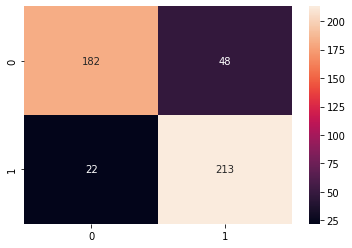

In [32]:
cm = confusion_matrix(vy_data2,yp2)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [33]:
print(classification_report(vy_data2,yp2))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       230
           1       0.82      0.91      0.86       235

    accuracy                           0.85       465
   macro avg       0.85      0.85      0.85       465
weighted avg       0.85      0.85      0.85       465



**Confusion matrix for trainning data**

In [34]:
y_pred=  model.predict(my_training_batch_generator)

In [35]:
yp3 = np.argmax(y_pred,axis=1)
y_true3 = np.argmax(y_data,axis=1)

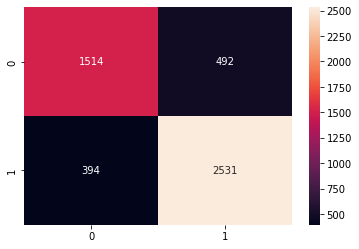

In [36]:
cm2 = confusion_matrix(y_true3,yp3)
sn.heatmap(cm2,annot=True,fmt='d')
plt.show()

In [37]:
print(classification_report(y_true3,yp3))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      2006
           1       0.84      0.87      0.85      2925

    accuracy                           0.82      4931
   macro avg       0.82      0.81      0.81      4931
weighted avg       0.82      0.82      0.82      4931



In [42]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(my_validation_batch_generator)
print("test loss, test acc:", results)



Evaluate on test data
15/15 [==============================] - 29s 2s/step - loss: 0.3734 - accuracy: 0.8366
test loss, test acc: [0.3733895719051361, 0.8365591168403625]
